## Aral Sea Area Caculation

In [15]:
import cv2
import numpy as np

In [16]:
def cv_show(img,name):
    cv2.namedWindow(name,  cv2.WINDOW_NORMAL)
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [17]:
# Show Original Img
img_path = r'20150310-20150403/dint_geocode_rs.png'
img_color = cv2.imread(img_path)
cv_show(img_color, 'image')

In [18]:
# Import Data
img_path = r'20170323-20170404/dint_geocode_rs.png'
mask_path = r'20170323-20170404/epoch2460_0608_infer_dint_geocode.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# cv_show(mask 'mask')
mask[img == 0] = 138
# cv_show(mask 'mask')

In [19]:
# Convert to Gray
gray = mask
# Dilate
kernel = np.ones((3,3),np.uint8)
gray = cv2.dilate(gray,kernel,iterations = 3)
# Binarization
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
cv_show(thresh,'thresh')

In [20]:
# Get Boundary Information
contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# contours,hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

In [21]:
# Find the nth largest number's index from the bottom
arc_list,idx_list = [], []
for i in range(0, len(contours)):
    arc = cv2.arcLength(contours[i],True)
    arc_list.append(arc)
    
arc_list_enu = list(enumerate(arc_list))
# print(arc_list)
# print(arc_list_enu)
arc_list_sorted = sorted(arc_list_enu , key=lambda ele: ele[1], reverse=True) 
# print(arc_list_sorted)
for i in range(len(arc_list_sorted)):
    idx_list.append(arc_list_sorted[i][0])
# print(idx_list)

In [22]:
# draw_img = img.copy()
draw_img = np.zeros(img.shape, np.uint8)
draw_img[draw_img == 0 ] = 255
# Draw All Boundary
res = cv2.drawContours(draw_img, contours, -1, (0, 0, 0), 3)
cv_show(res,'res')

In [23]:
draw_img = np.zeros(img.shape, np.uint8)
draw_img[draw_img == 0 ] = 255
# Choose Different Boundary
# Choose Different Boundary
m = 3
for i in range(m):
    res = cv2.drawContours(draw_img, contours, idx_list[i], (0, 0, 0), 3)
    cv_show(res, 'res')

In [102]:
# Area & Perimeter Singel
cnt = contours[idx_list[0]]
# print(cnt,cnt.shape)
s = cv2.contourArea(cnt)
c = cv2.arcLength(cnt,True)
print('Area:{},perimeter:{}'.format(s, c))

[[[1121  205]]

 [[1120  206]]

 [[1119  207]]

 ...

 [[1122  207]]

 [[1122  206]]

 [[1122  205]]] (3704, 1, 2)
Area:353777.0,perimeter:4279.756818056107


In [37]:
# Area & Perimeter All
s_all, c_all = 0, 0
for i in range(m):
    cnt = contours[idx_list[i]]
    s = cv2.contourArea(cnt)
    c = cv2.arcLength(cnt,True)
    s_all += s
    c_all += c
print('Total area:{},total perimeter:{}'.format(s_all, c_all))

Total area:762430.5,total perimeter:10707.088441491127


## Looping Read and Caculate

In [19]:
import os, cv2
import numpy as np
from matplotlib import pyplot as plt

In [20]:
def cv_show(img,name):
    cv2.namedWindow(name,  cv2.WINDOW_NORMAL)
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [21]:
def boundary_extraction(img_path,mask_path):
    # Import Data
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask[img == 0] = 138
    # Convert to Gray
    gray = mask
    # Dilate
    kernel = np.ones((3,3),np.uint8)
    gray = cv2.dilate(gray,kernel,iterations = 3)
    # Binarization
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    # Get Boundary Information
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # Find the nth largest number's index from the bottom
    arc_list,idx_list = [], []
    for i in range(0, len(contours)):
        arc = cv2.arcLength(contours[i],True)
        arc_list.append(arc)

    arc_list_enu = list(enumerate(arc_list))
    arc_list_sorted = sorted(arc_list_enu , key=lambda ele: ele[1], reverse=True) 

    for i in range(len(arc_list_sorted)):
        idx_list.append(arc_list_sorted[i][0])
       
    # Area & Perimeter All
    s_list, c_list, boundary_list = [], [], []
    s_all, c_all, i = 0, 0, 0
    while True:
        cnt = contours[idx_list[i]]
        s = cv2.contourArea(cnt)
        c = cv2.arcLength(cnt,True)
        if c > 1000 and s >10000: 
            s_all += s
            c_all += c
            boundary_list.append(cnt)
        else:
            s_all += 0
            c_all += 0
            break
        i+=1
        
        s_list.append(s_all)
        c_list.append(c_all)
     
    # s_list, c_list [a, b, c, ...]  diff value of area and perimeter
    # boundary_list [cnt1, cnt2, cnt3, ...] diff ndarray of cnt corridiates 
    return s_list, c_list, boundary_list


In [22]:
def plot_figure(img_path, mask_path):
    
    xj,yj,xk,yk,xl,yl = [], [], [], [], [], []
    s_list, c_list, boundary_list = boundary_extraction(img_path, mask_path)
    
    # Area and Perimeter
    s, c= 0, 0
    for i in range(len(s_list)):
        s += s_list[i]
    for i in range(len(c_list)):
        c += c_list[i]
    # Boundary 
    for i in range(len(boundary_list)):
        for j in range(boundary_list[i].shape[0]):
            xj.append(boundary_list[i][j,0,0])
            yj.append(boundary_list[i][j,0,1])
    # Plot 
    plt.scatter(xj,yj,s=1)  
    return s,c


C:\Users\pc\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


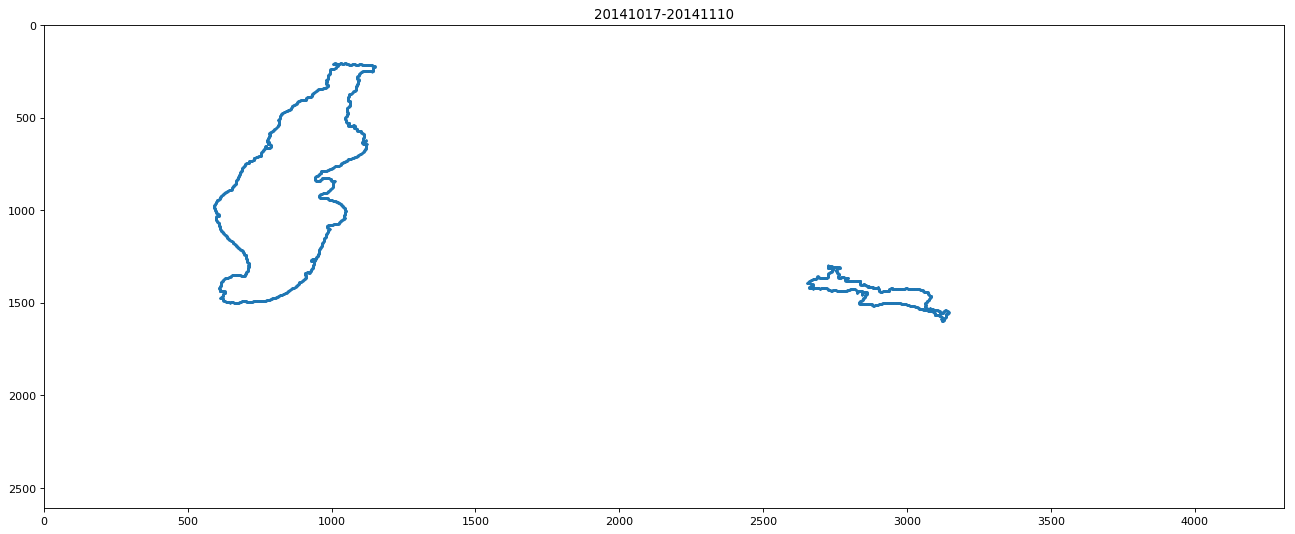

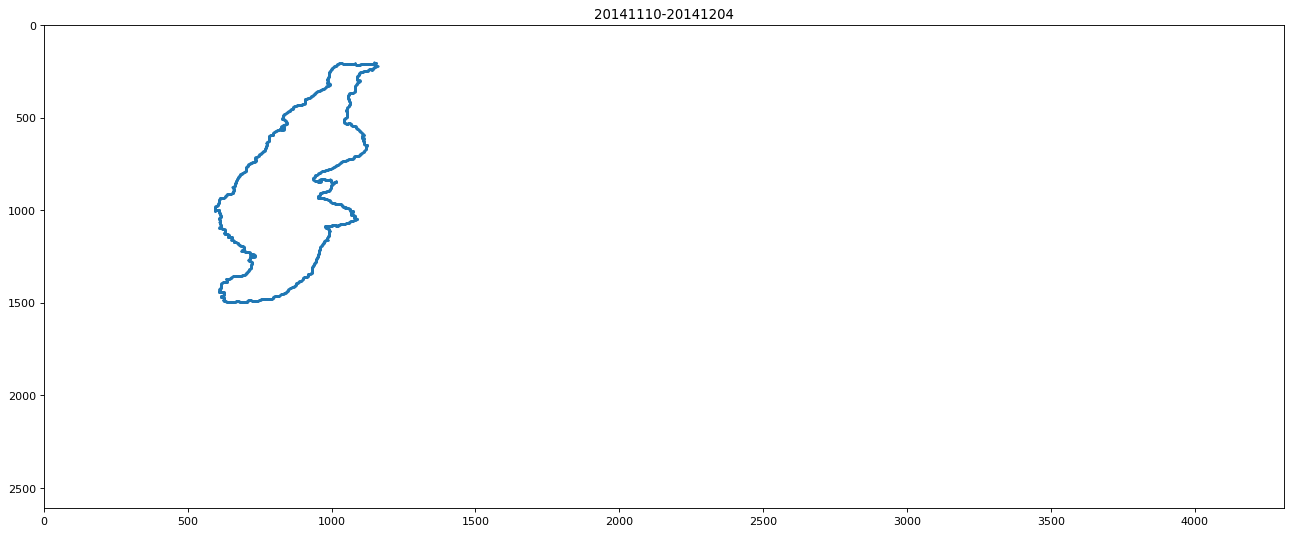

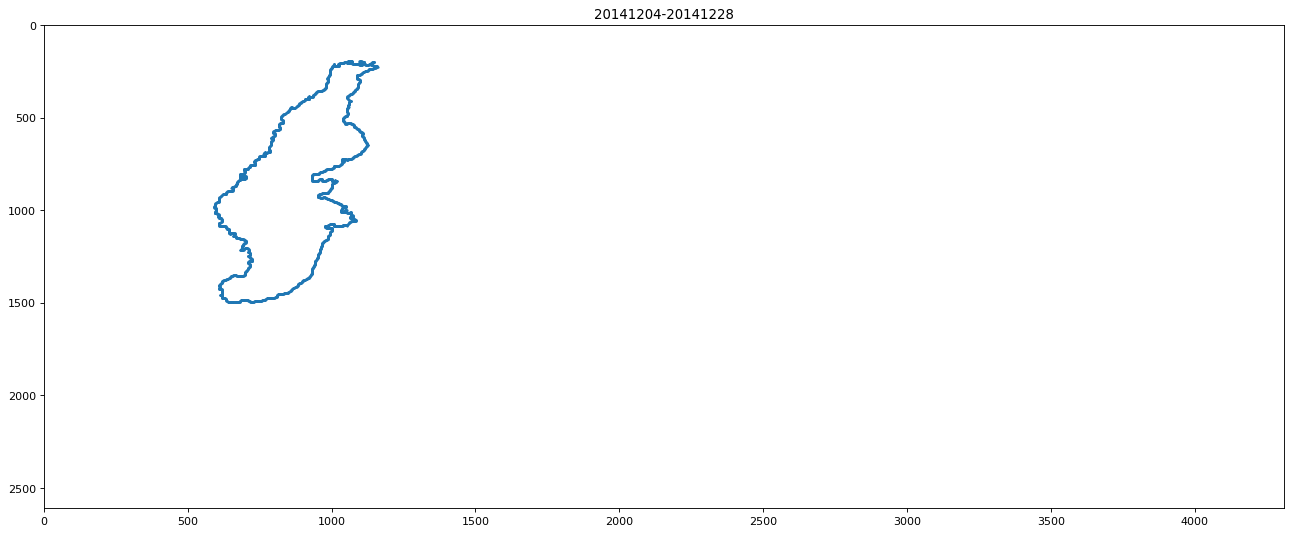

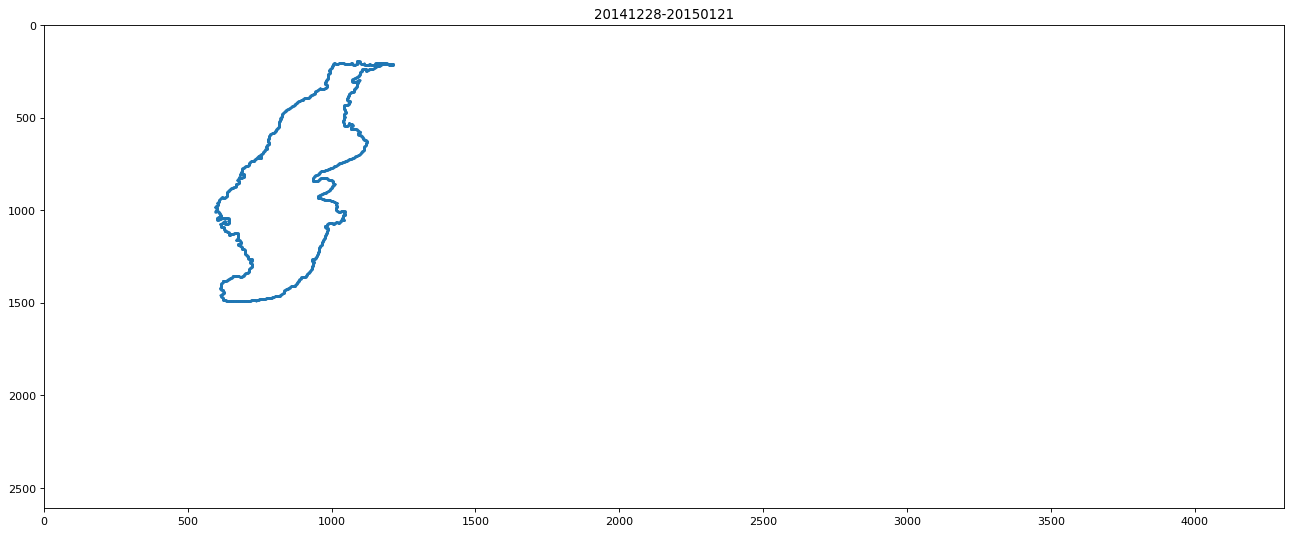

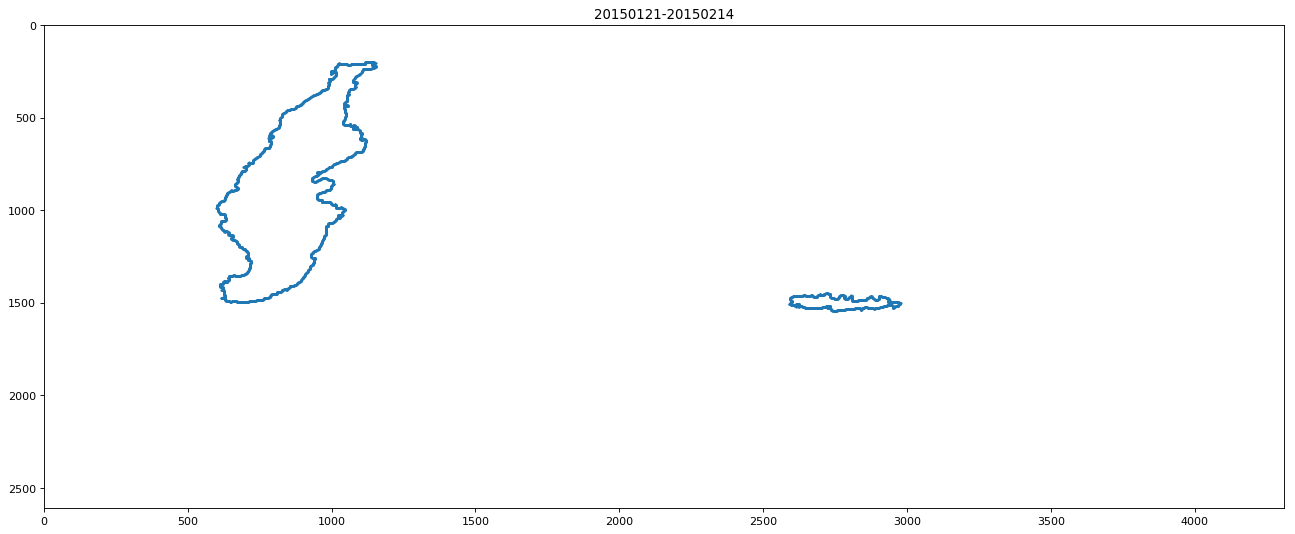

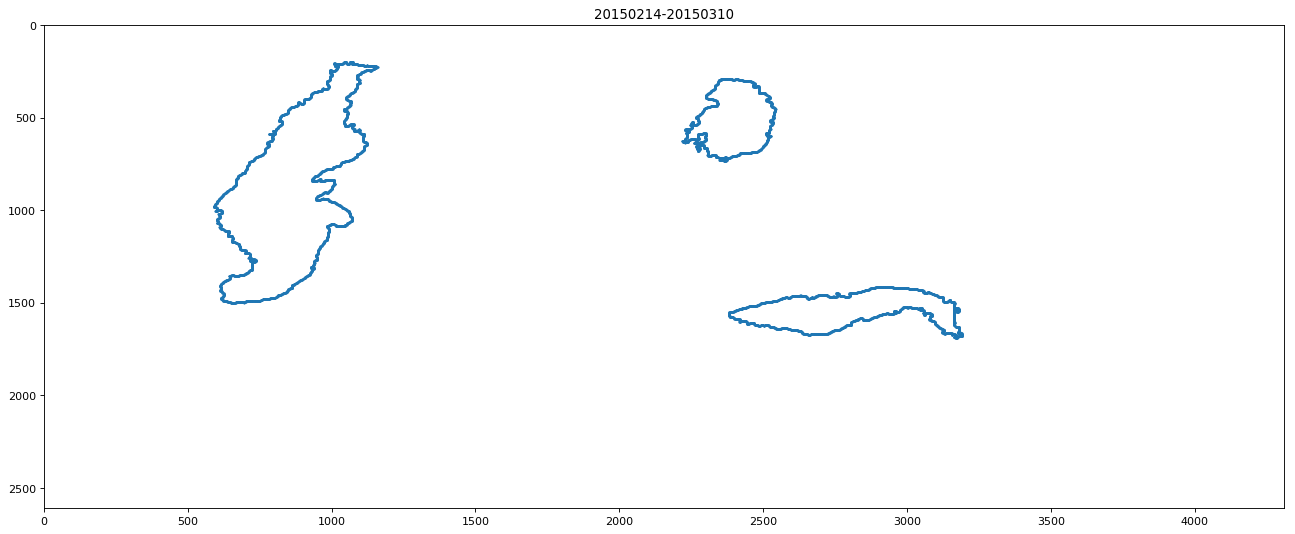

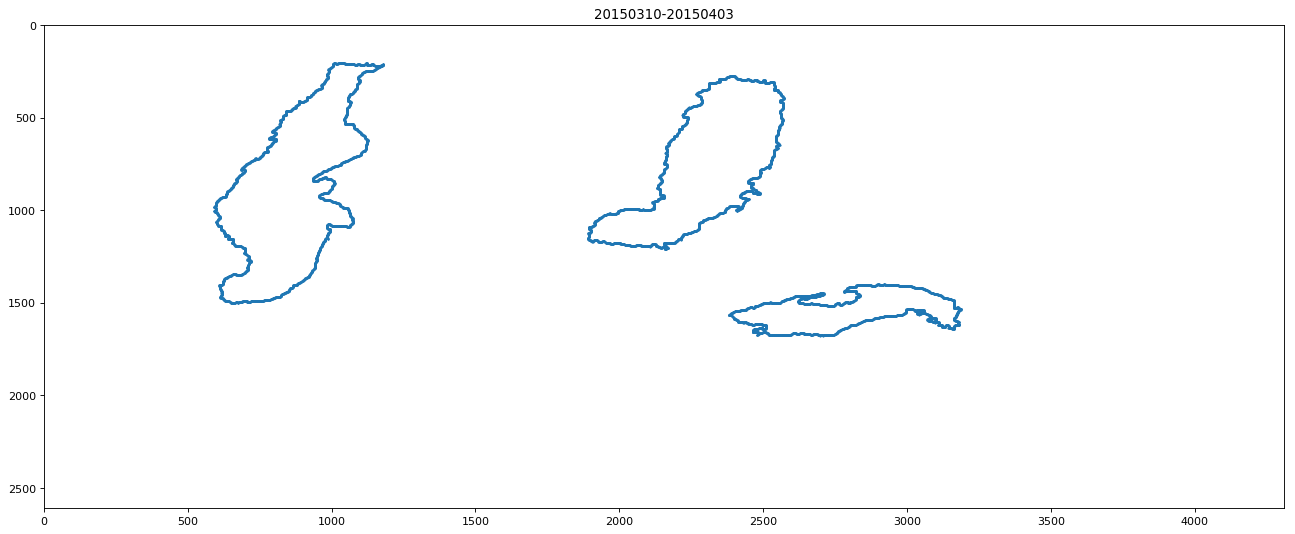

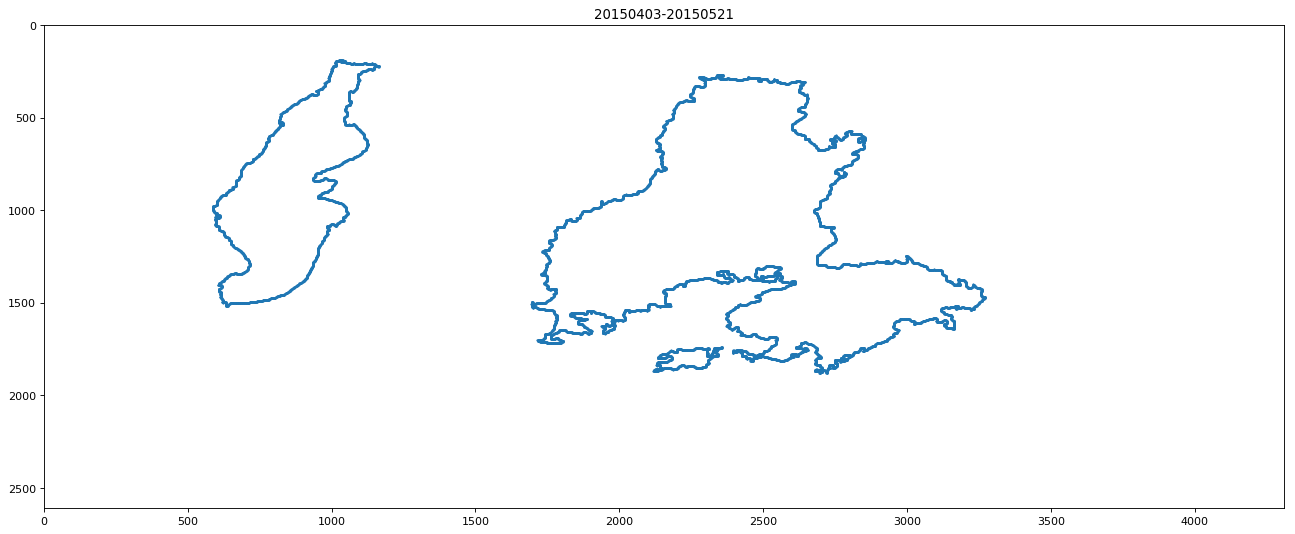

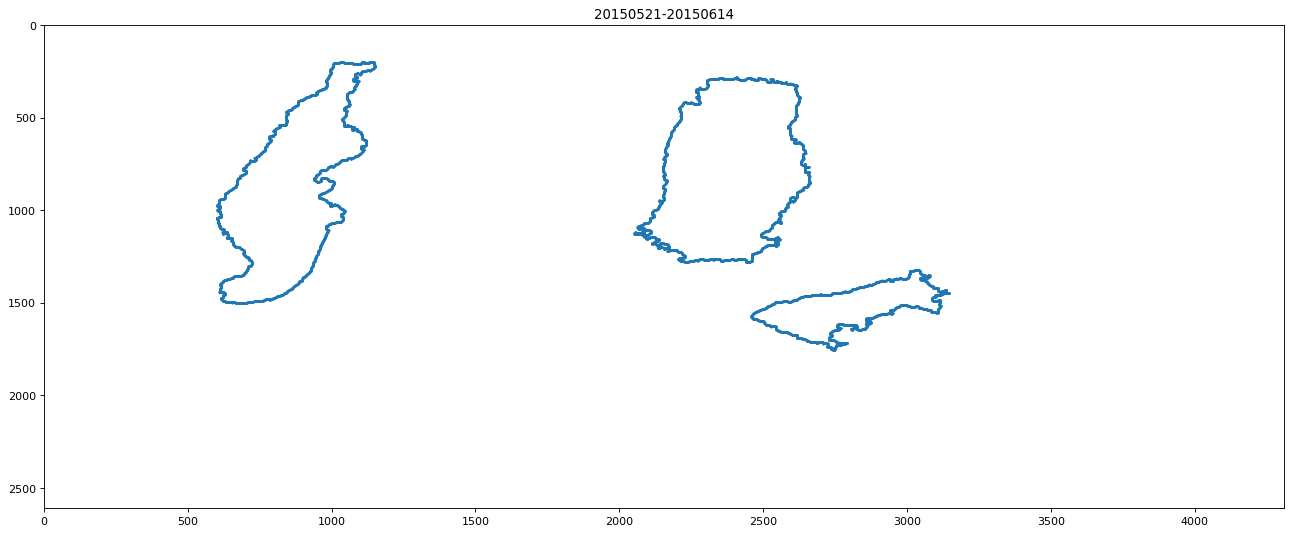

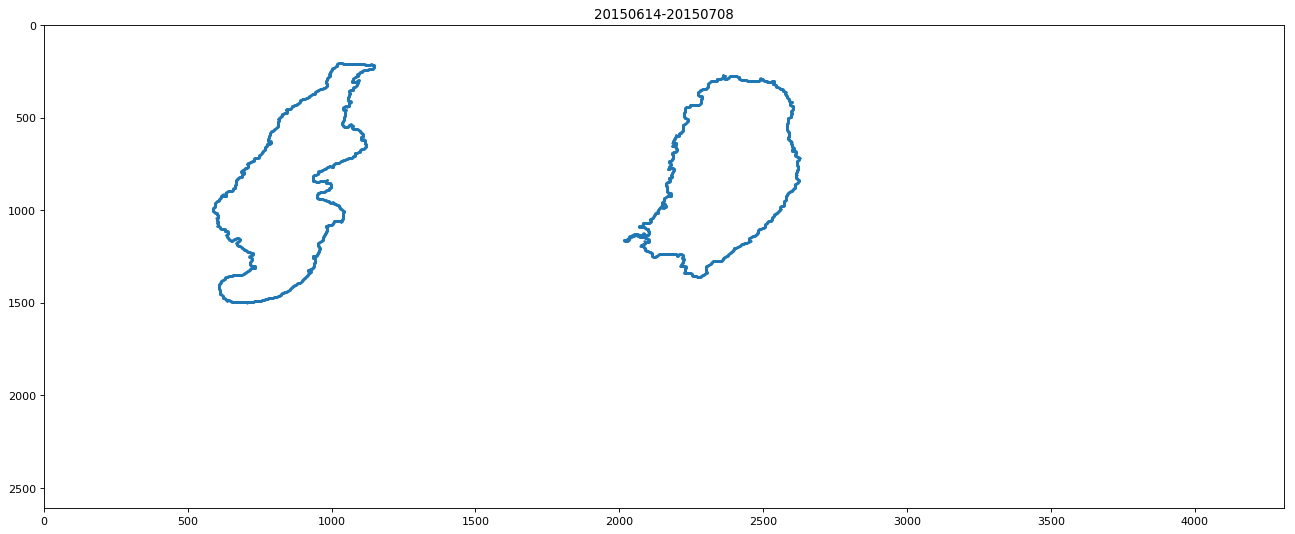

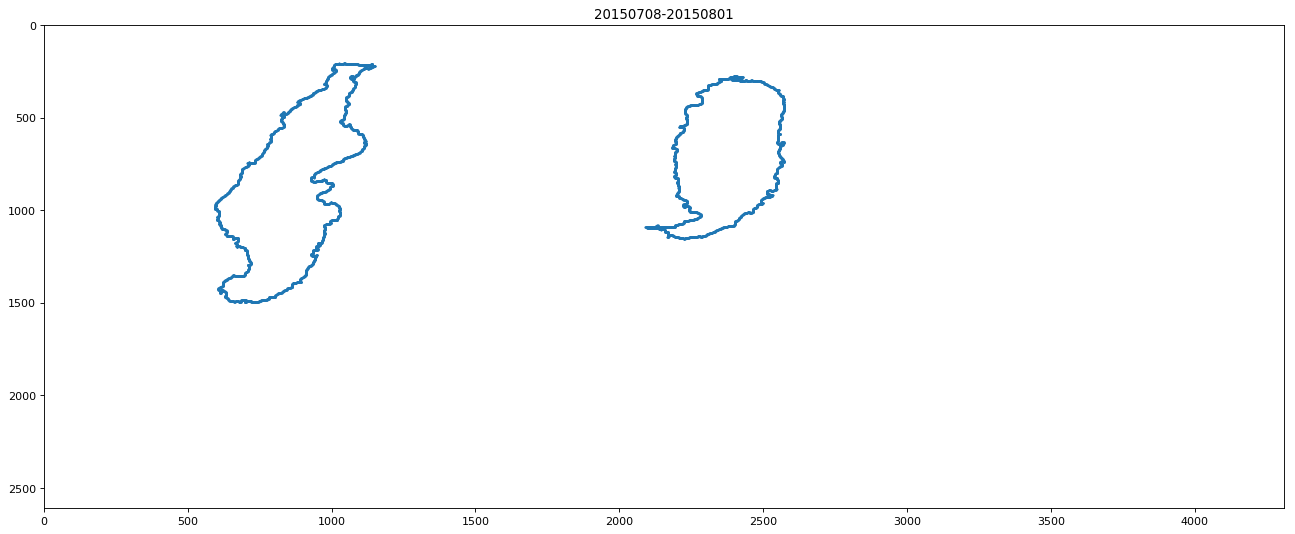

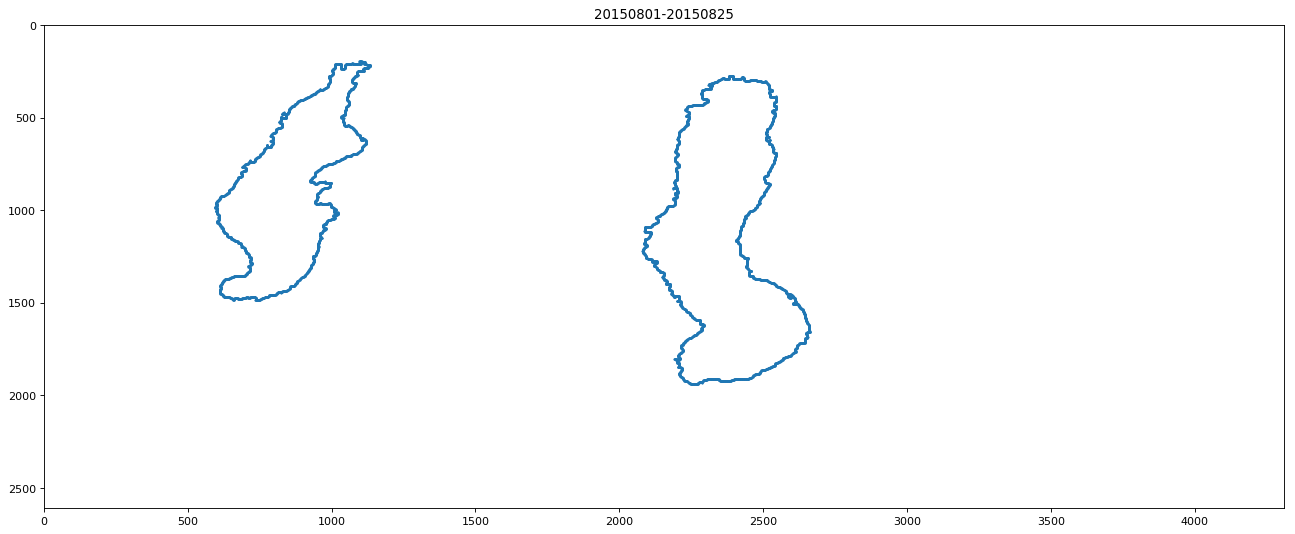

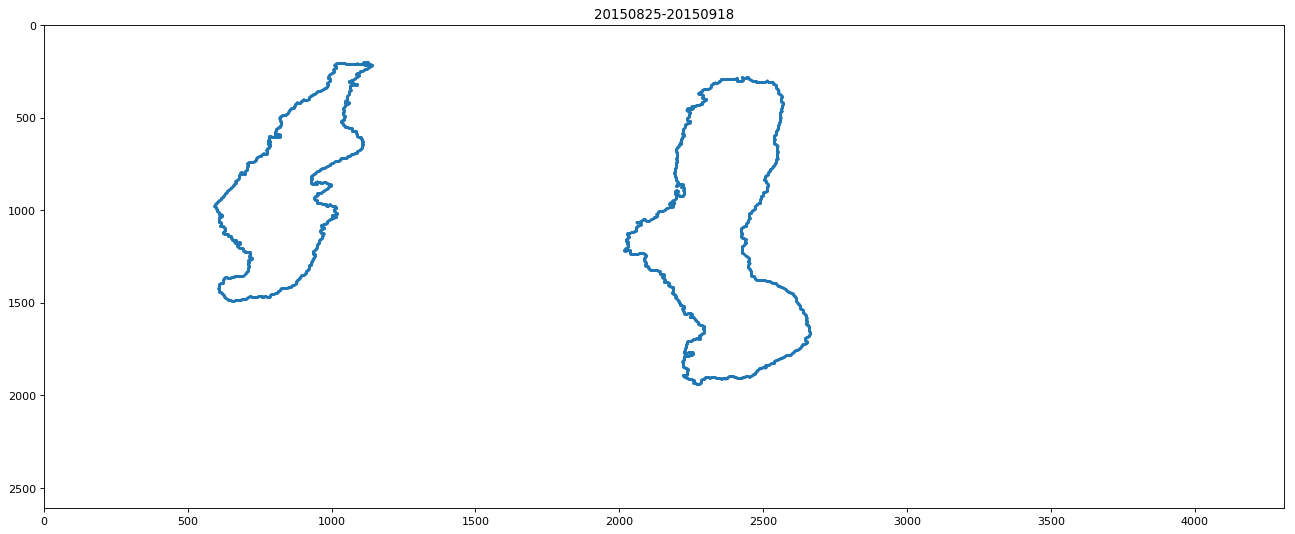

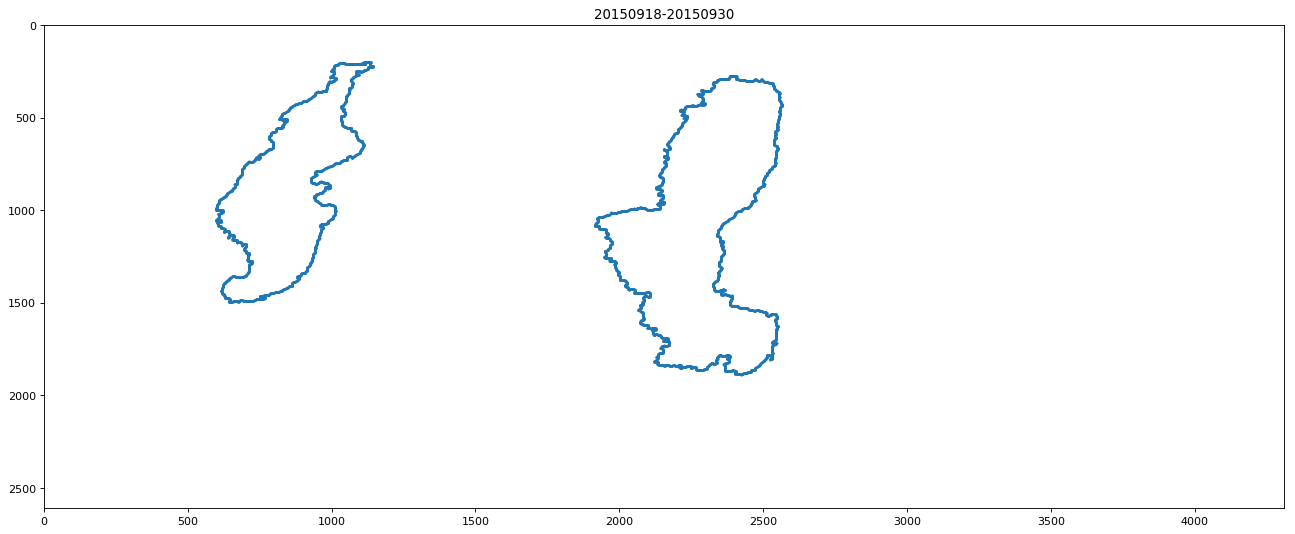

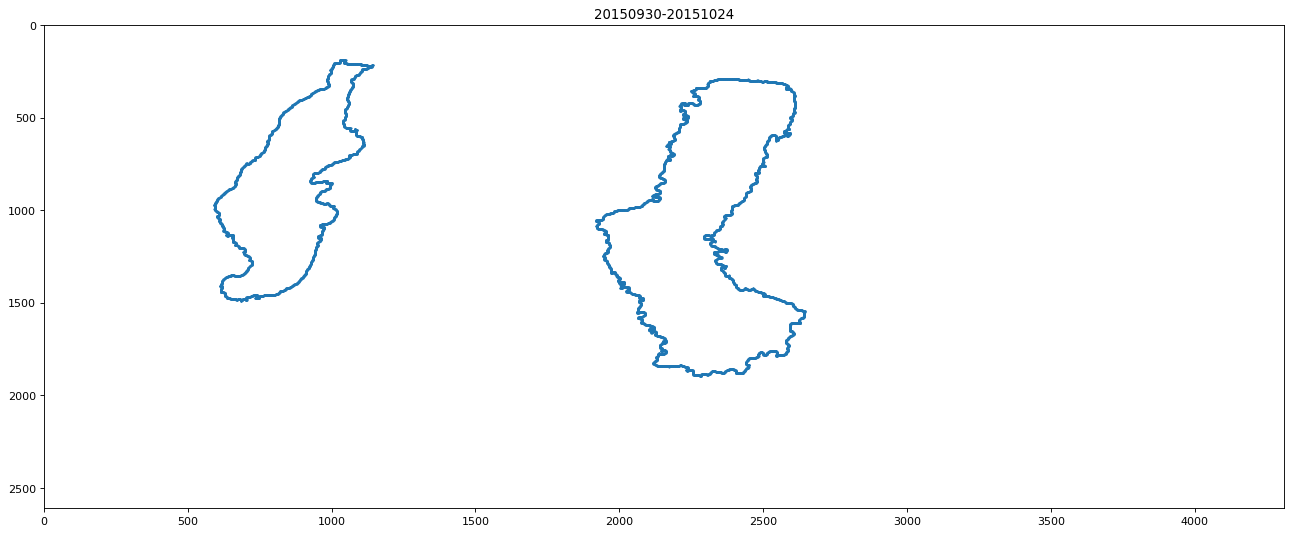

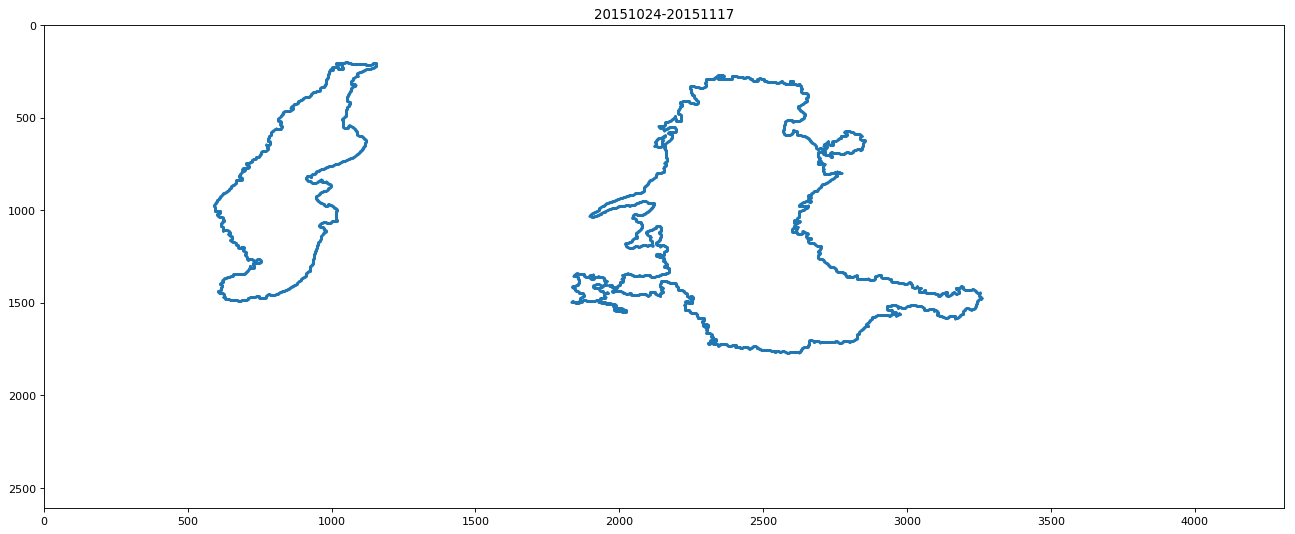

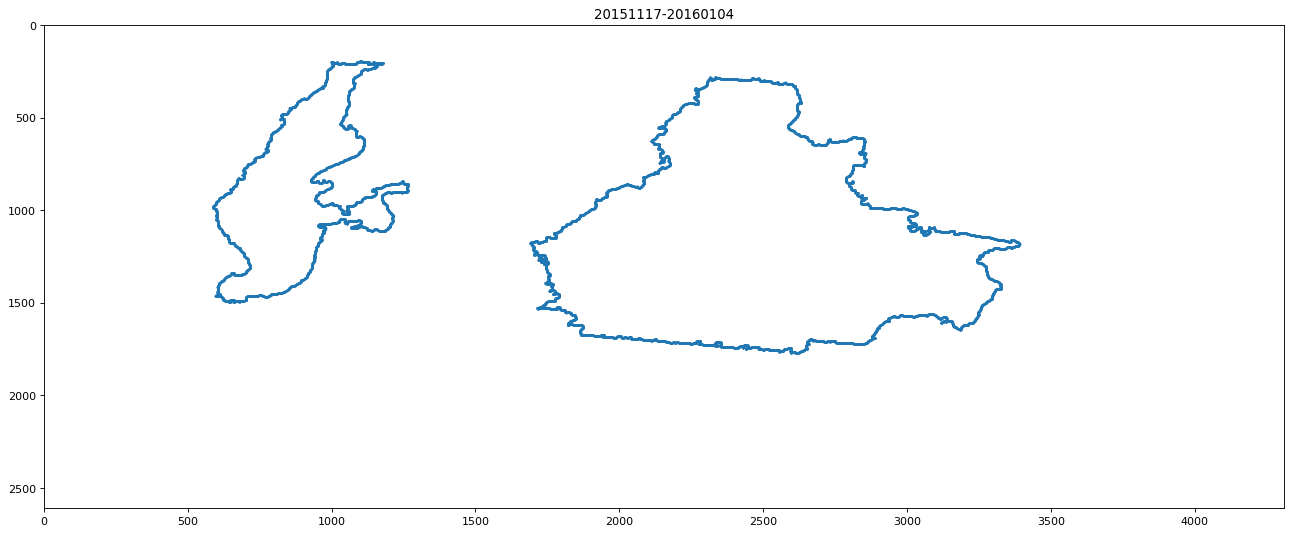

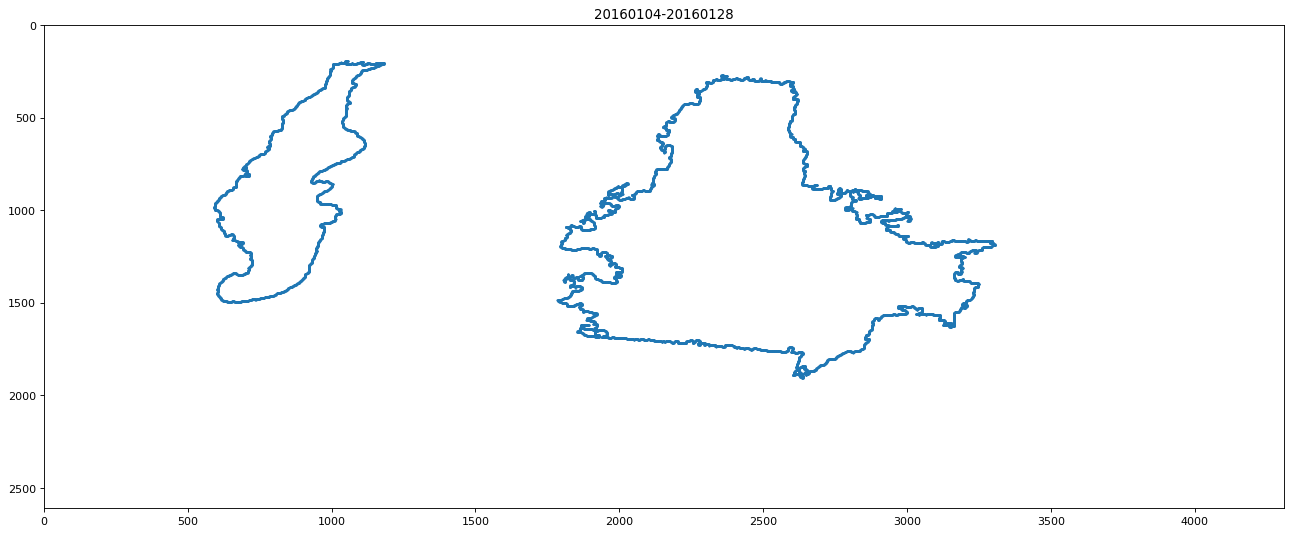

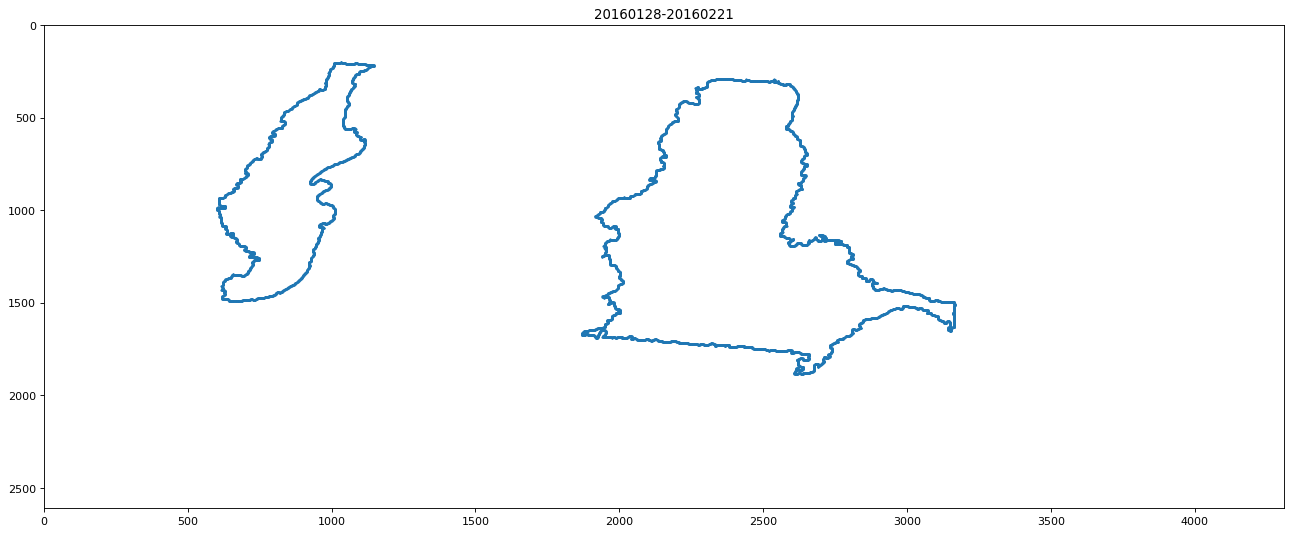

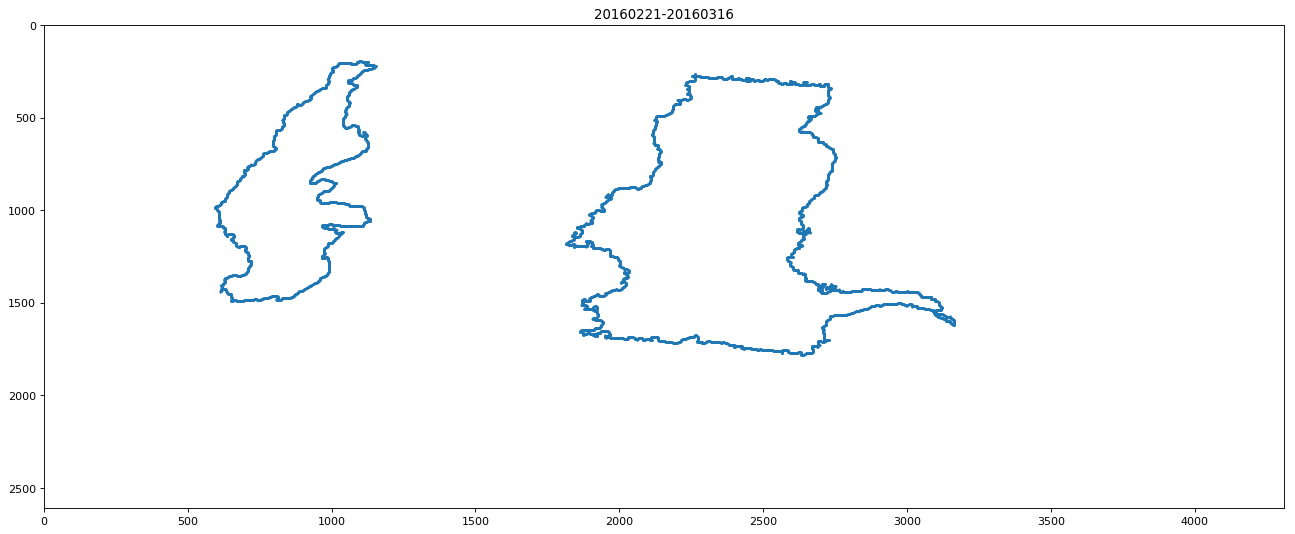

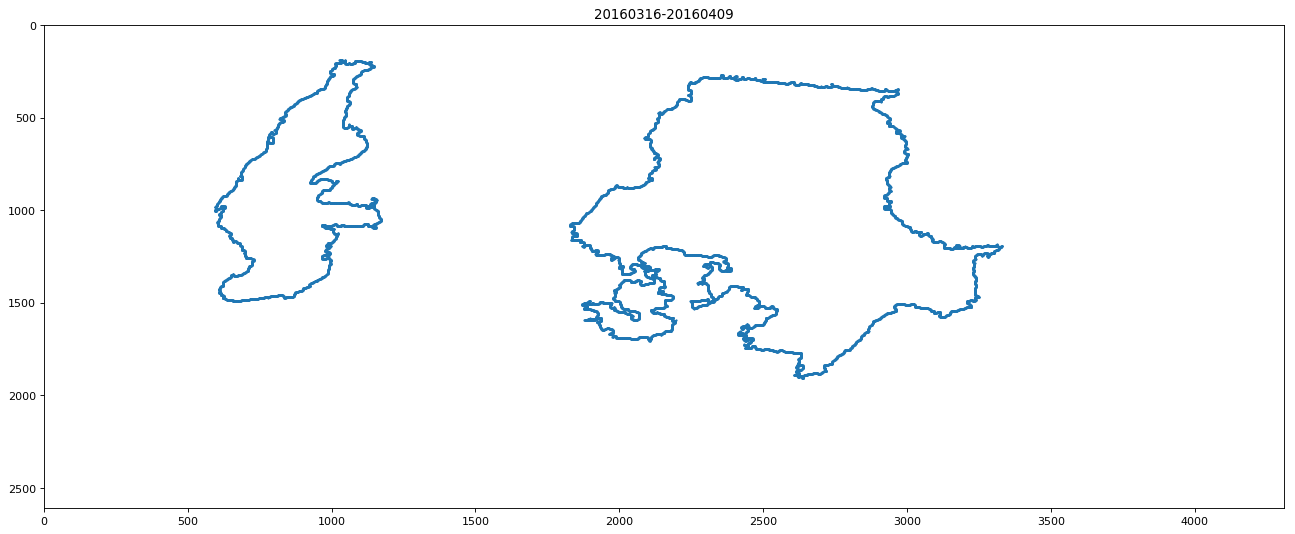

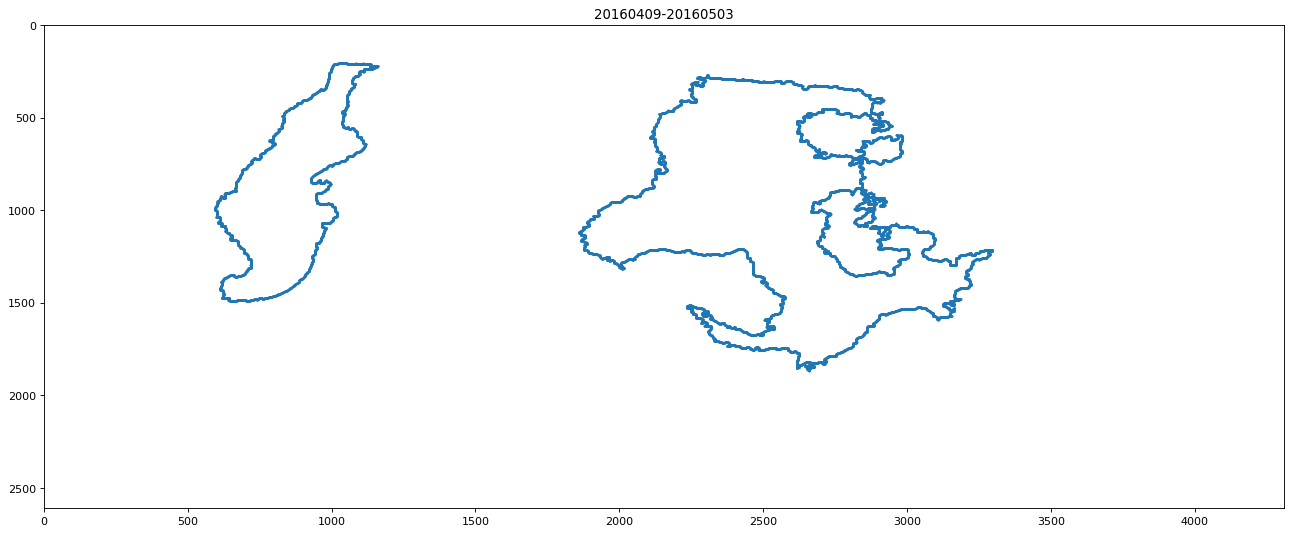

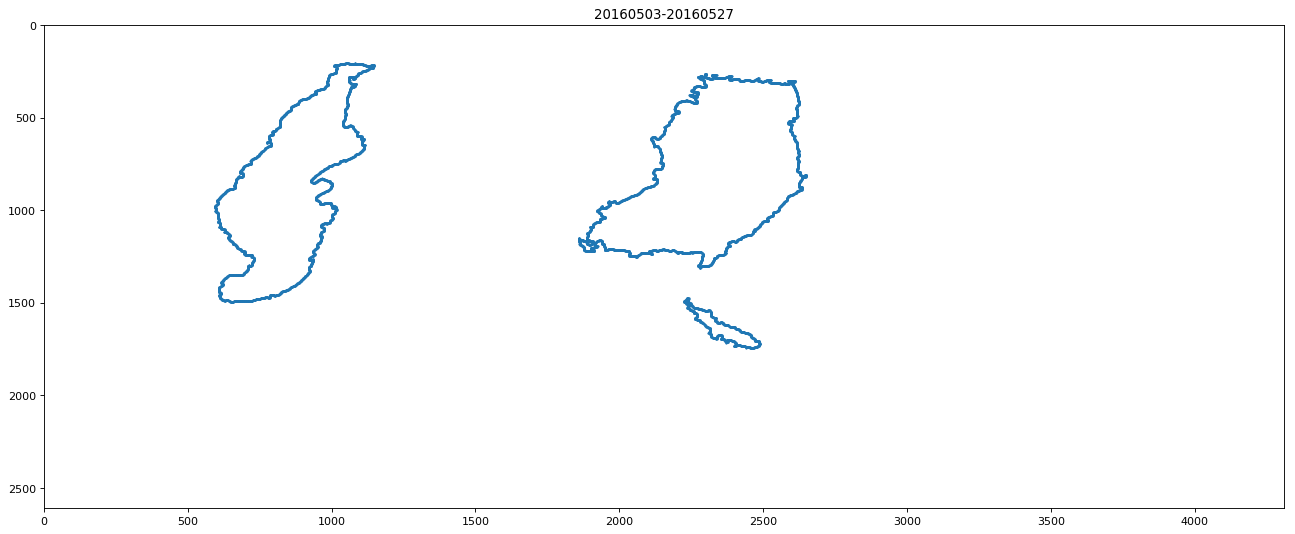

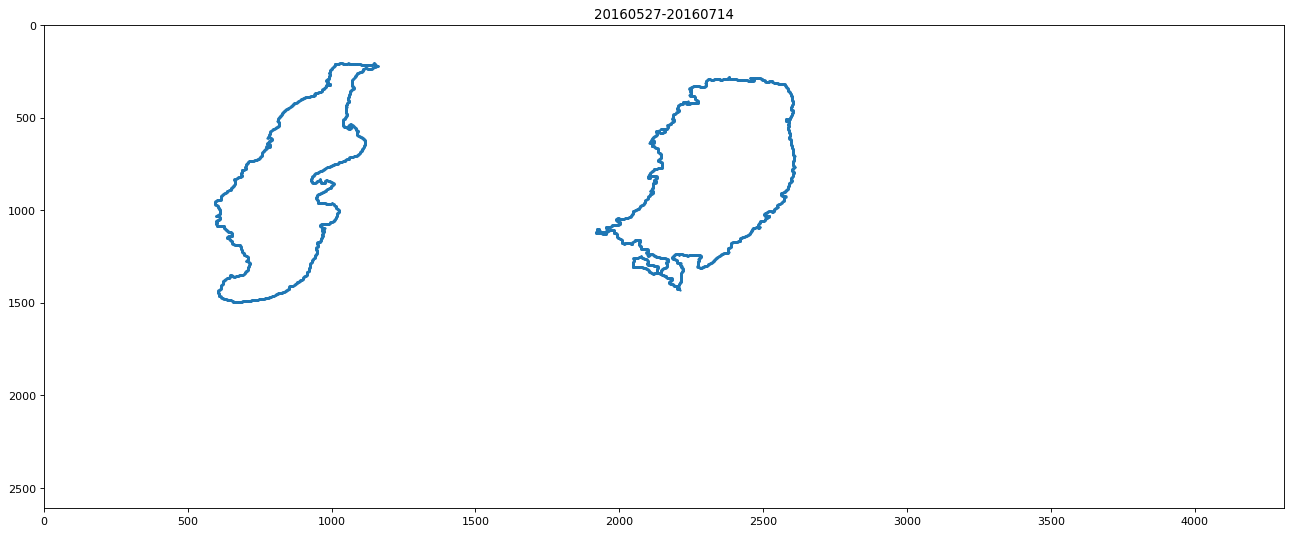

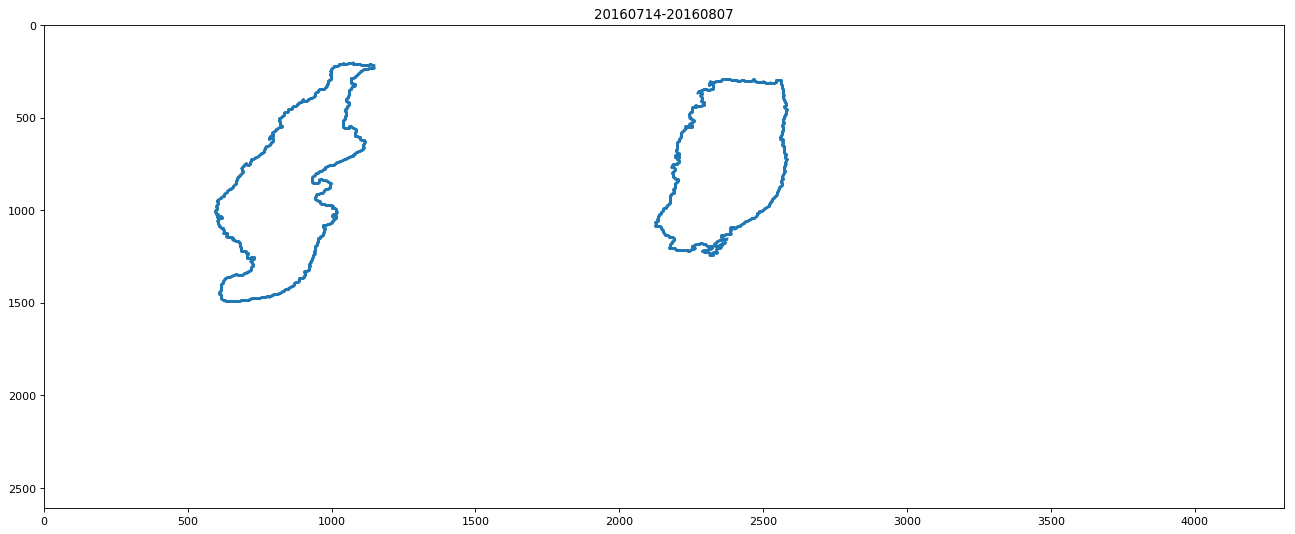

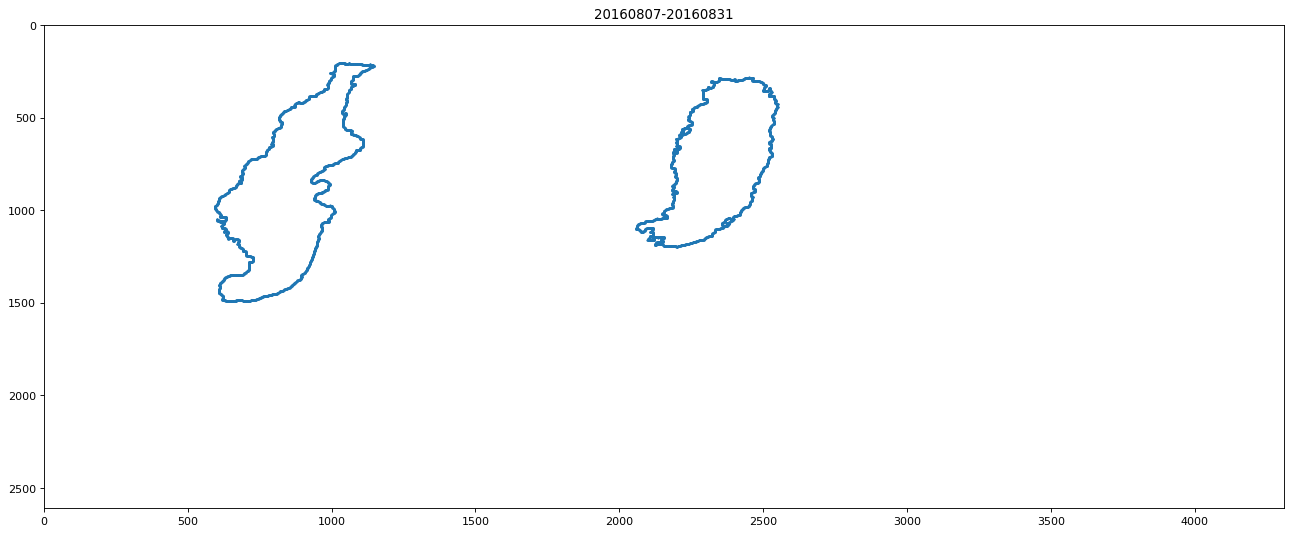

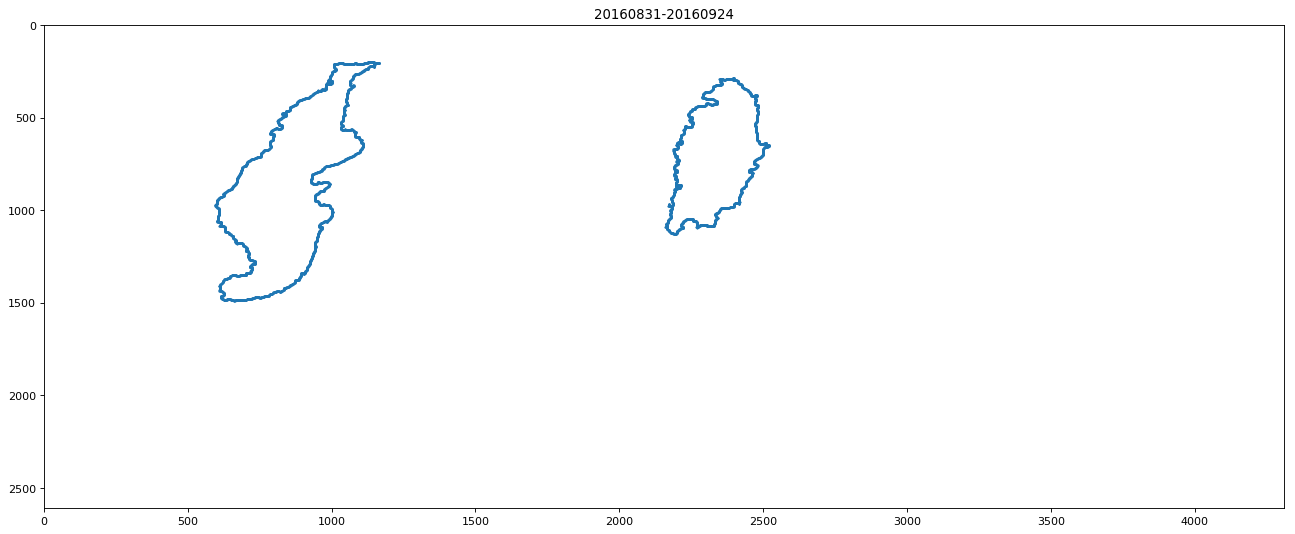

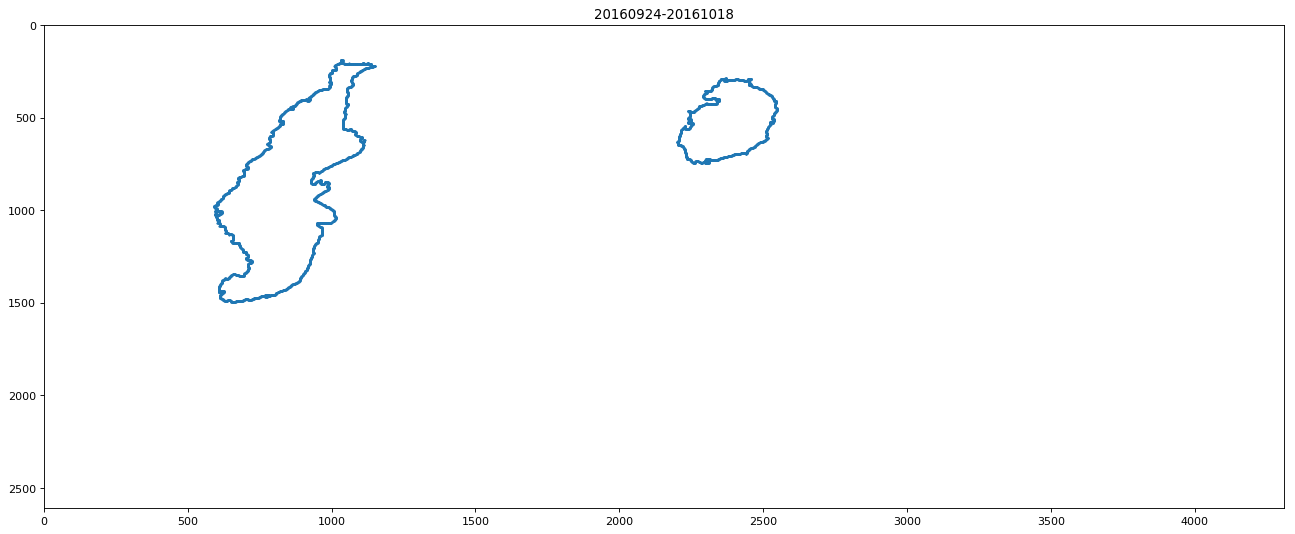

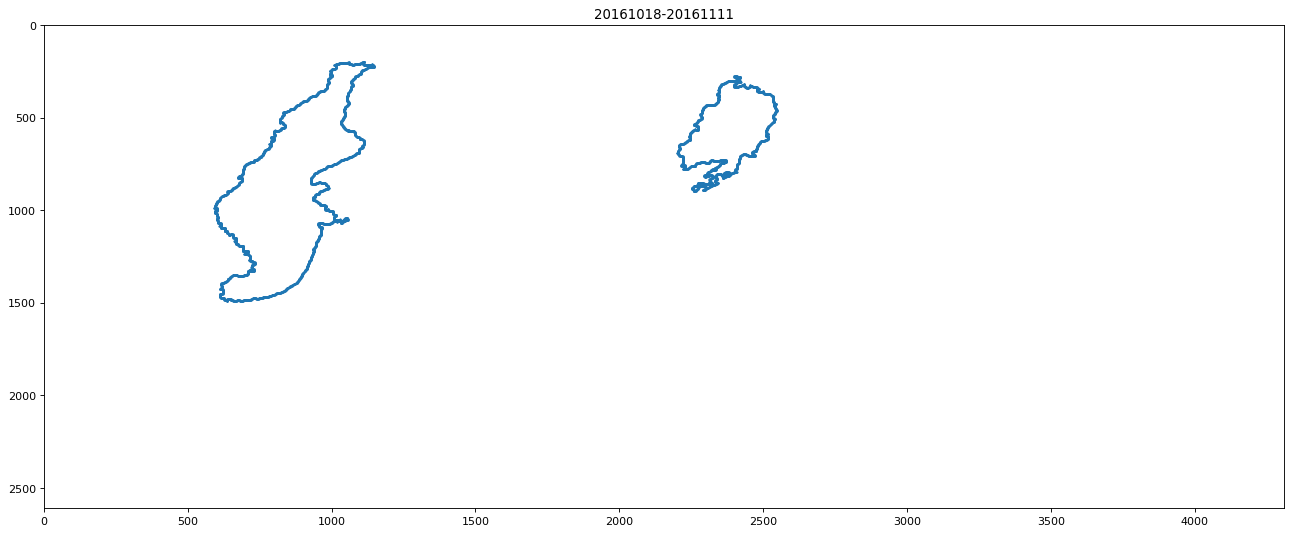

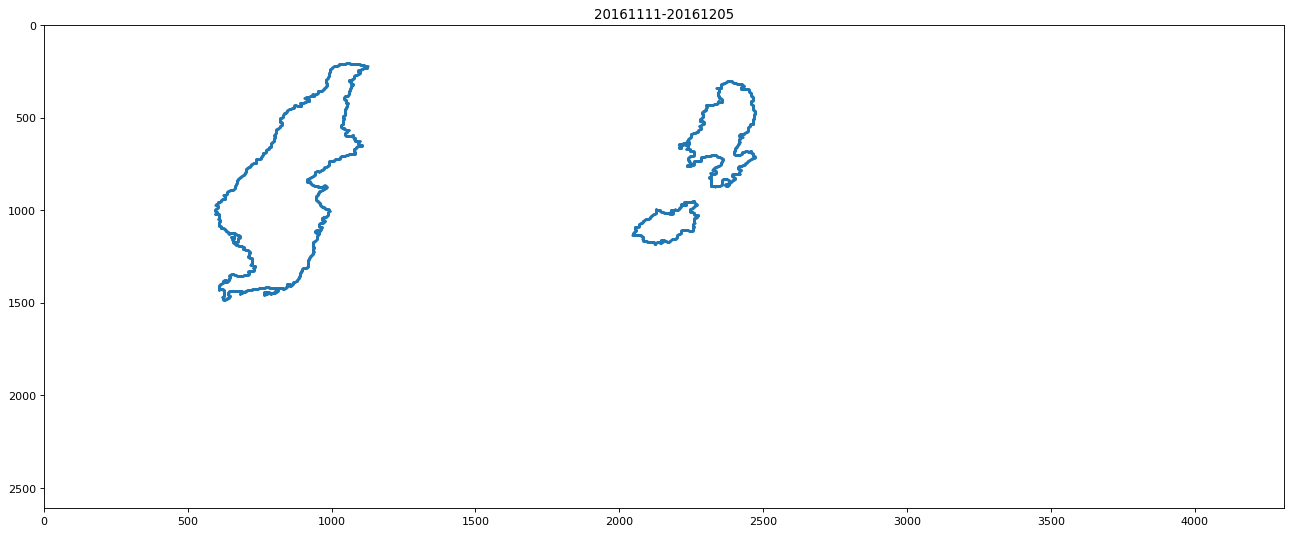

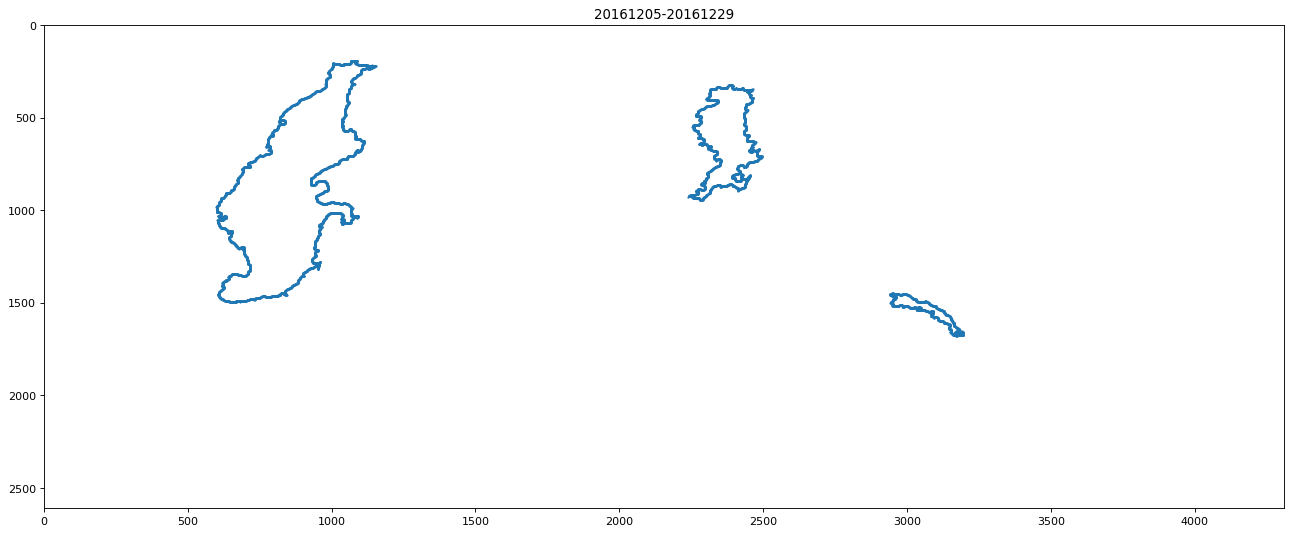

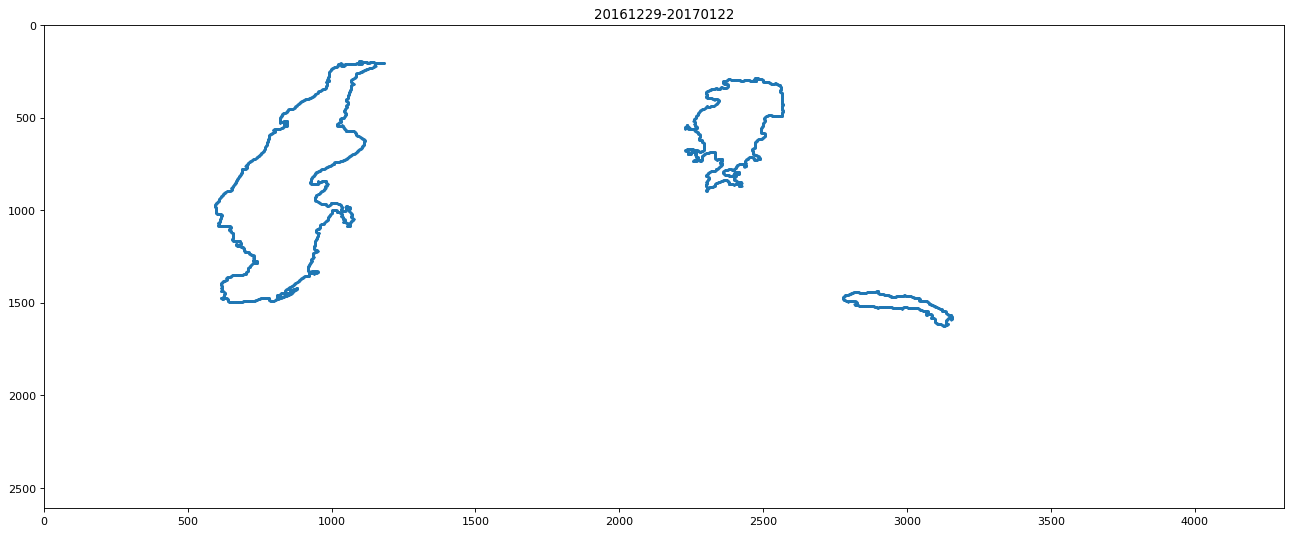

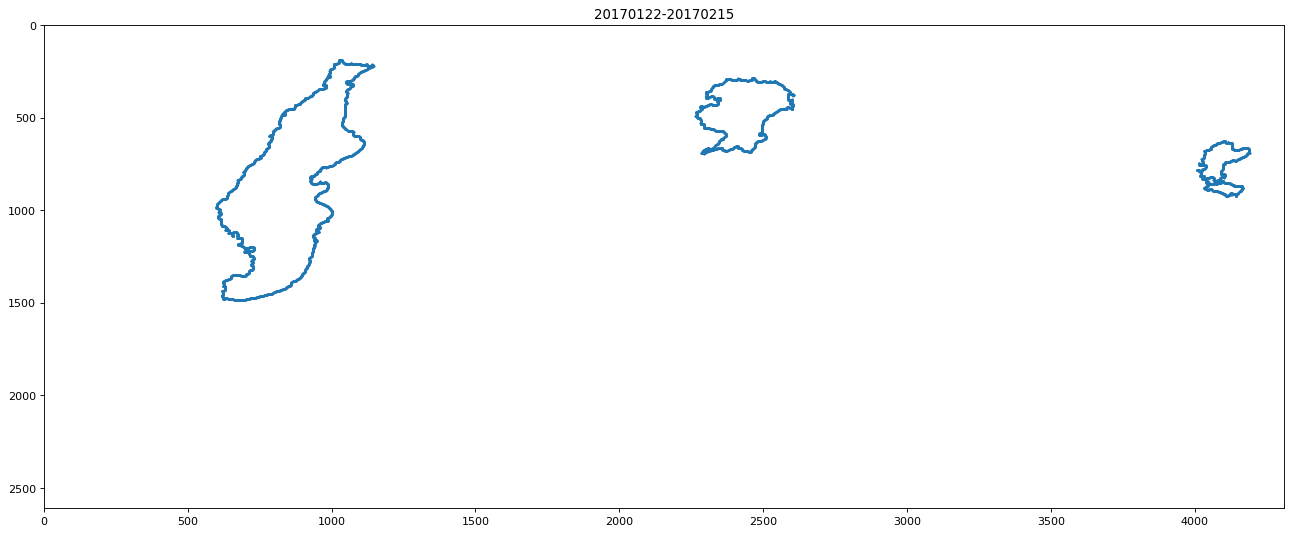

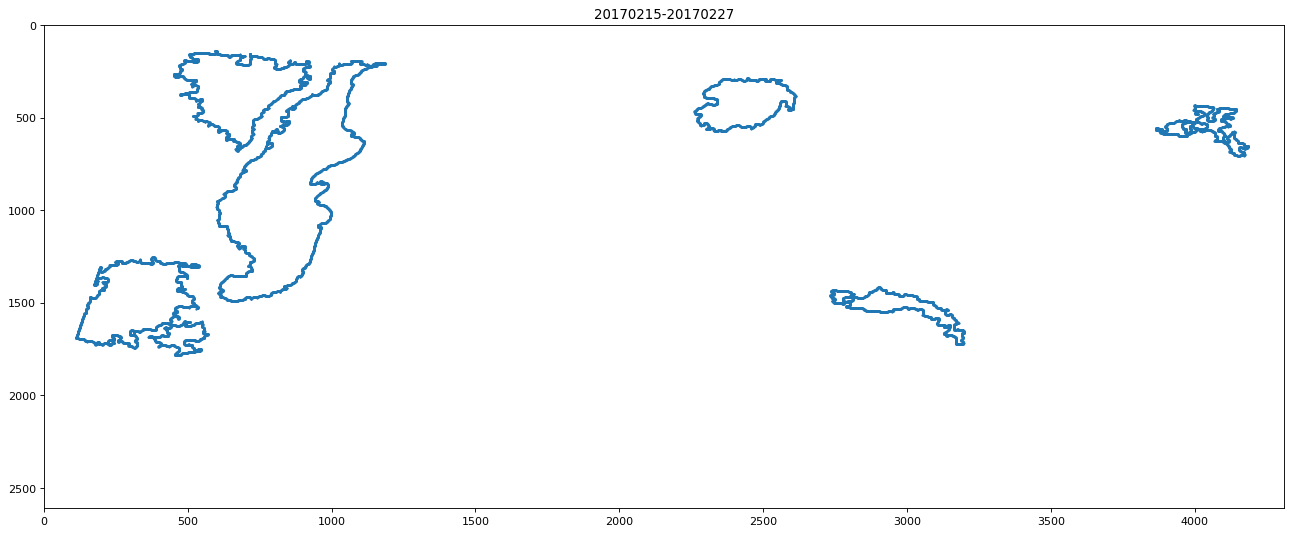

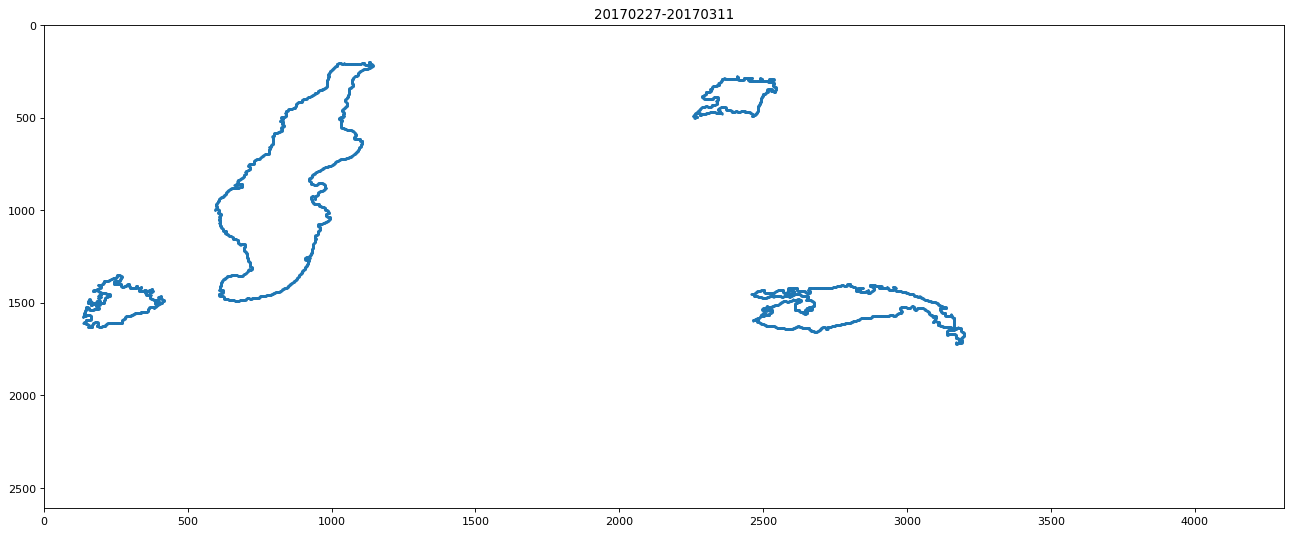

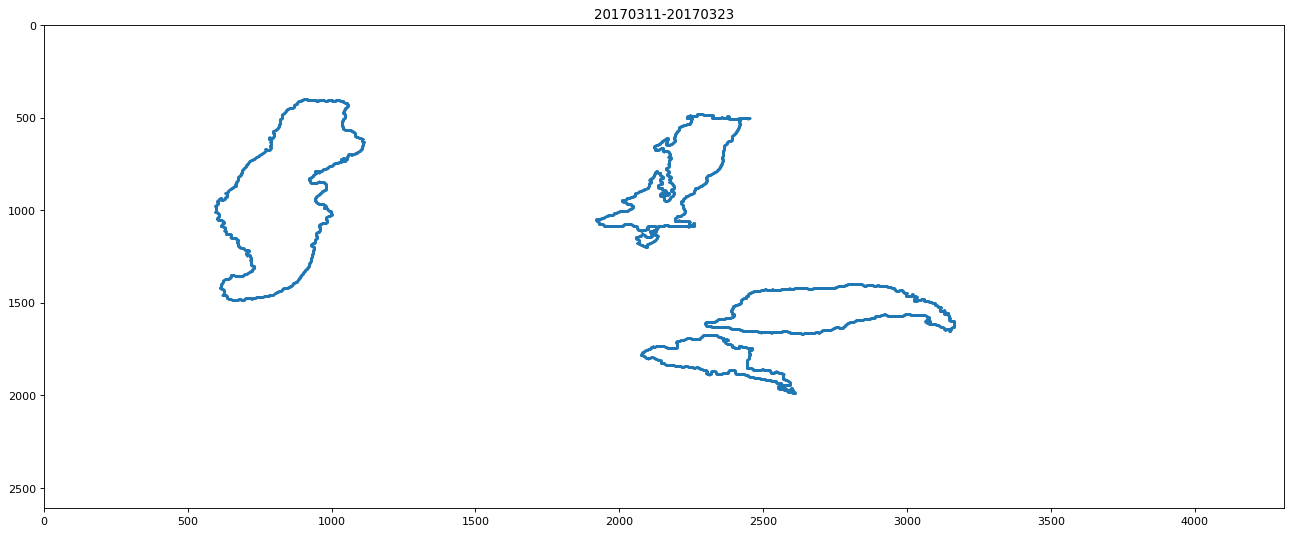

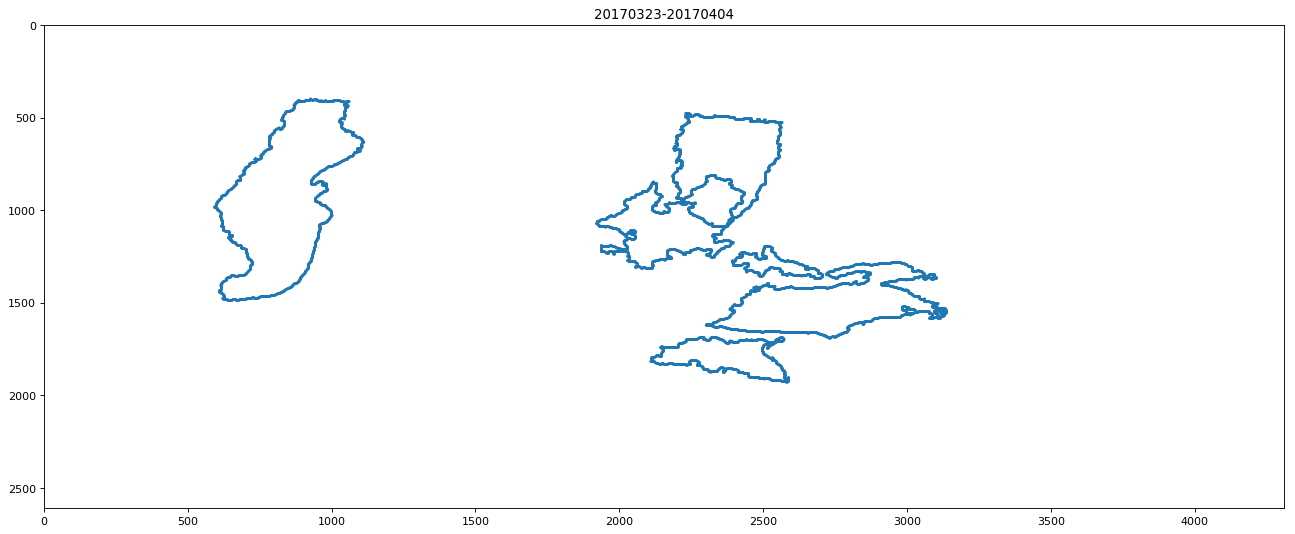

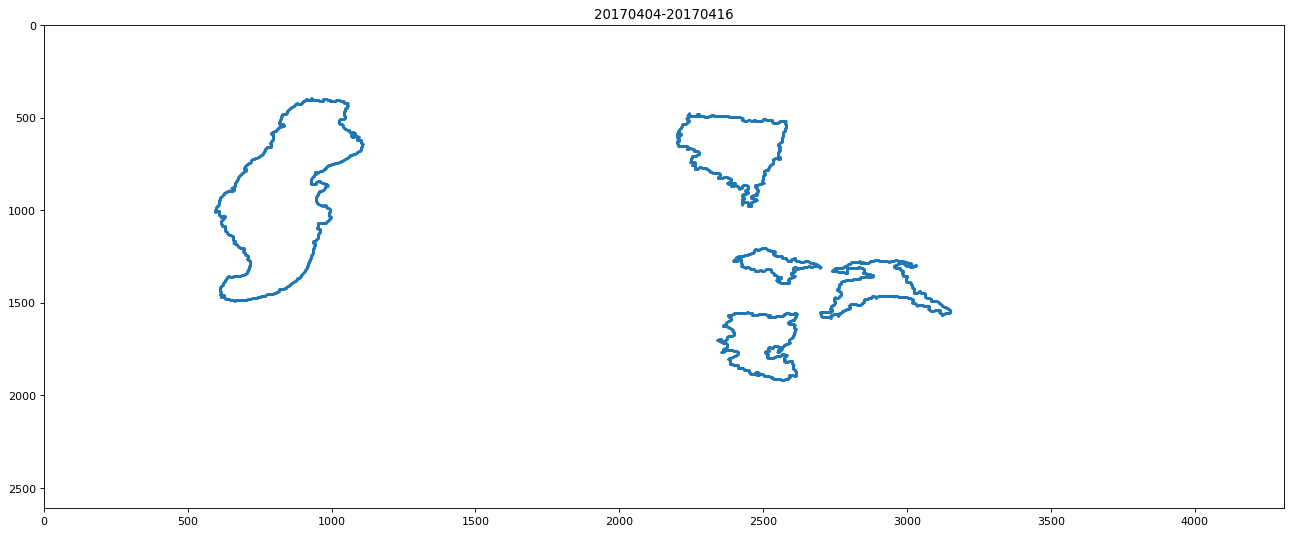

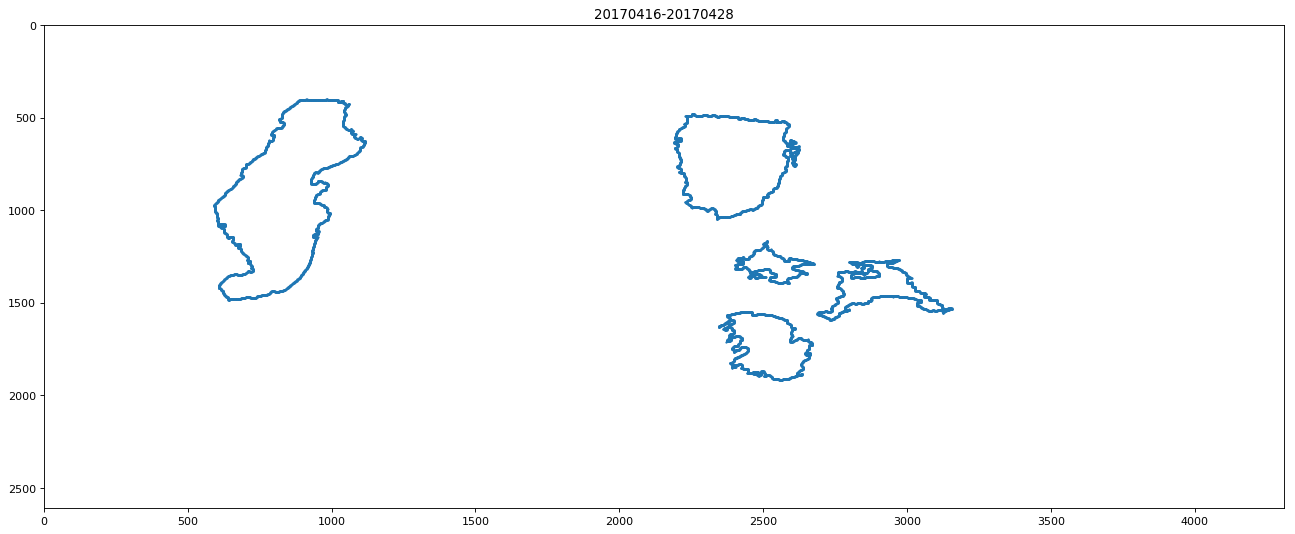

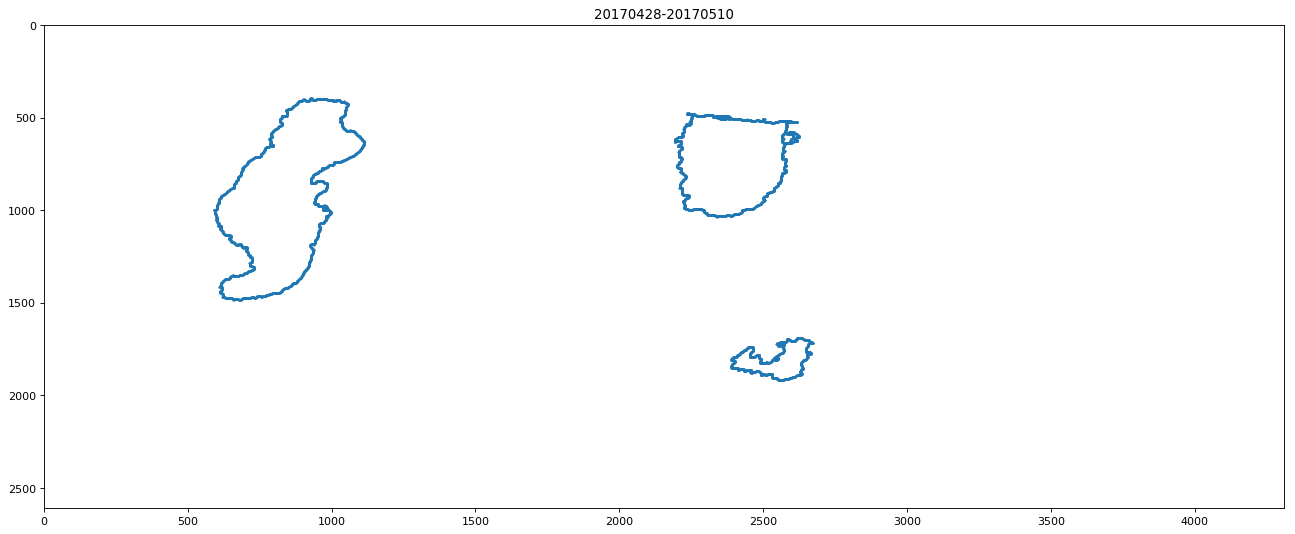

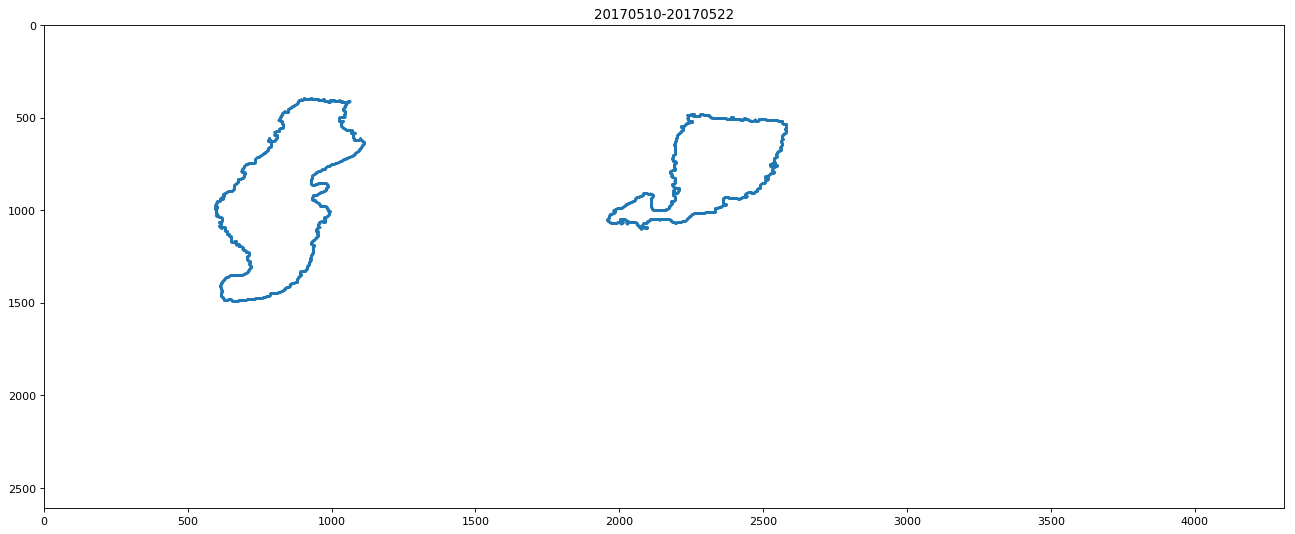

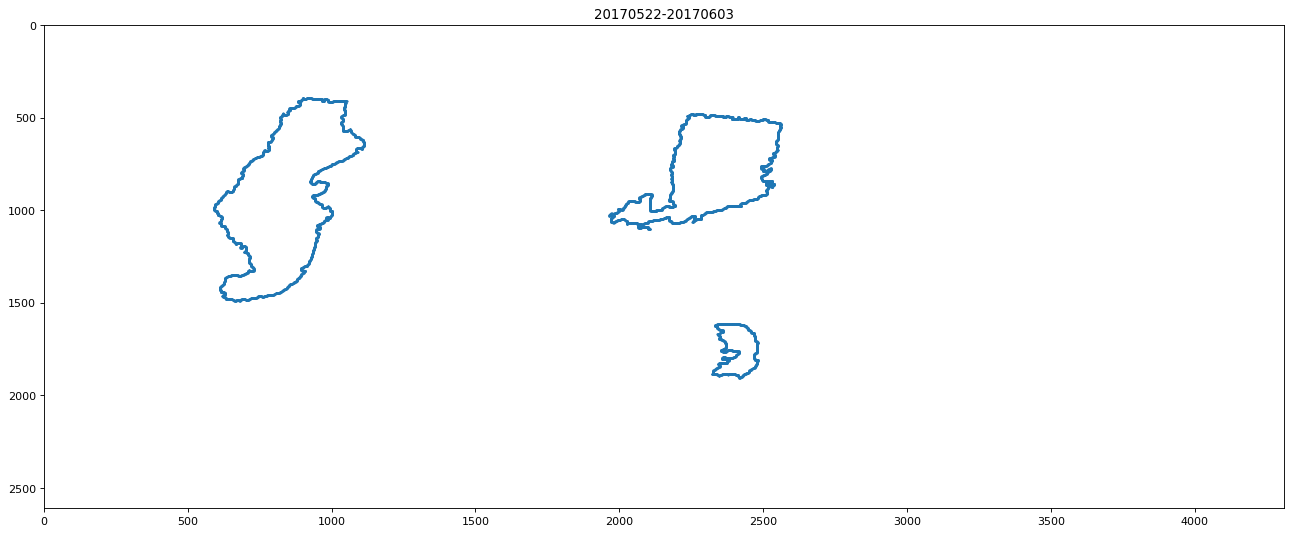

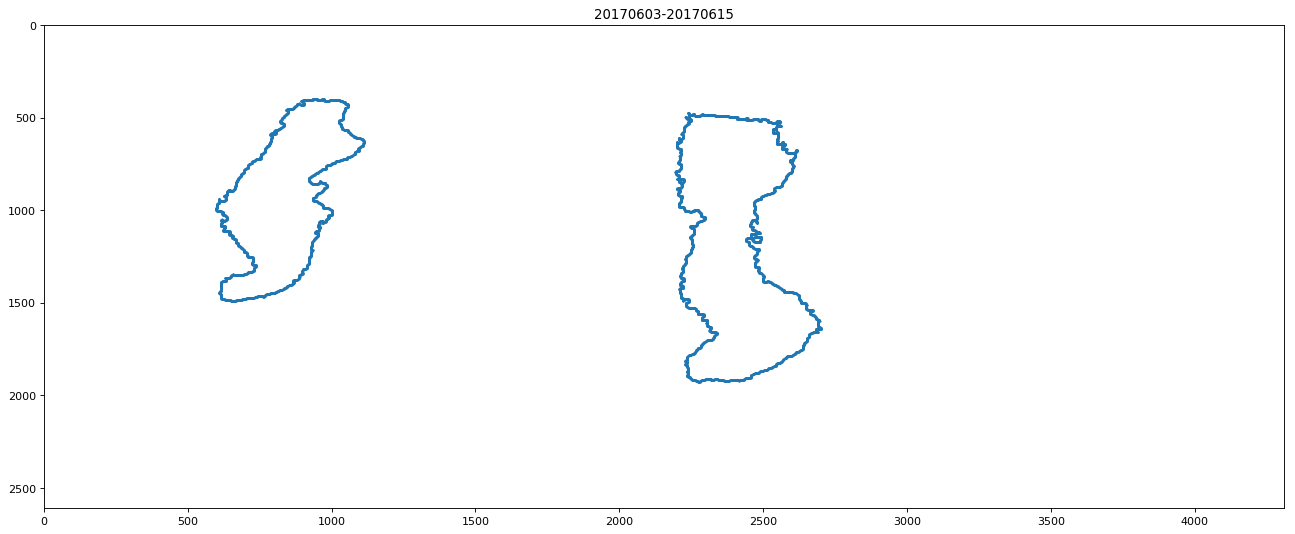

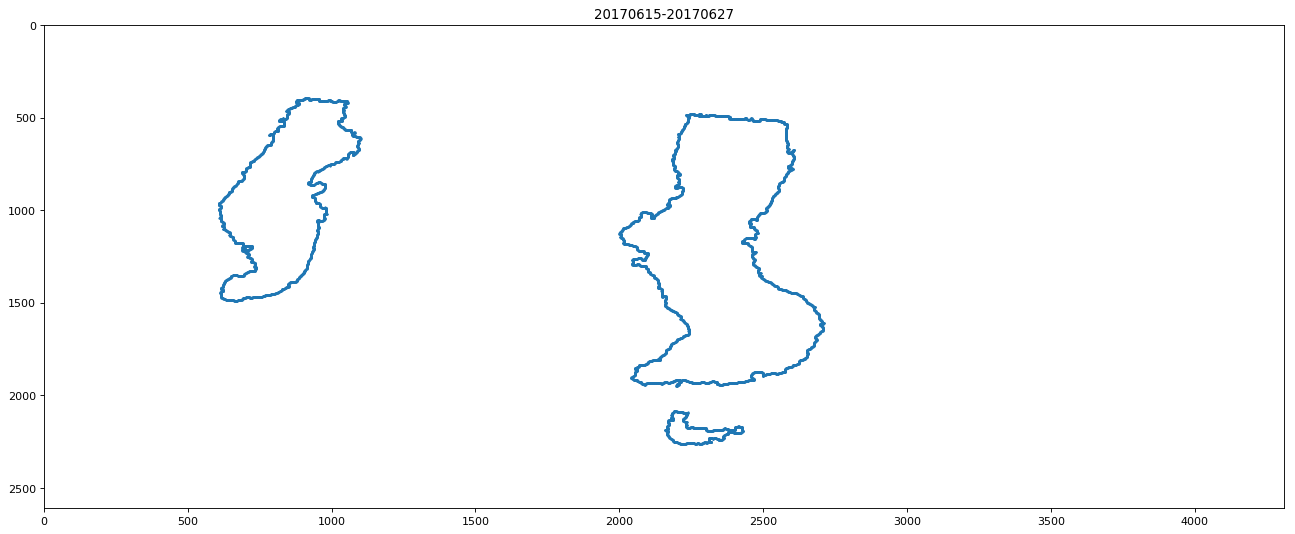

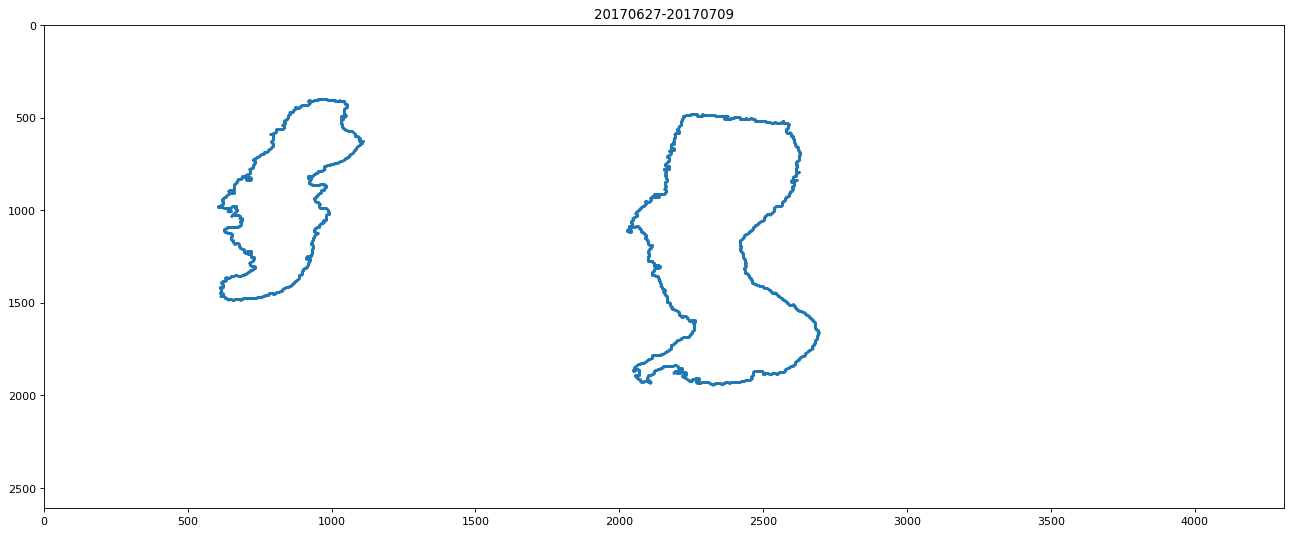

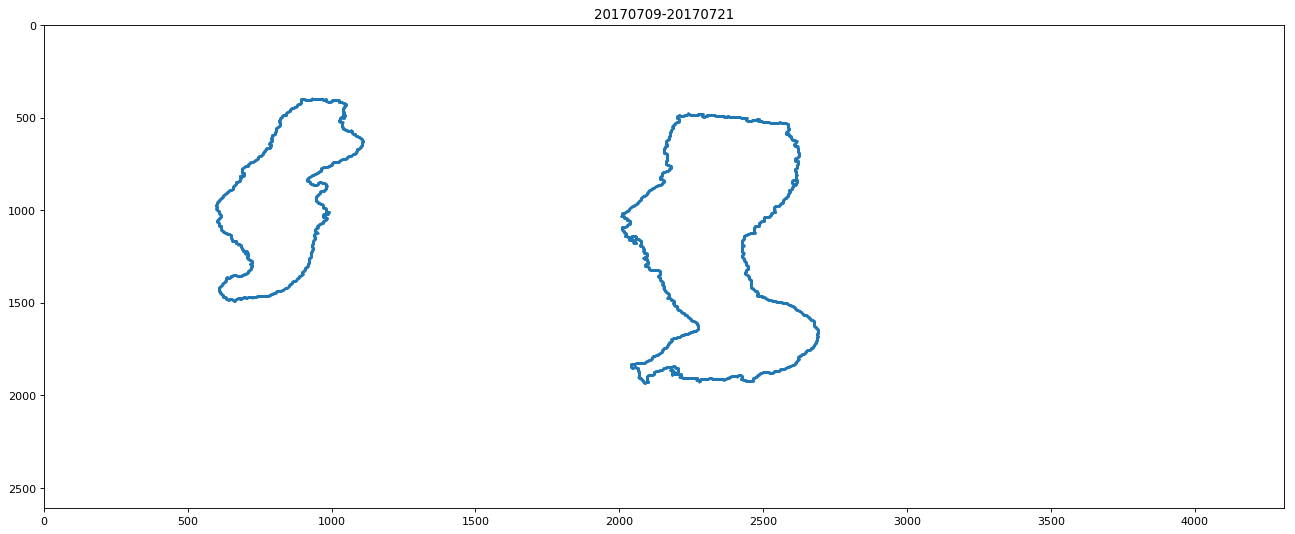

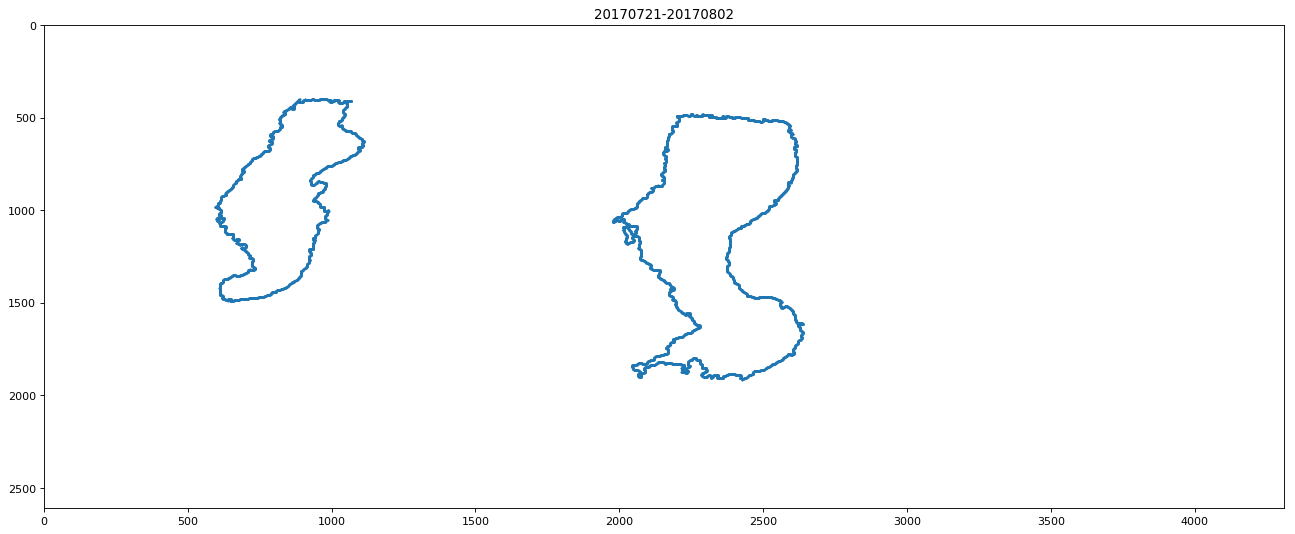

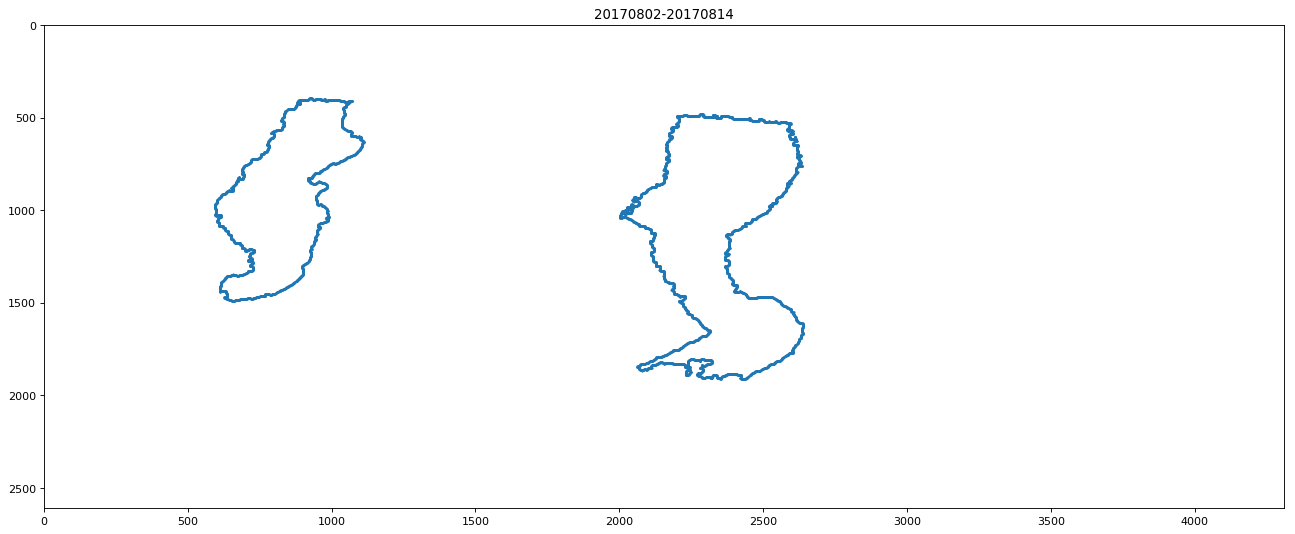

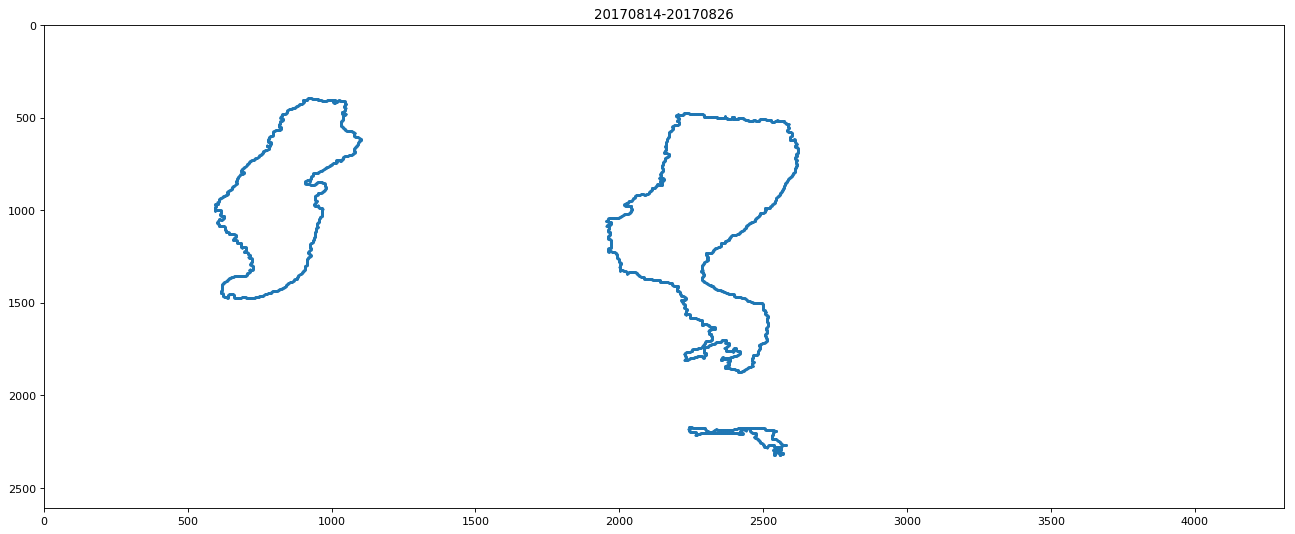

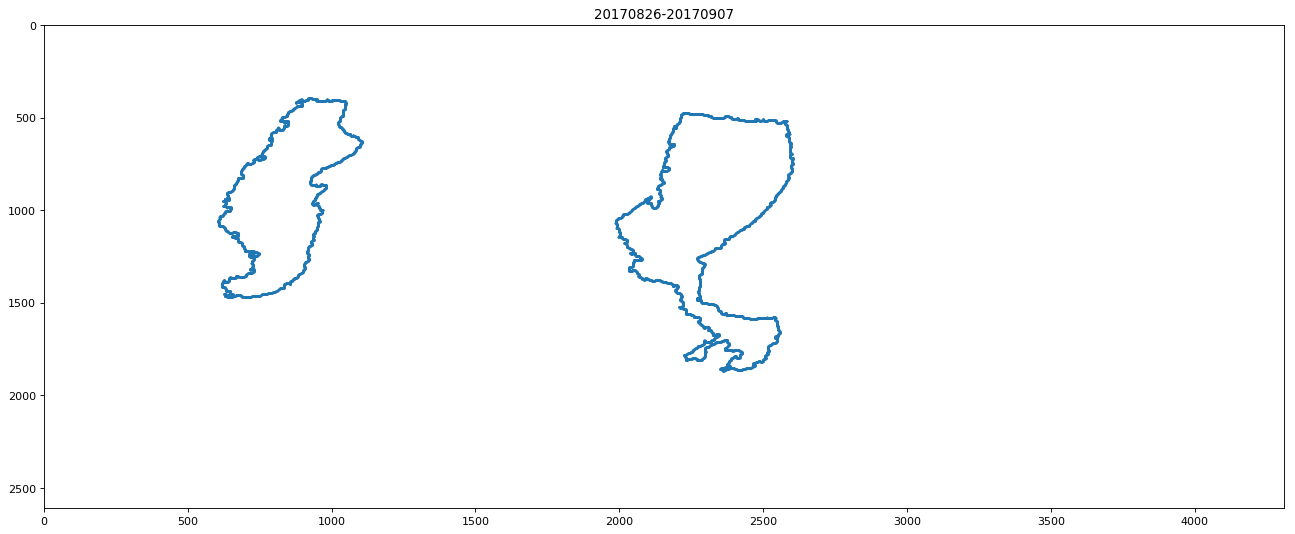

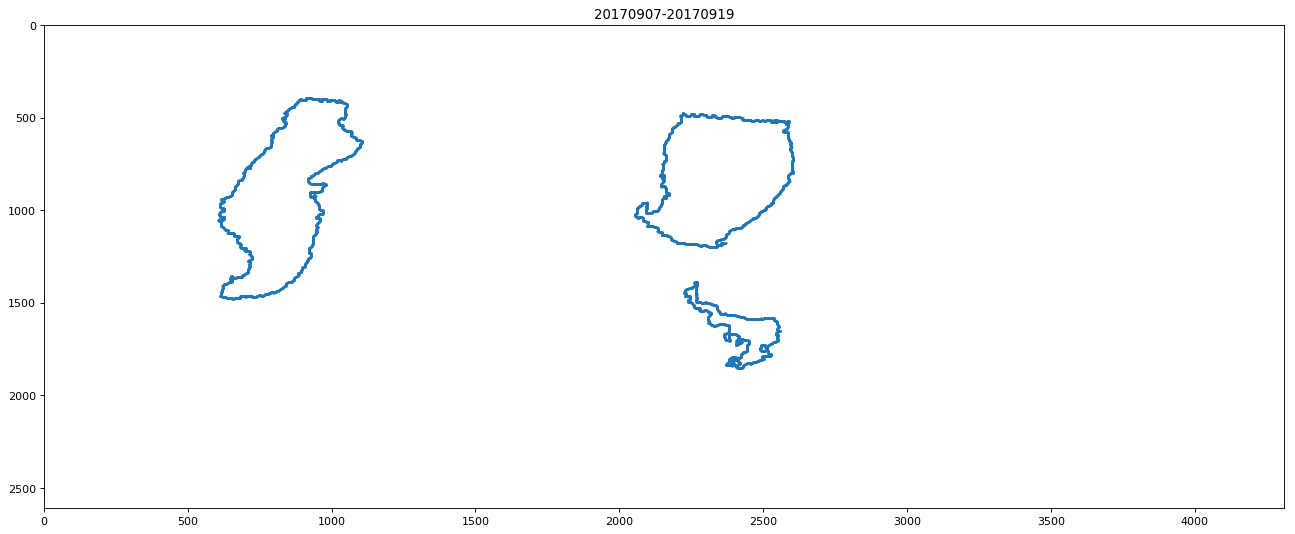

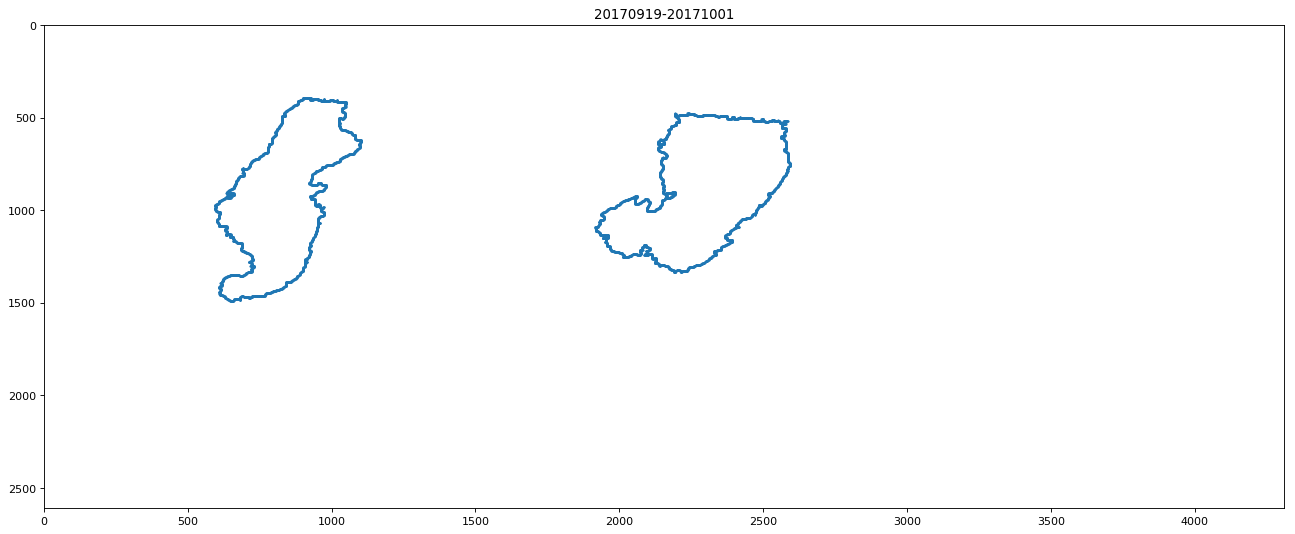

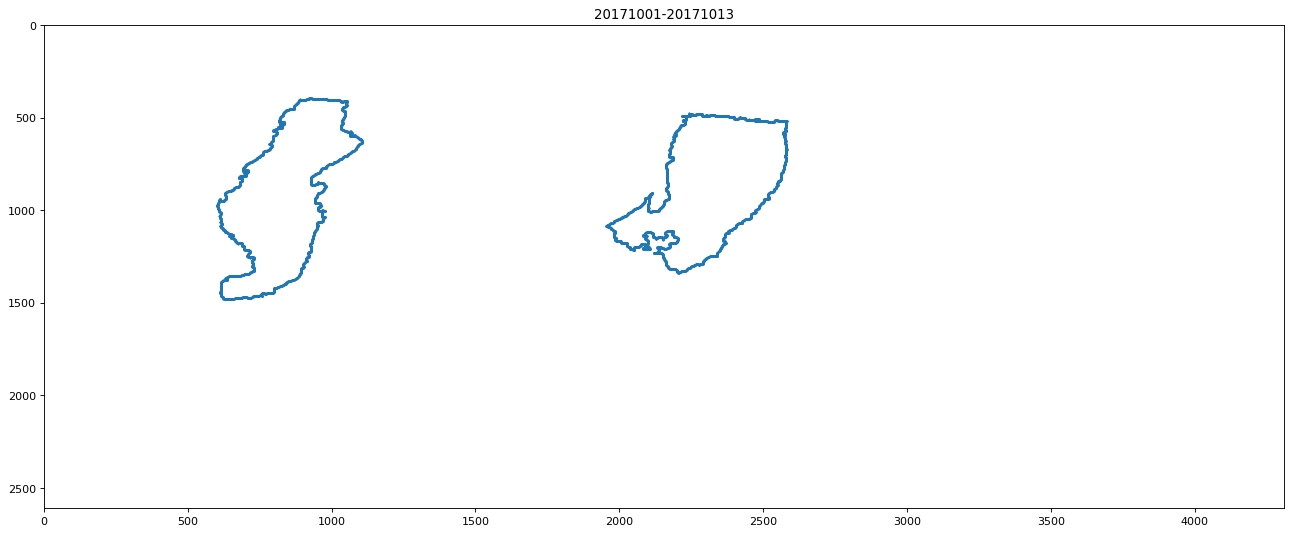

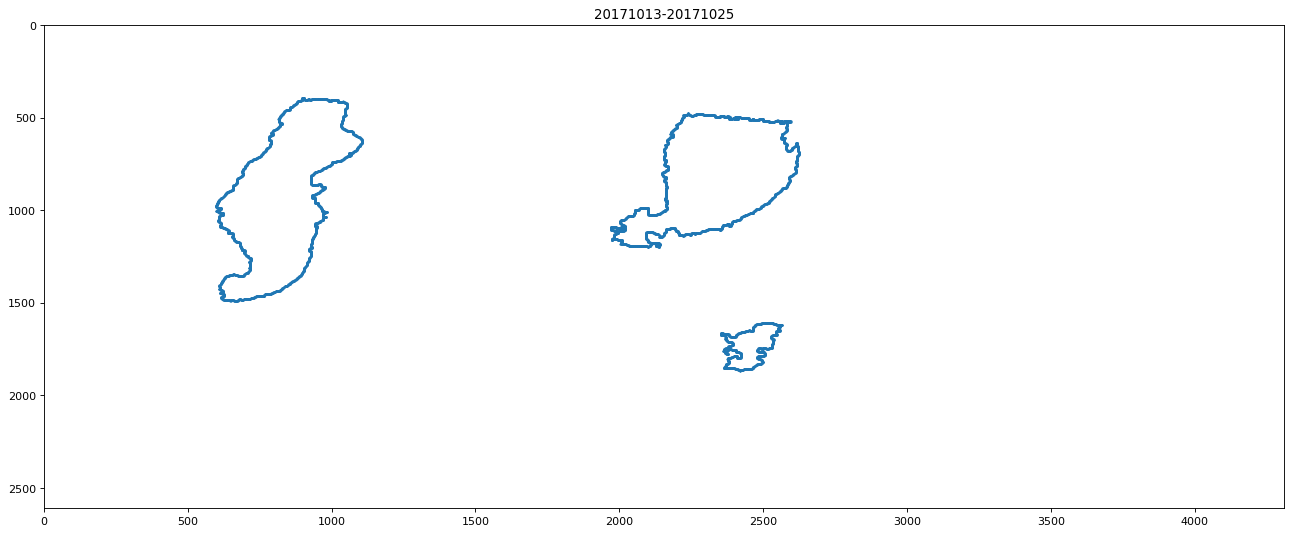

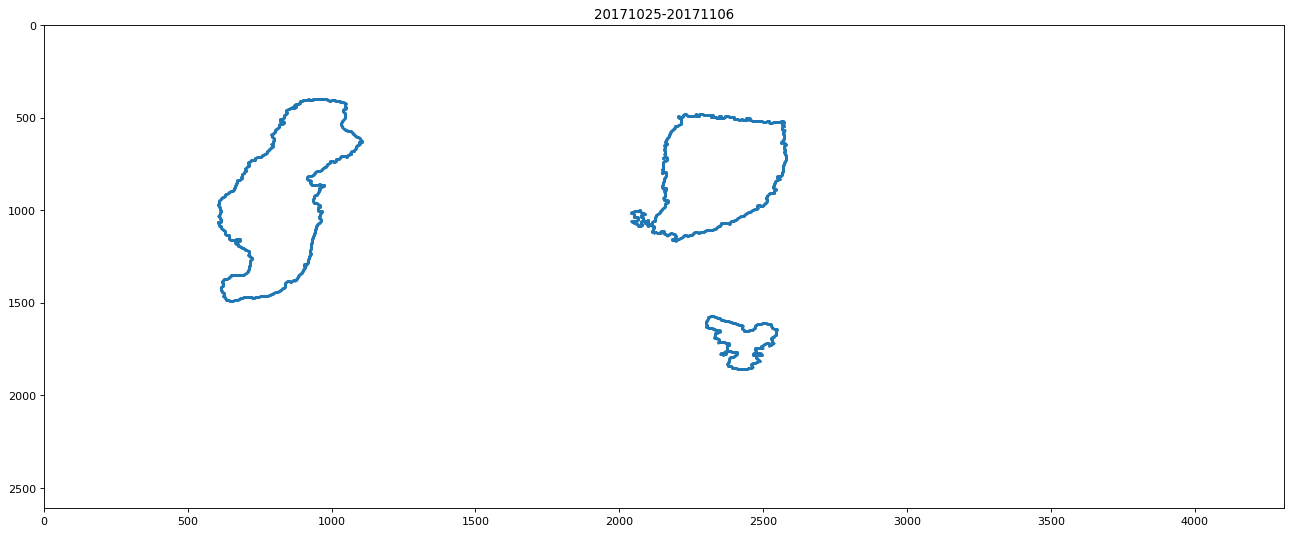

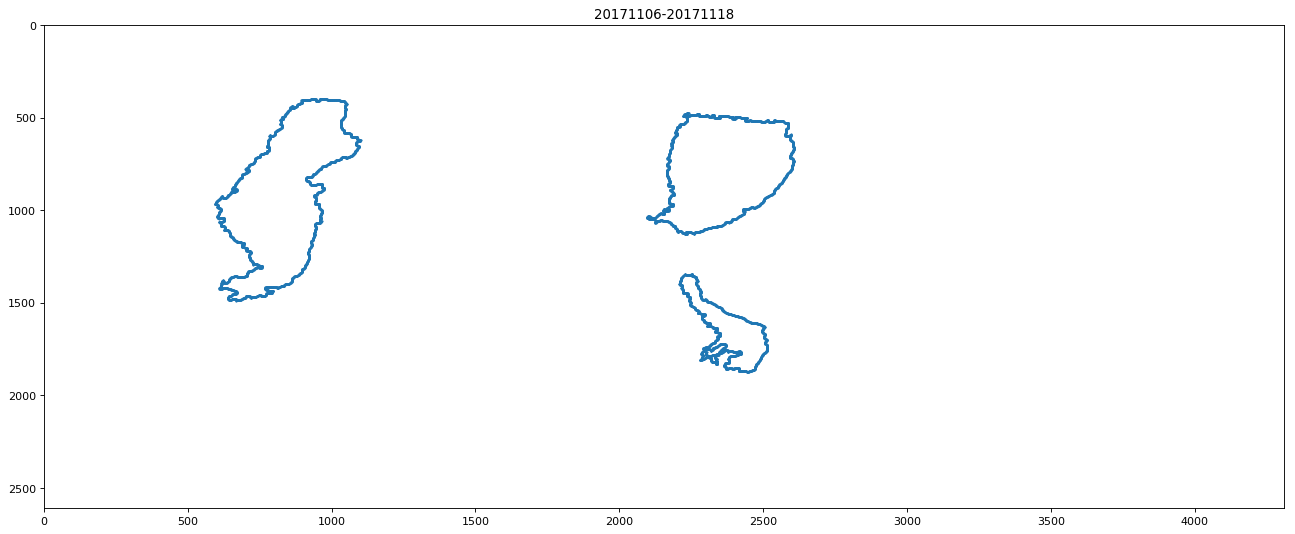

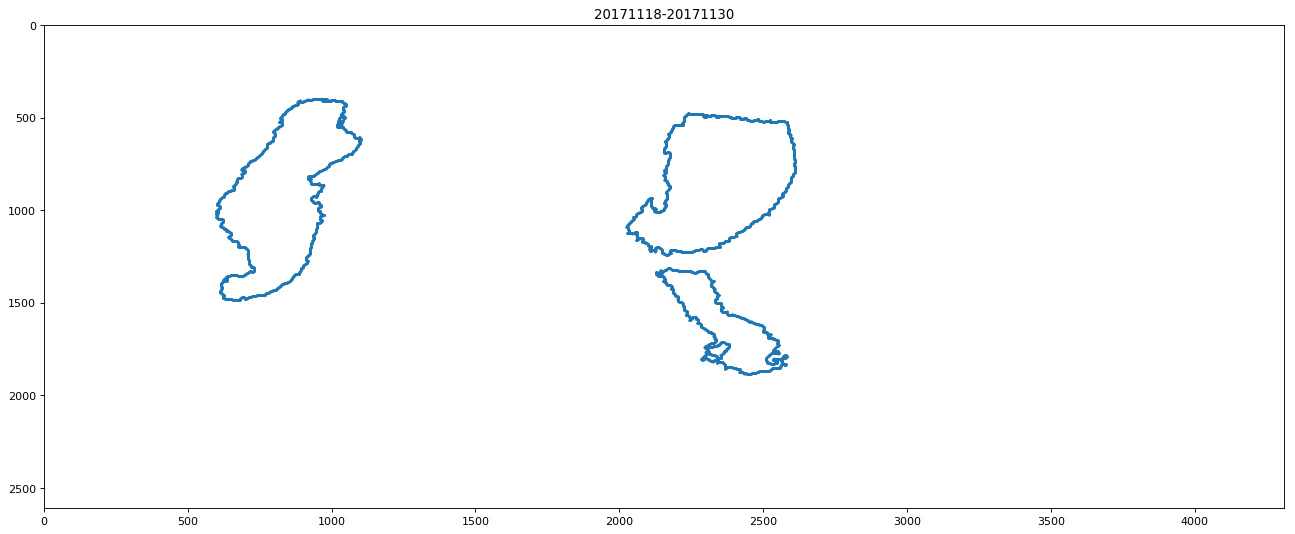

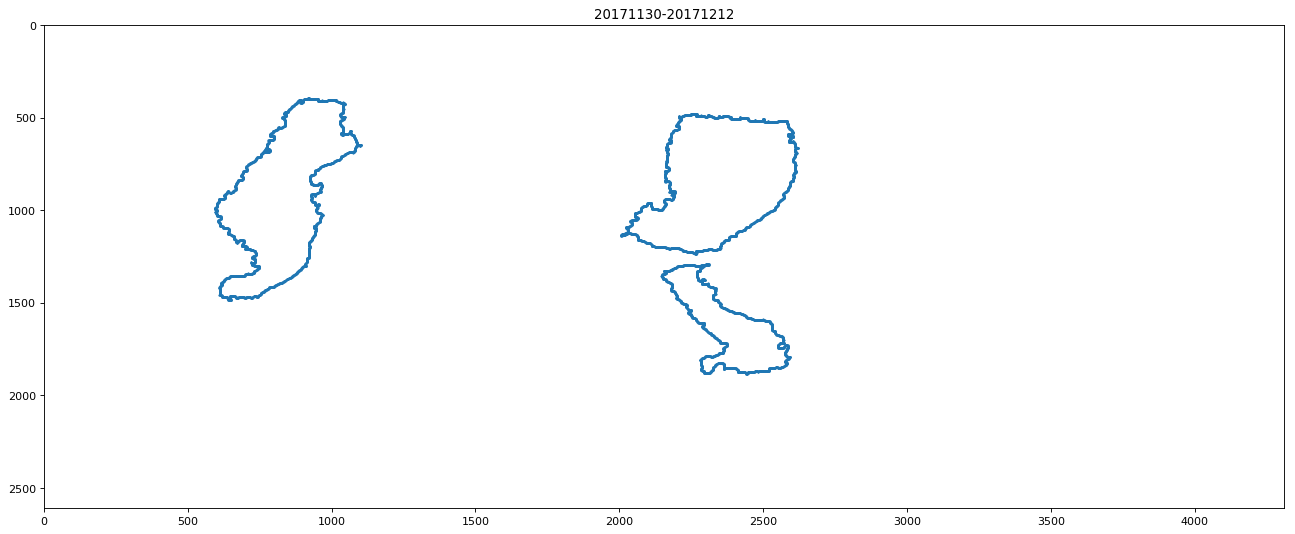

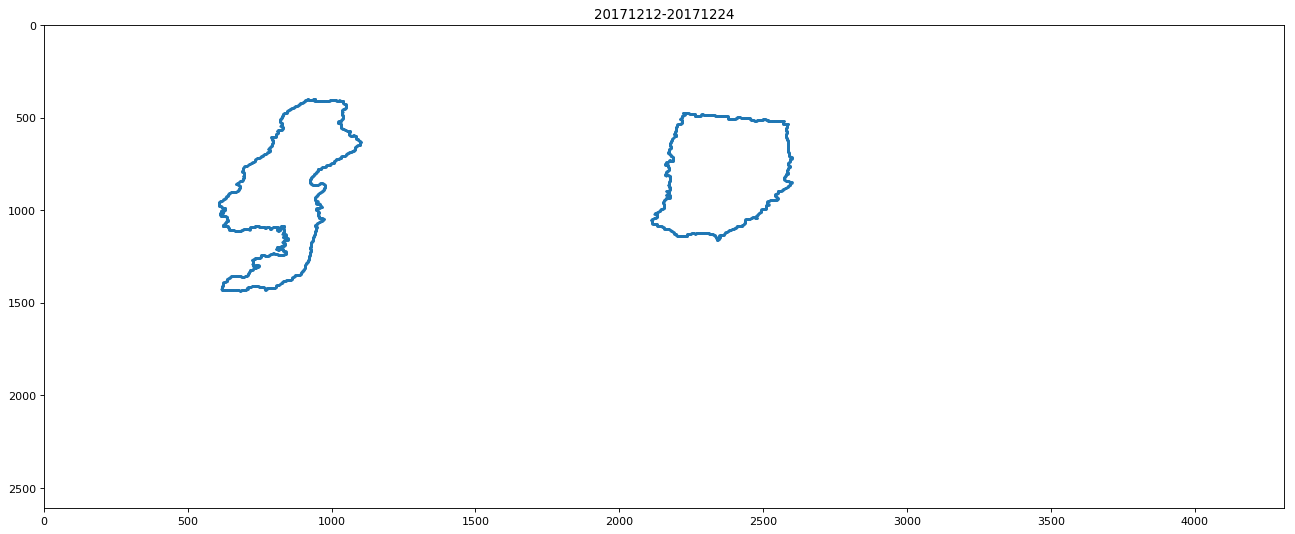

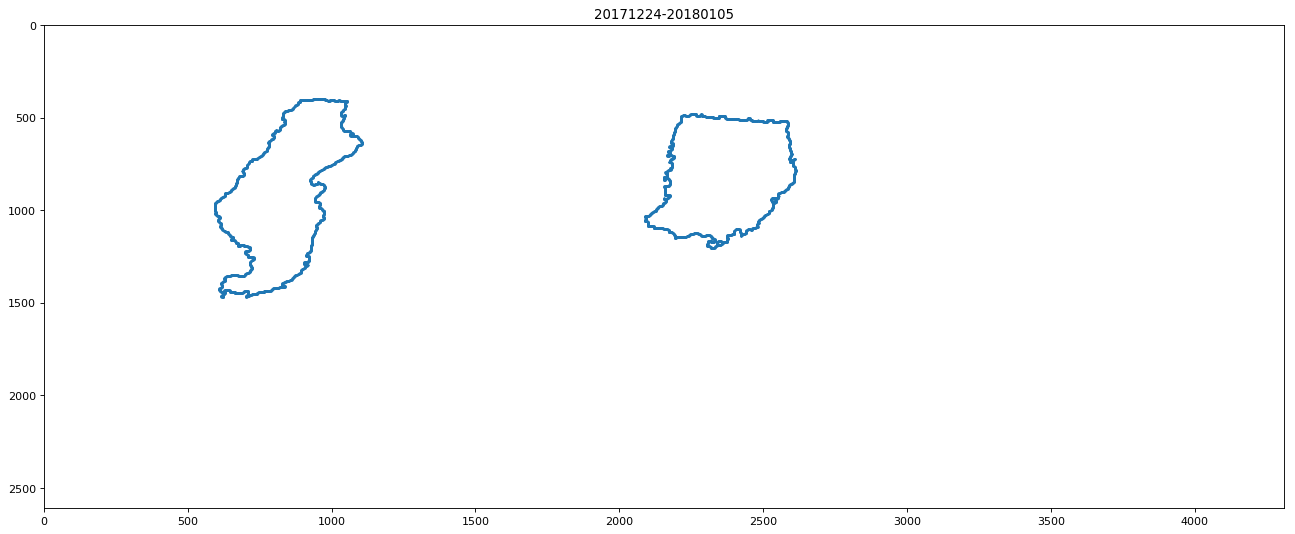

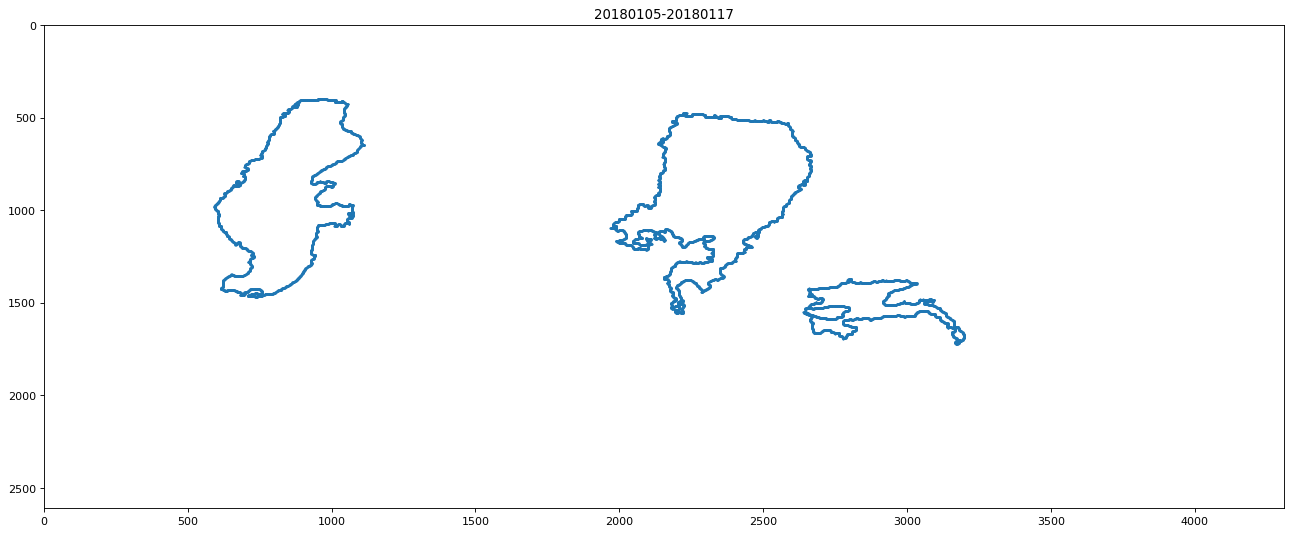

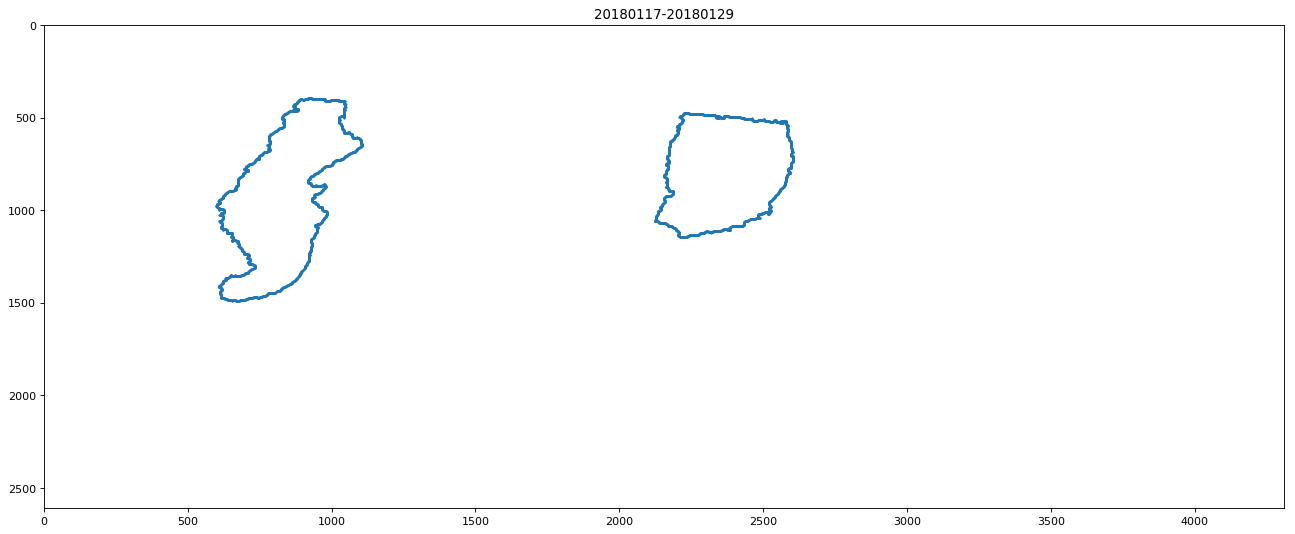

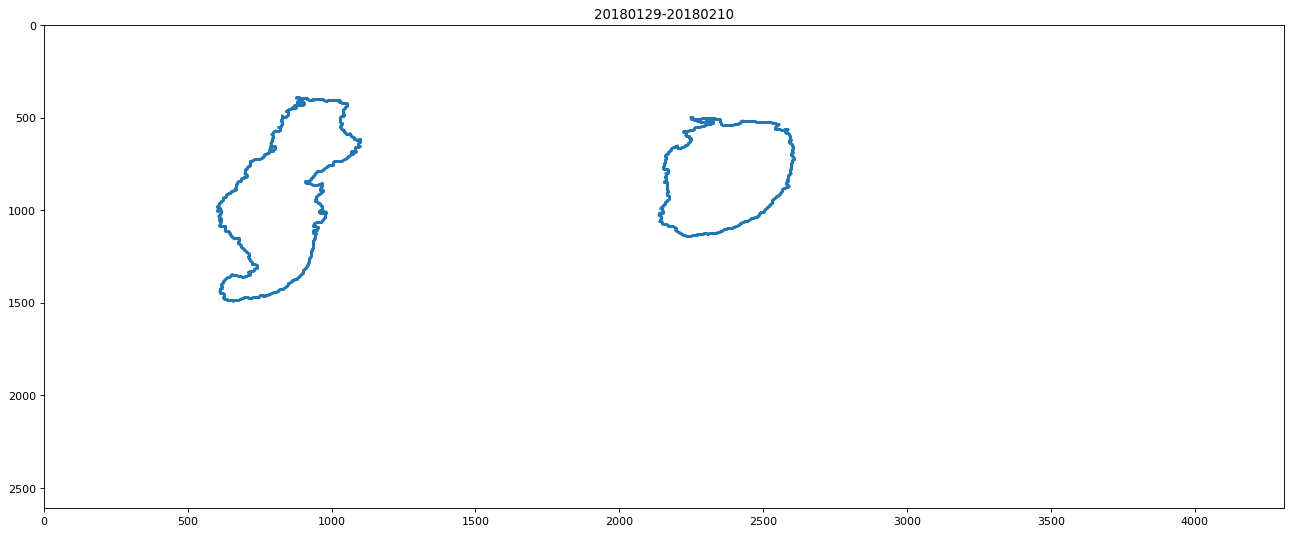

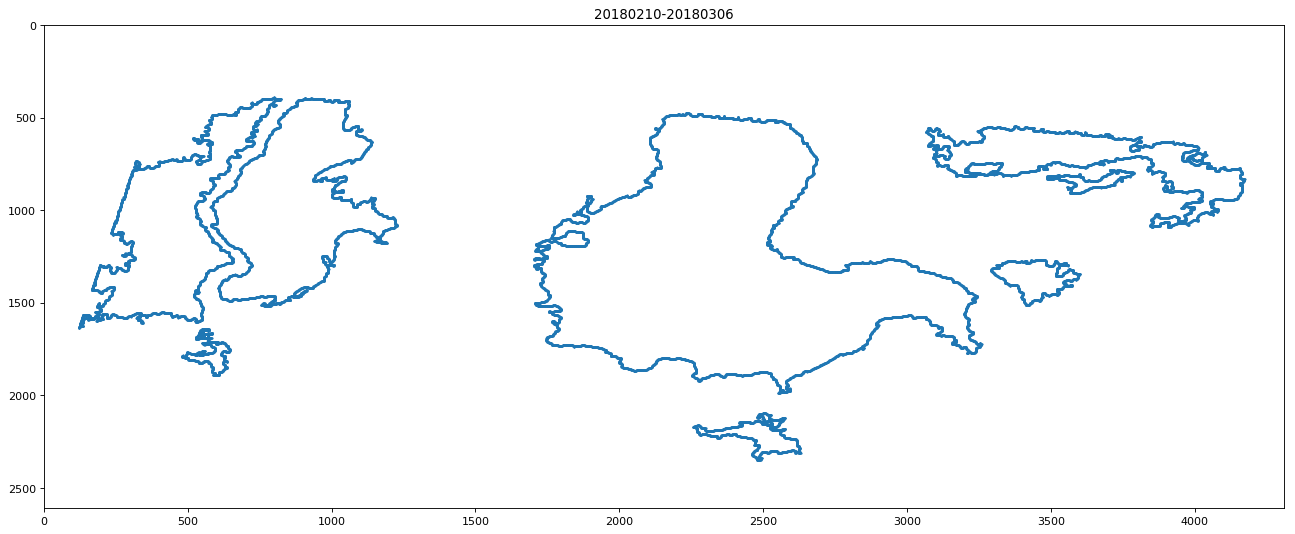

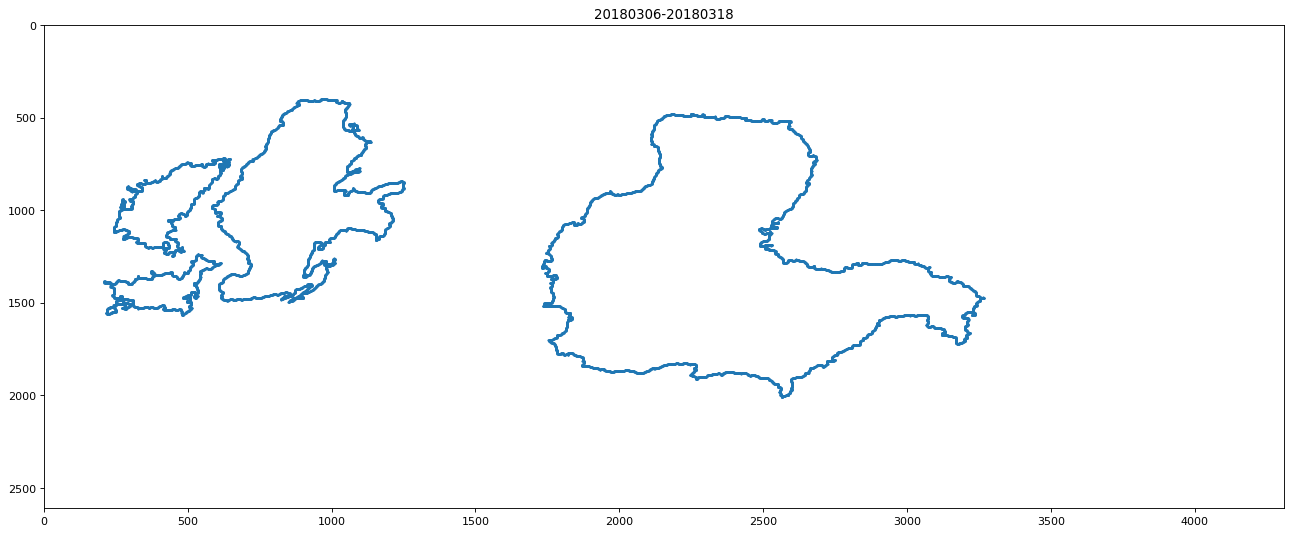

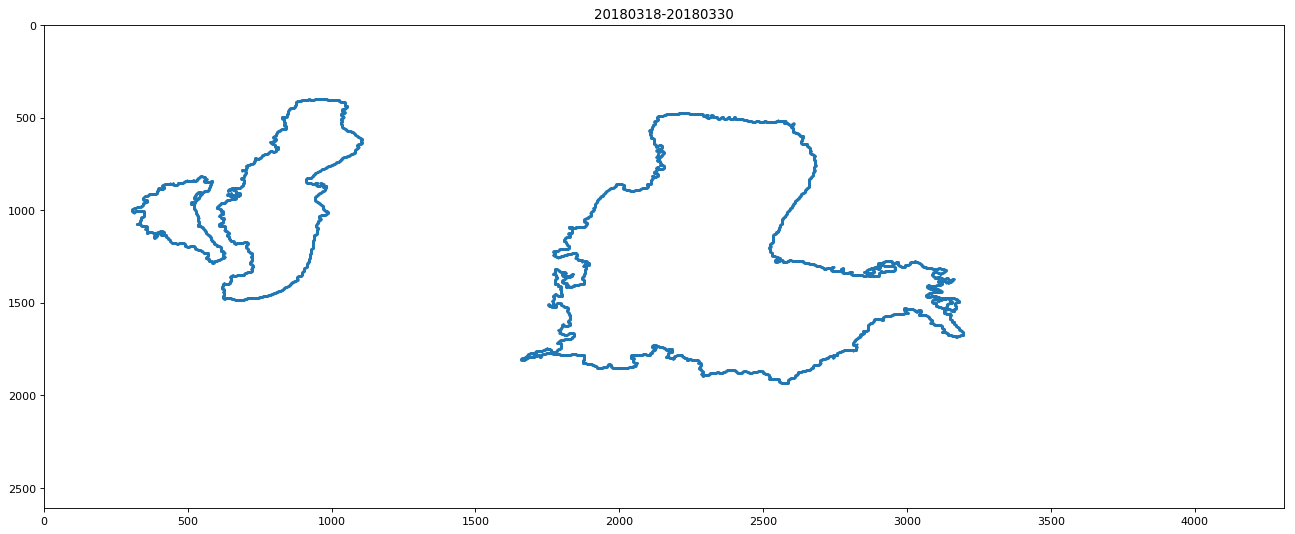

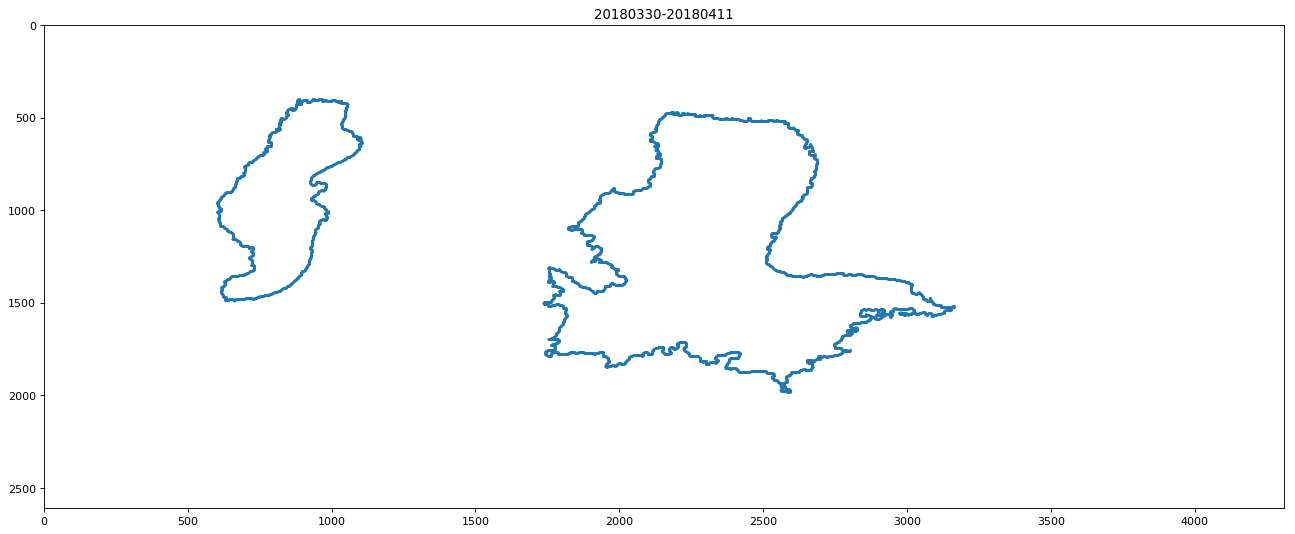

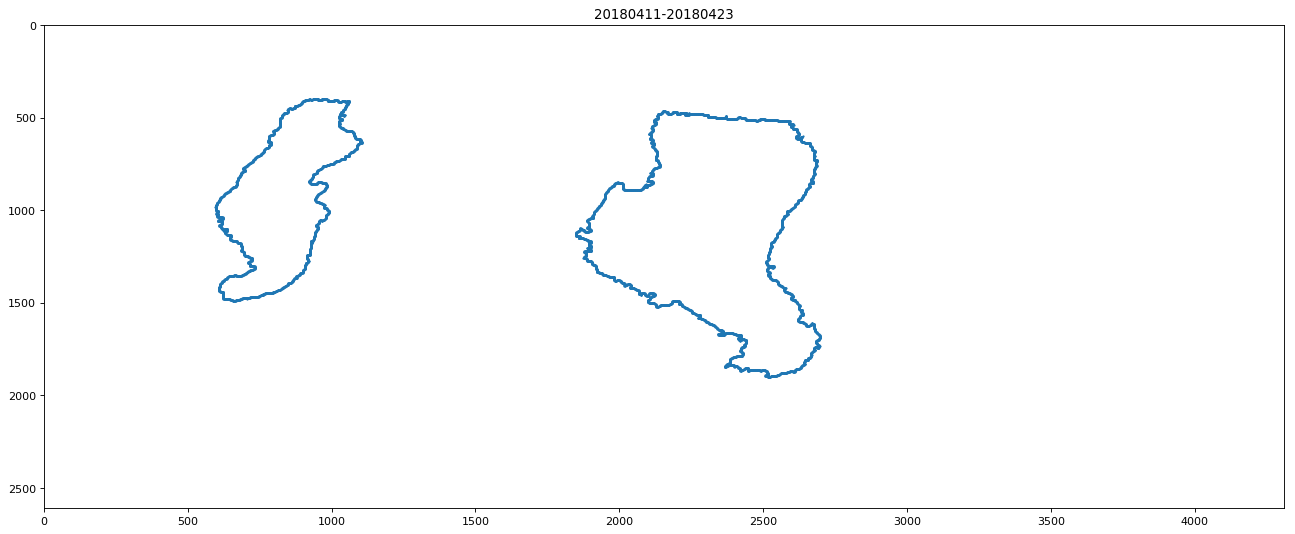

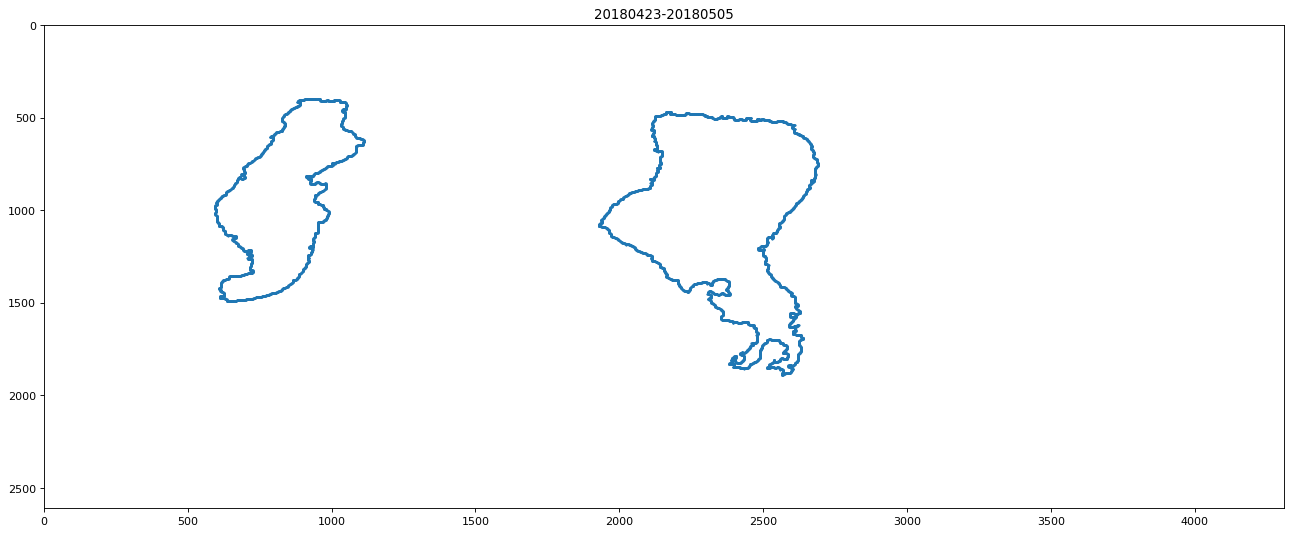

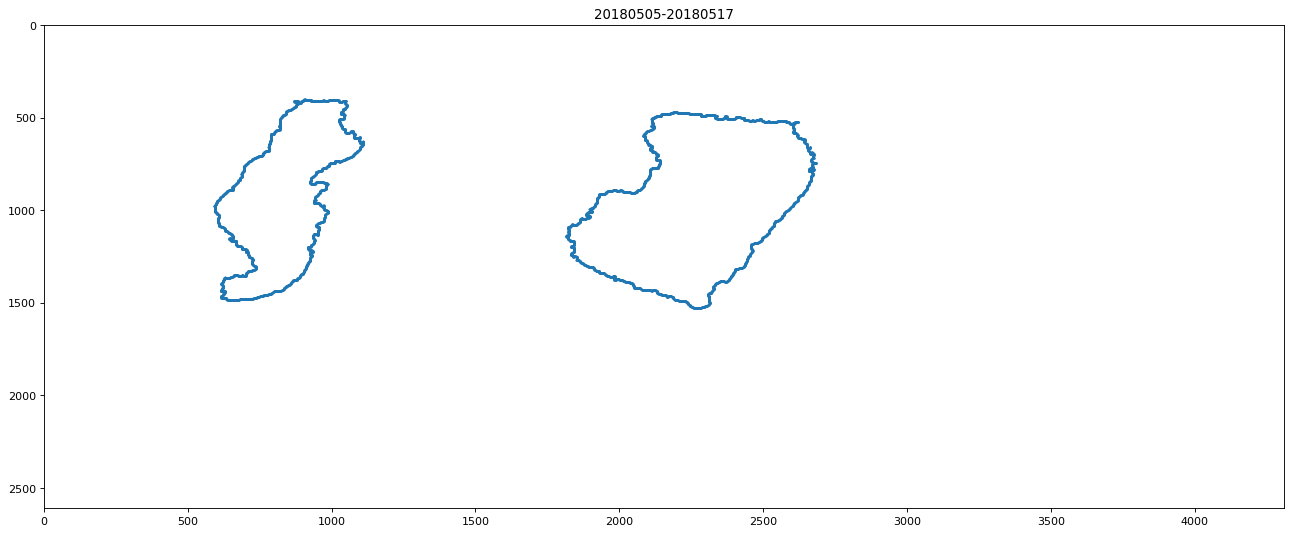

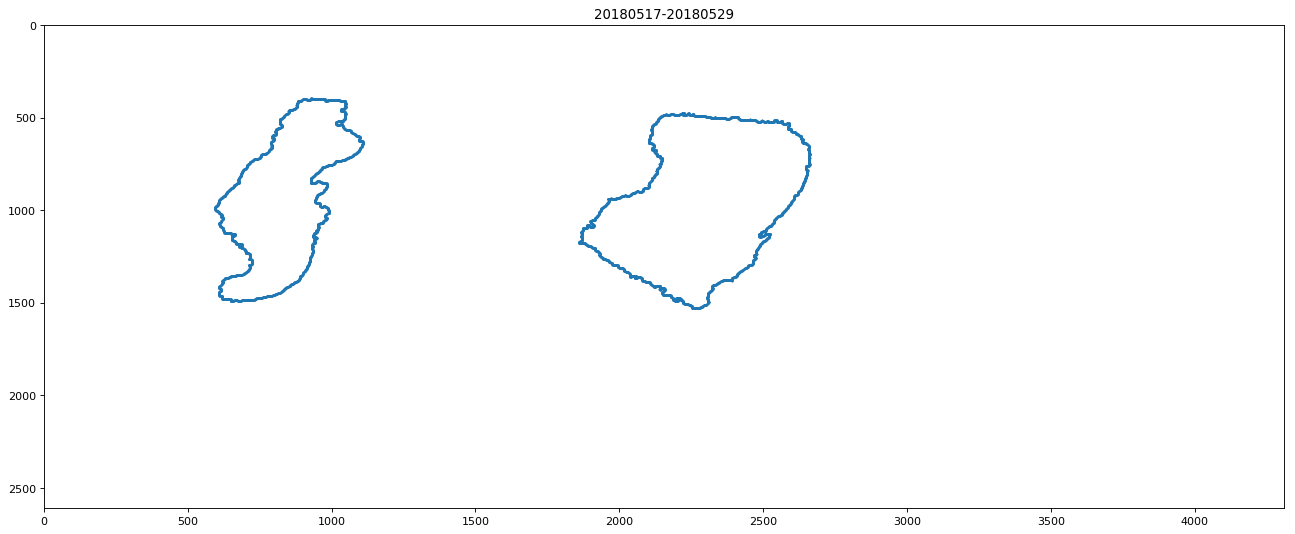

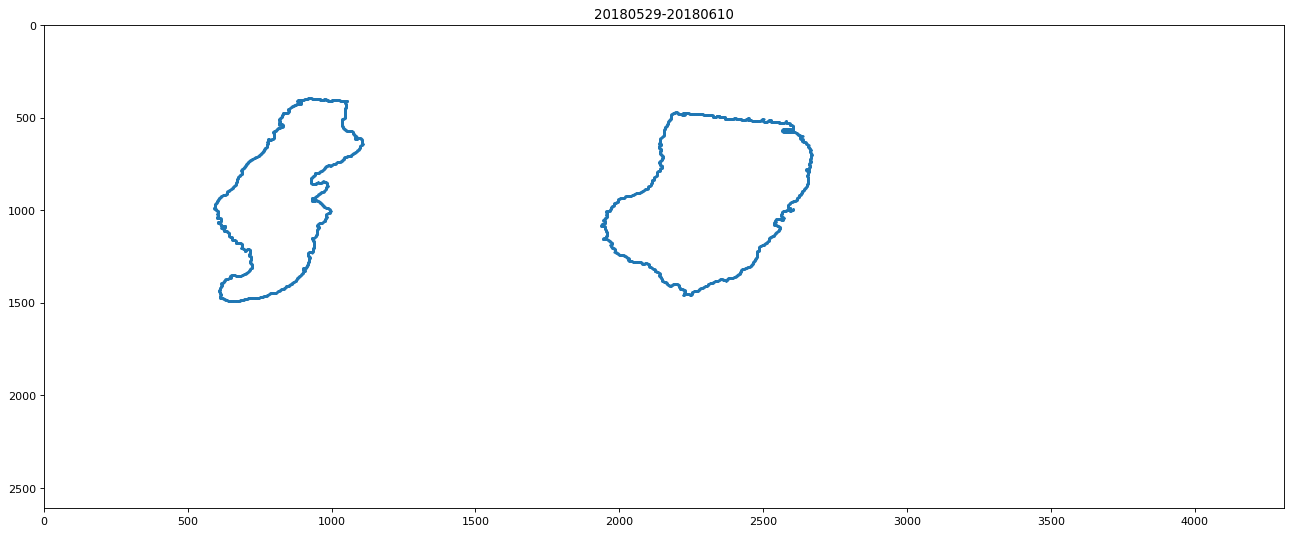

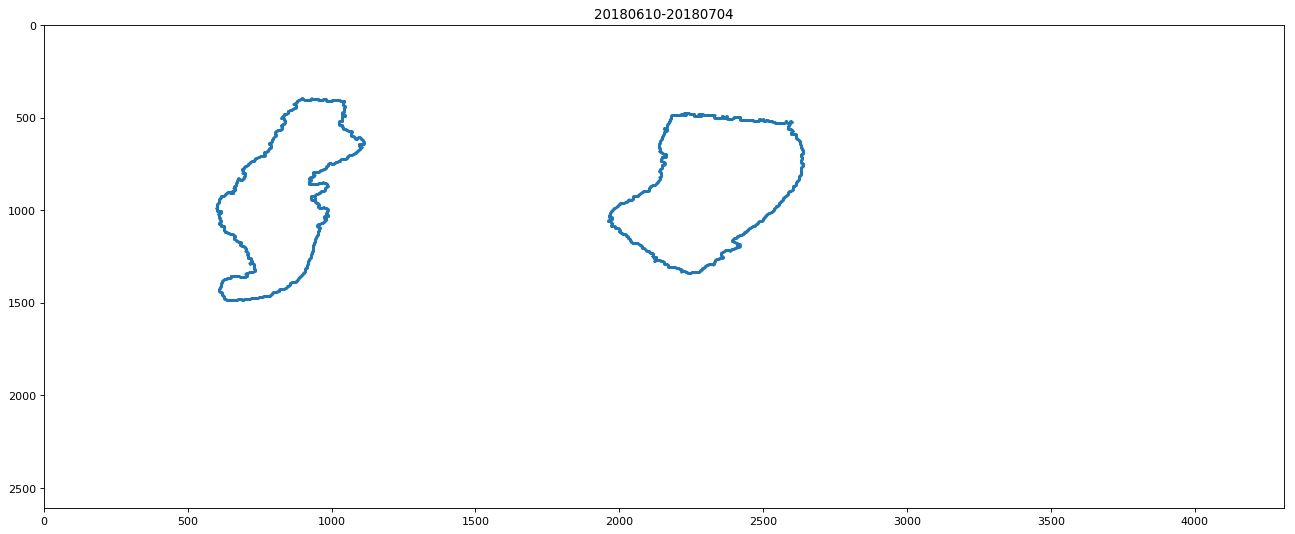

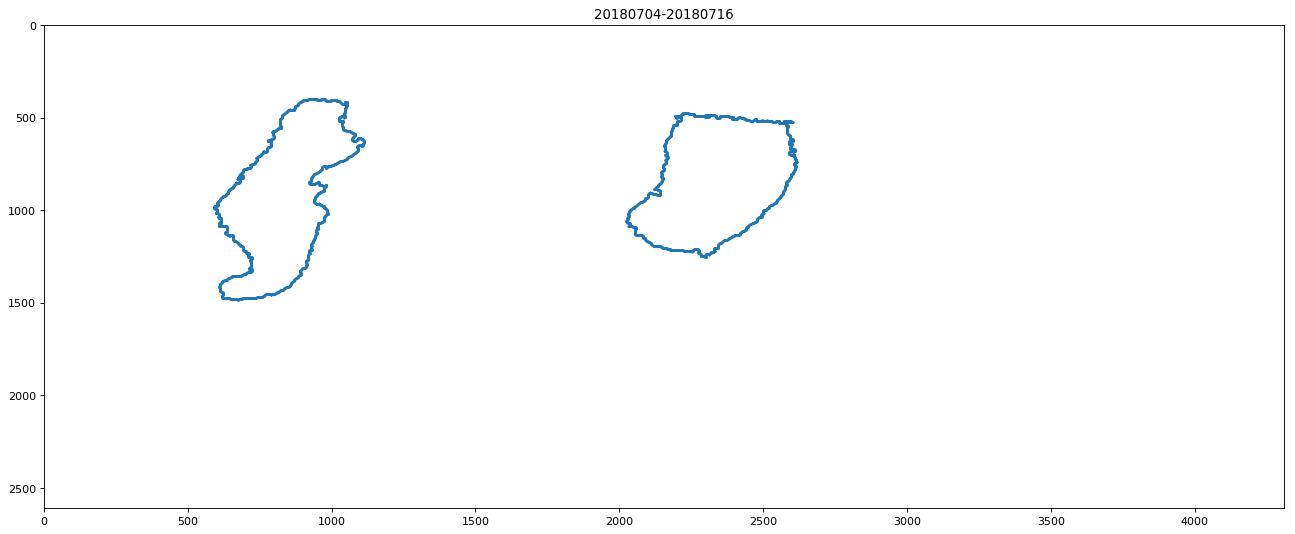

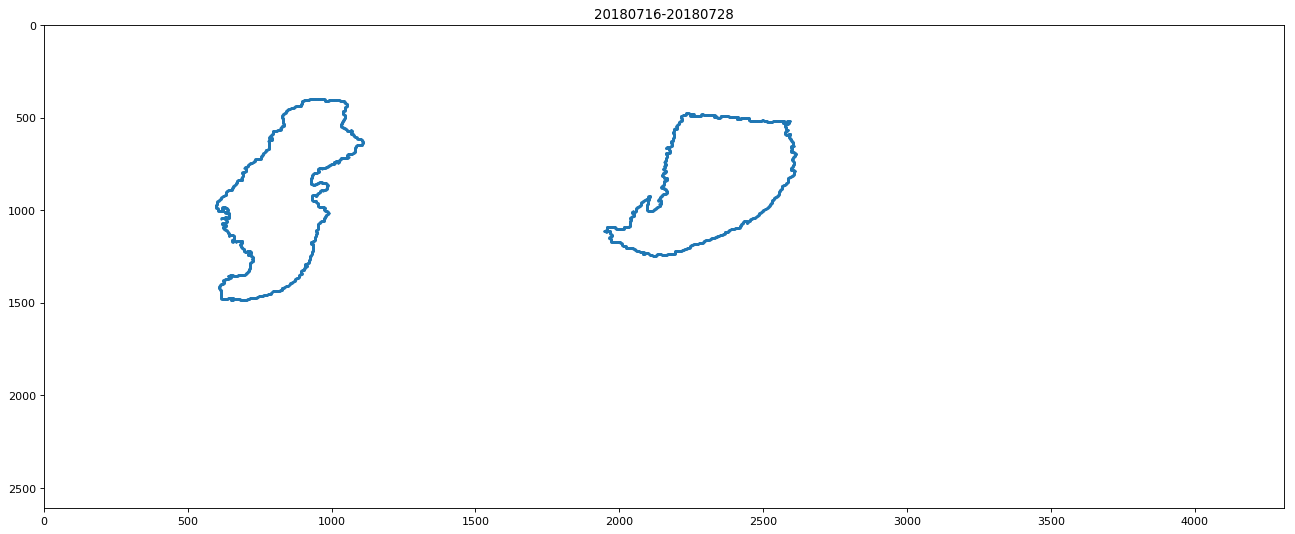

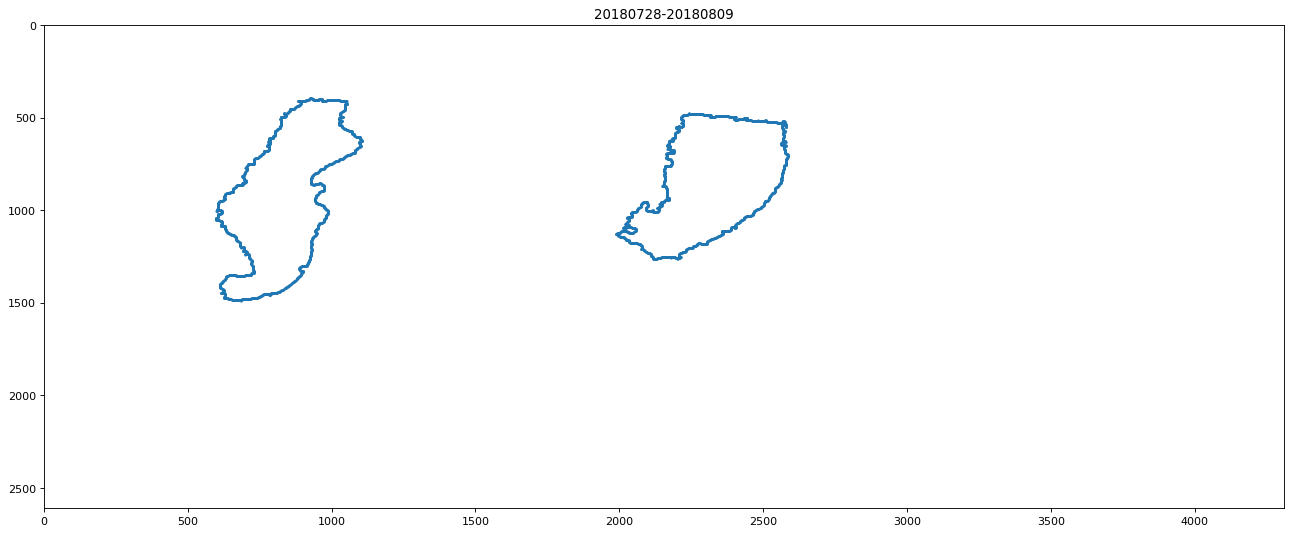

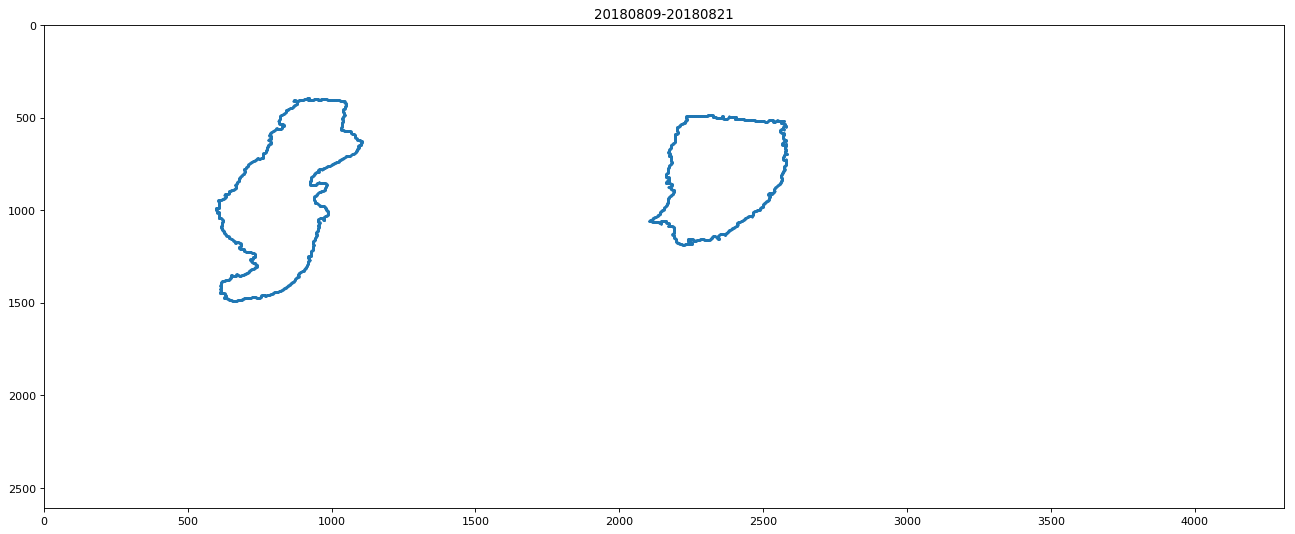

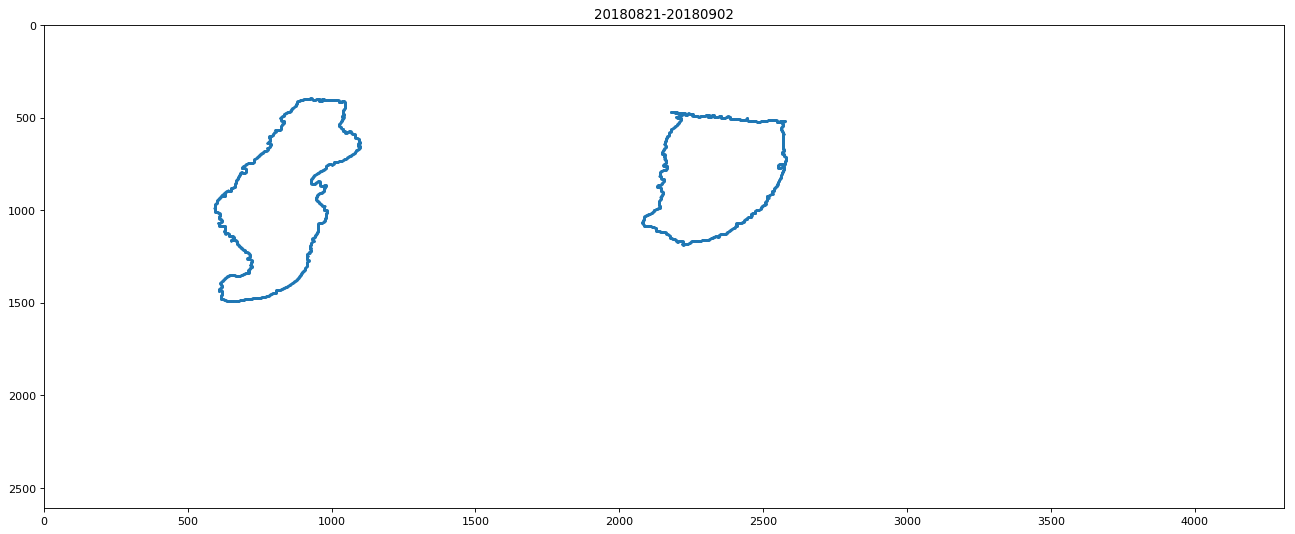

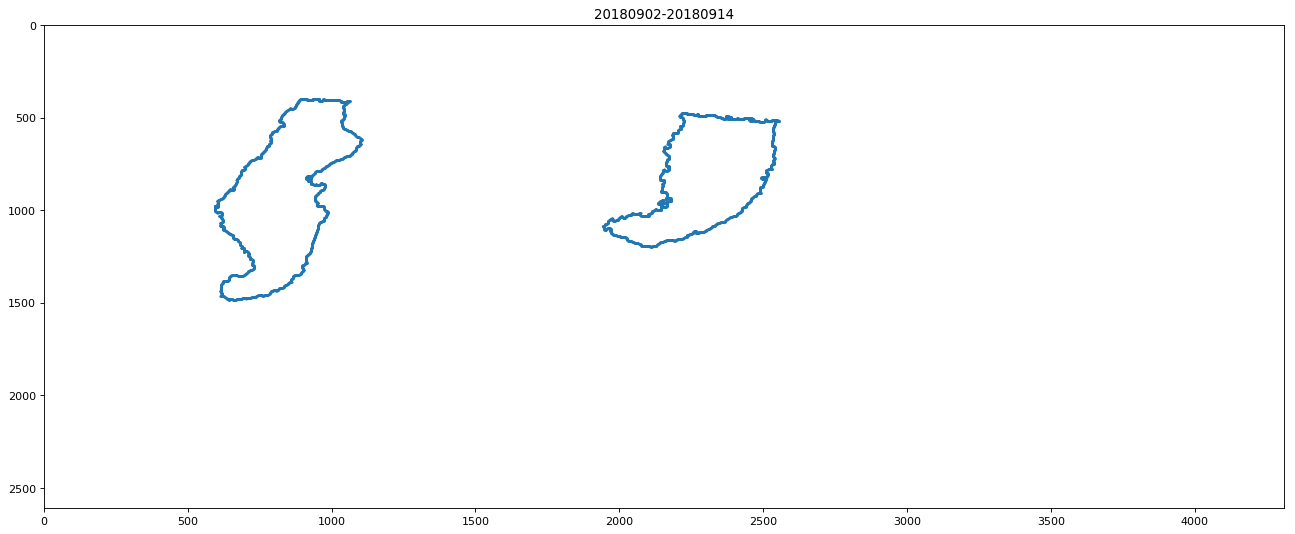

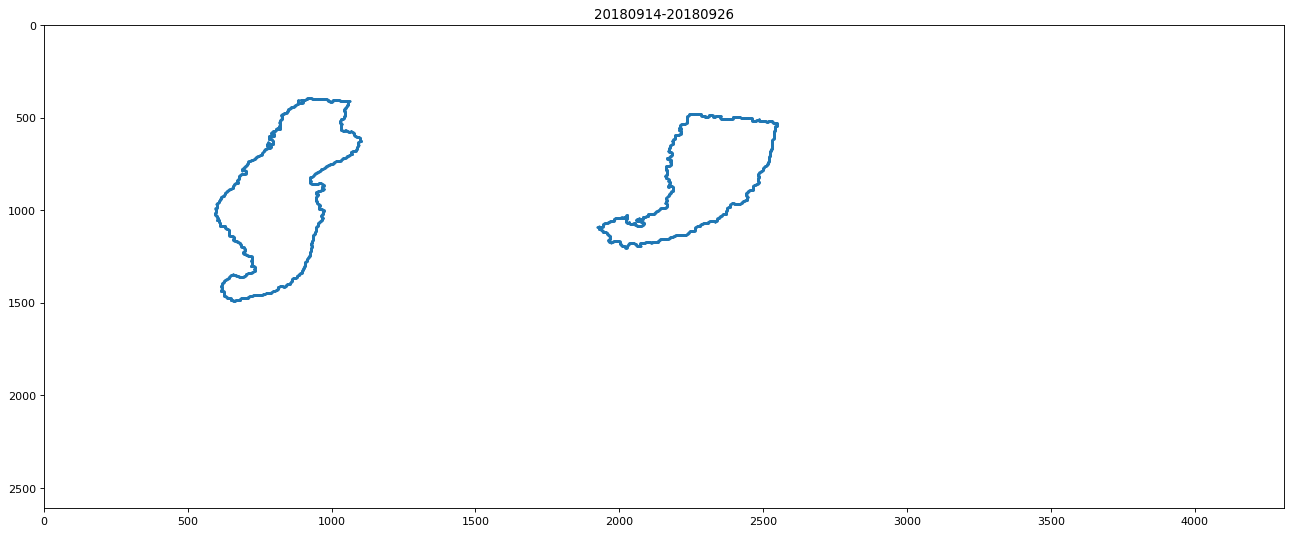

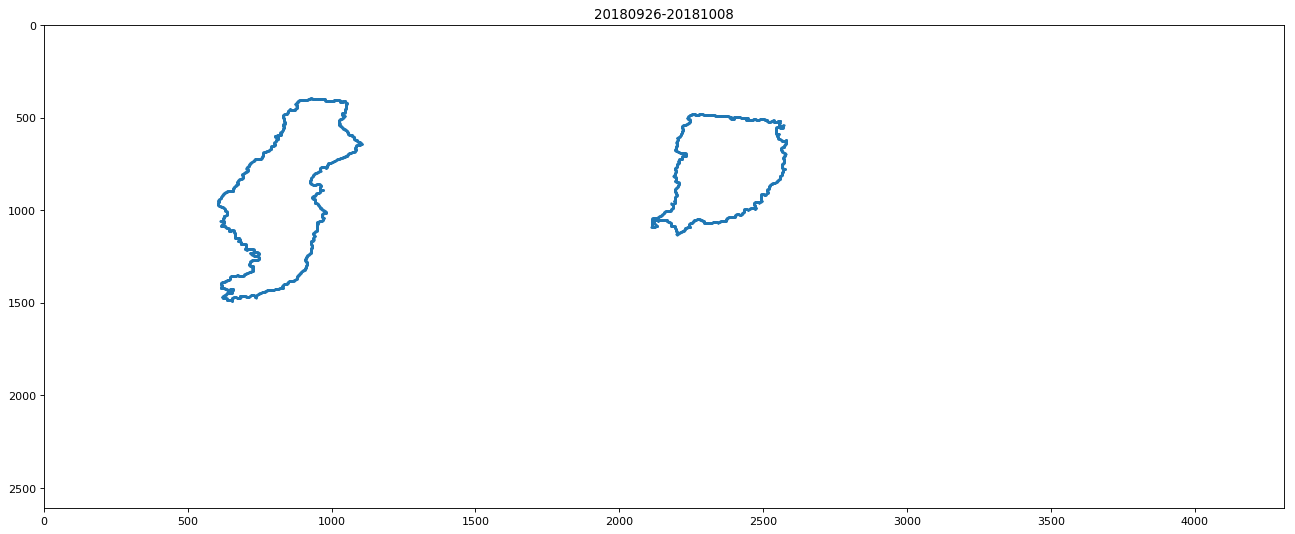

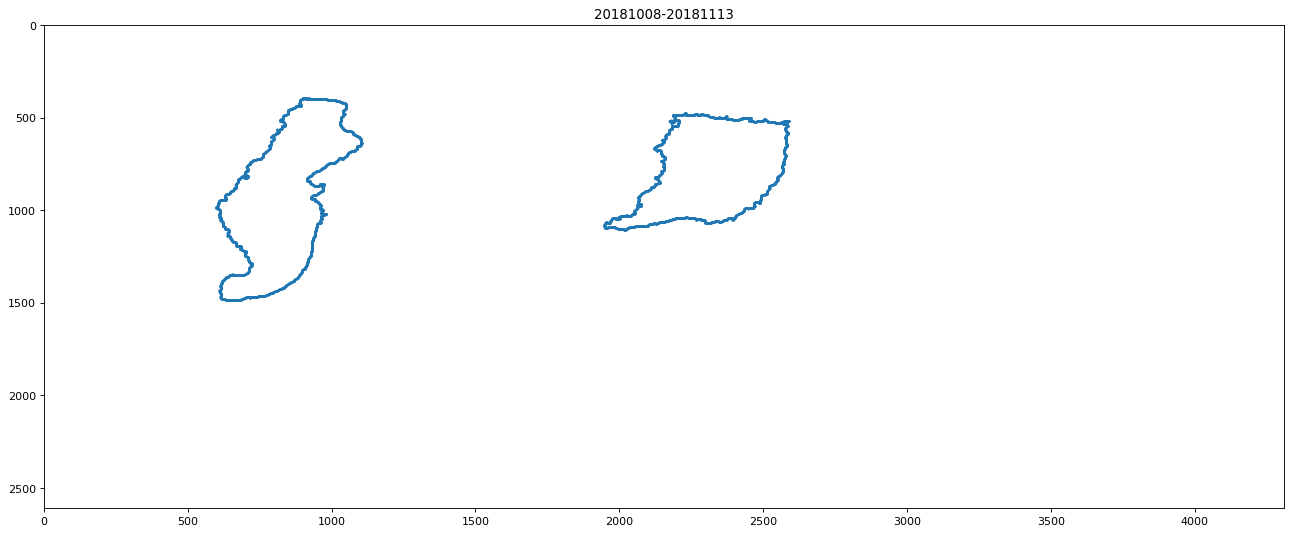

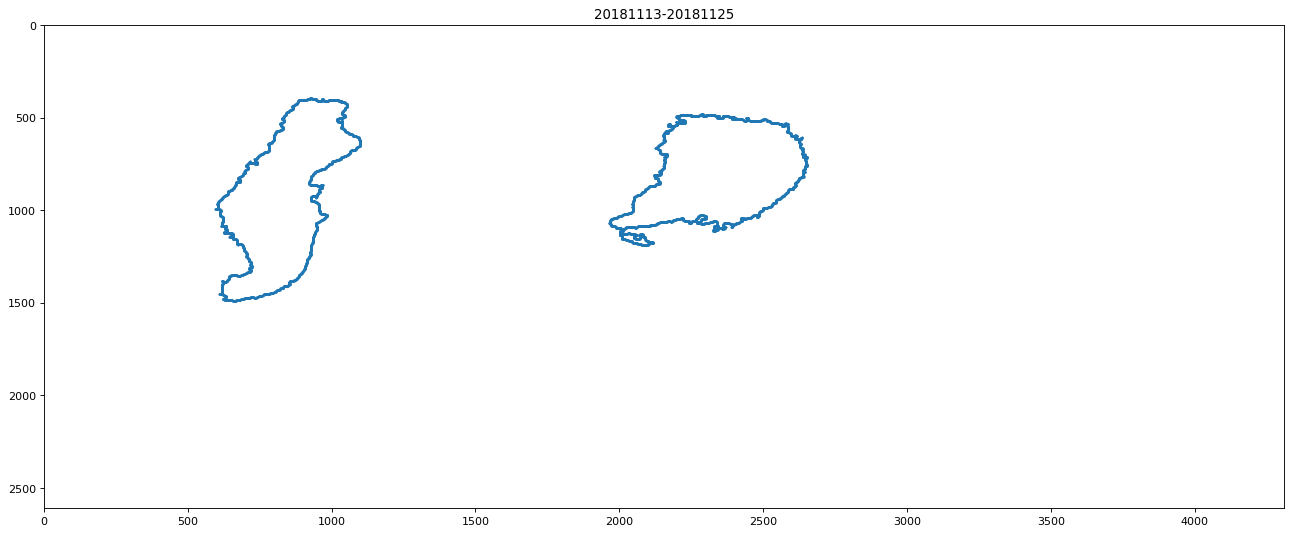

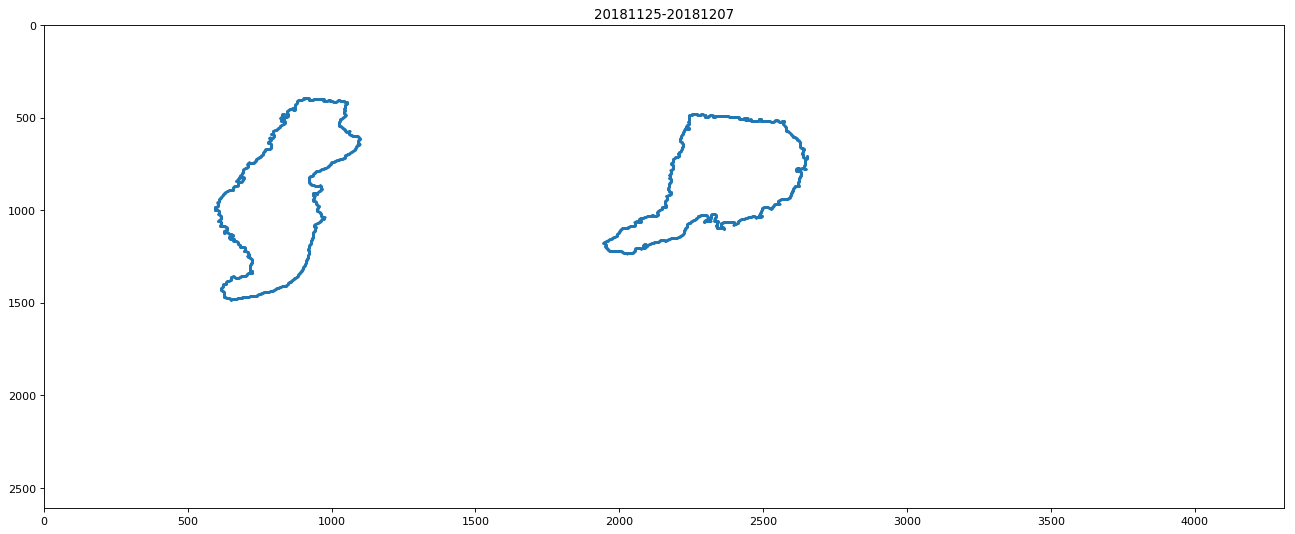

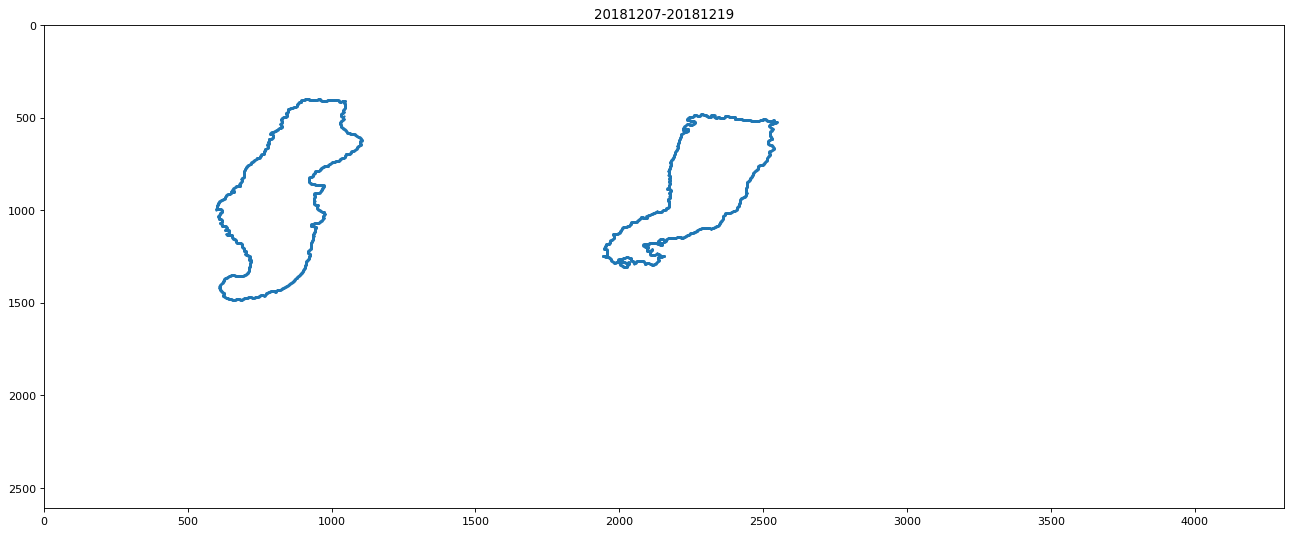

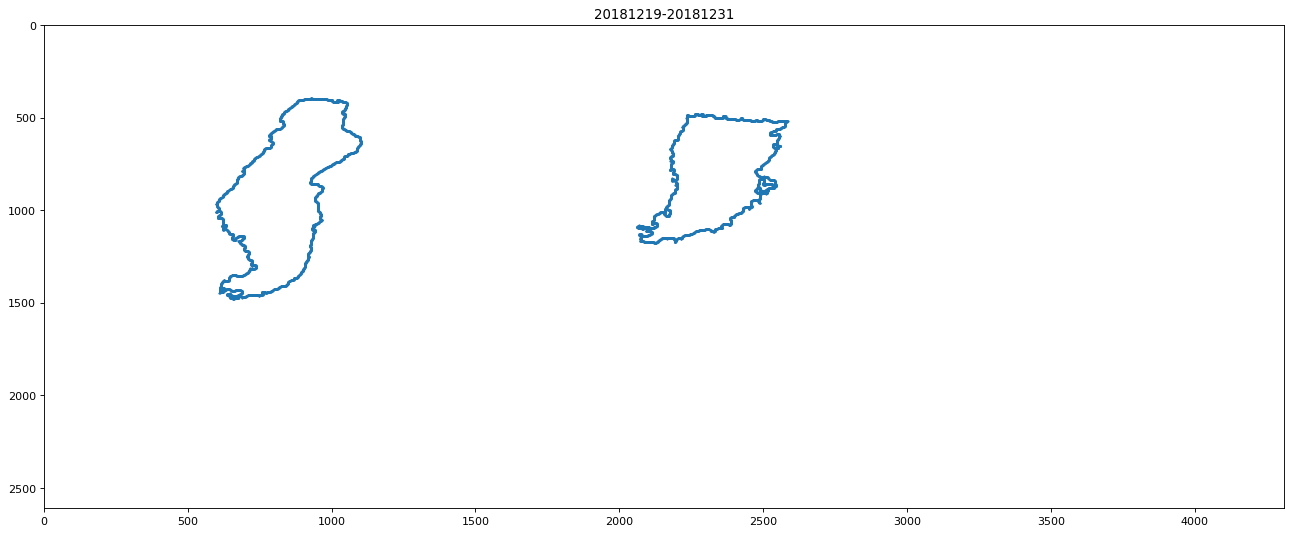

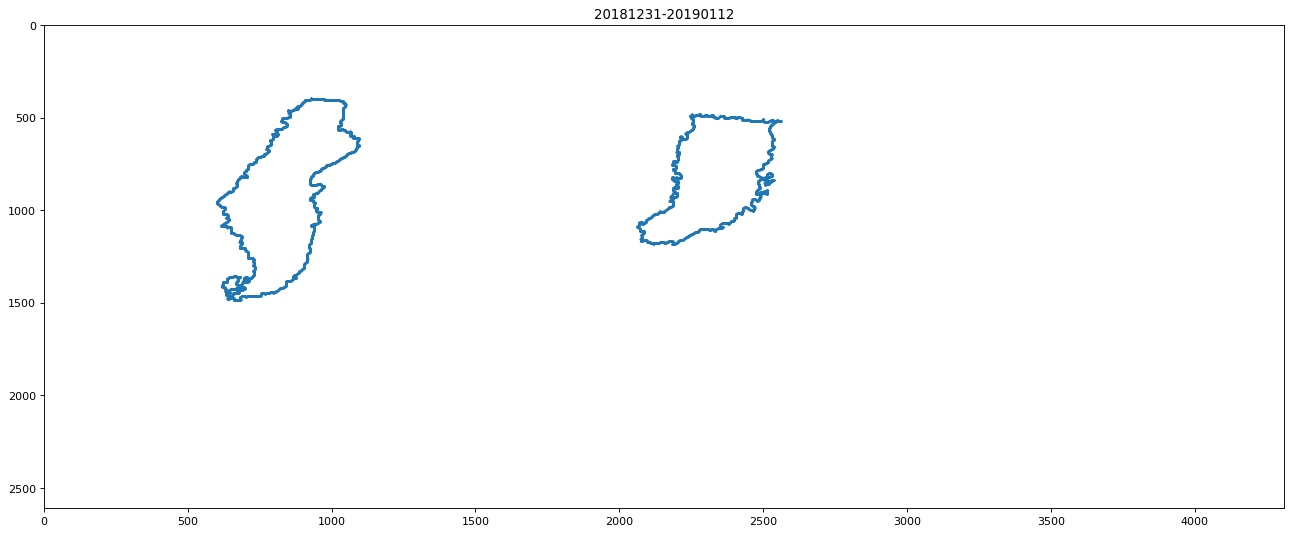

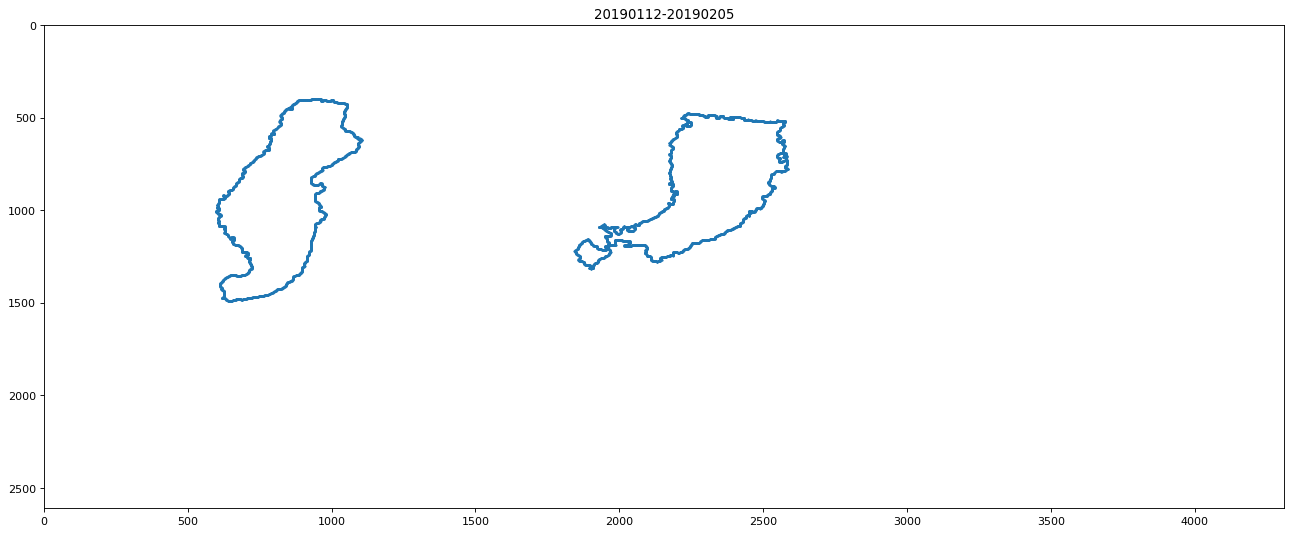

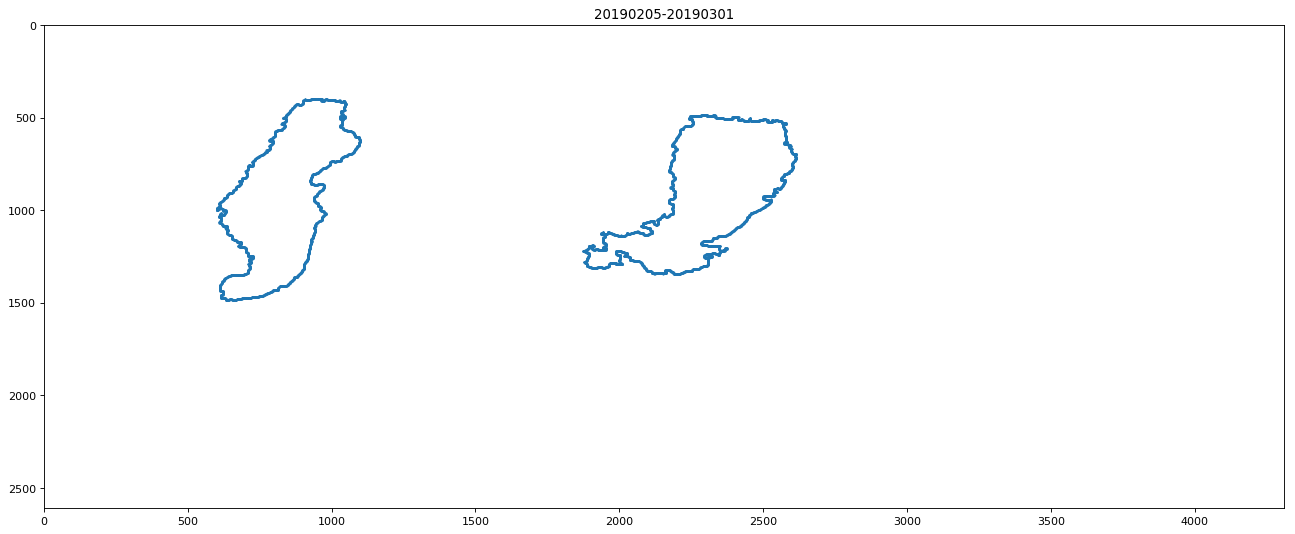

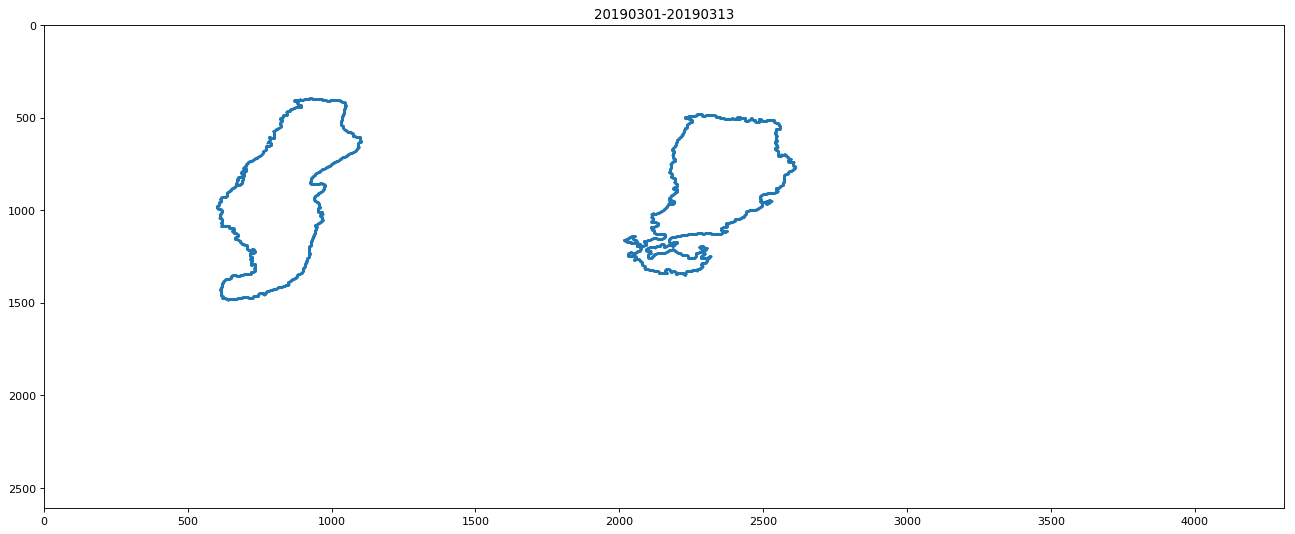

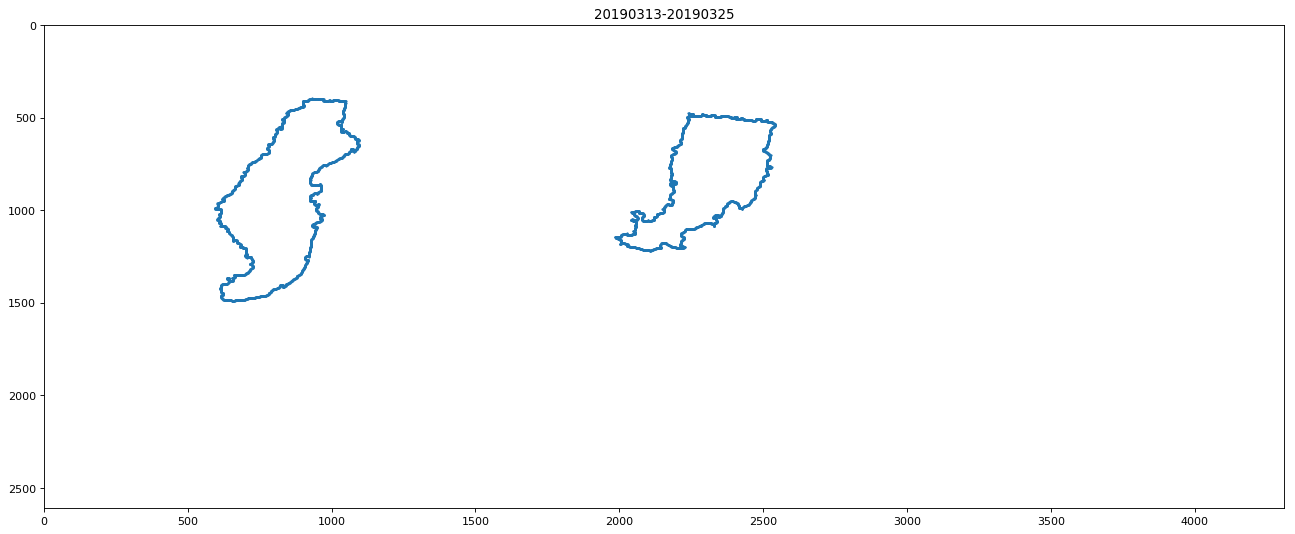

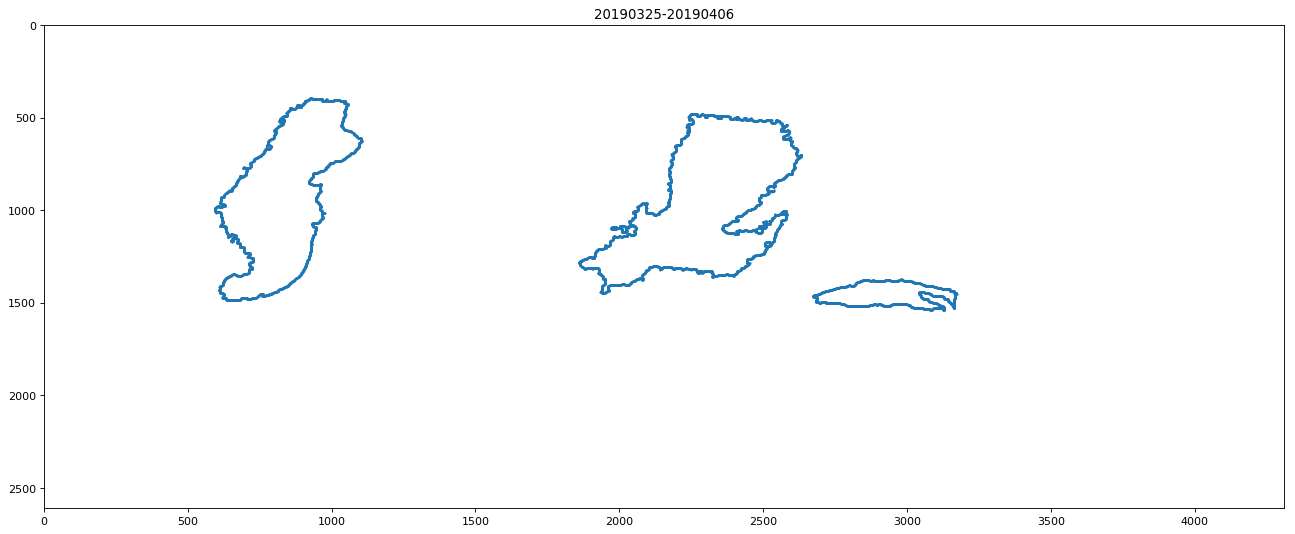

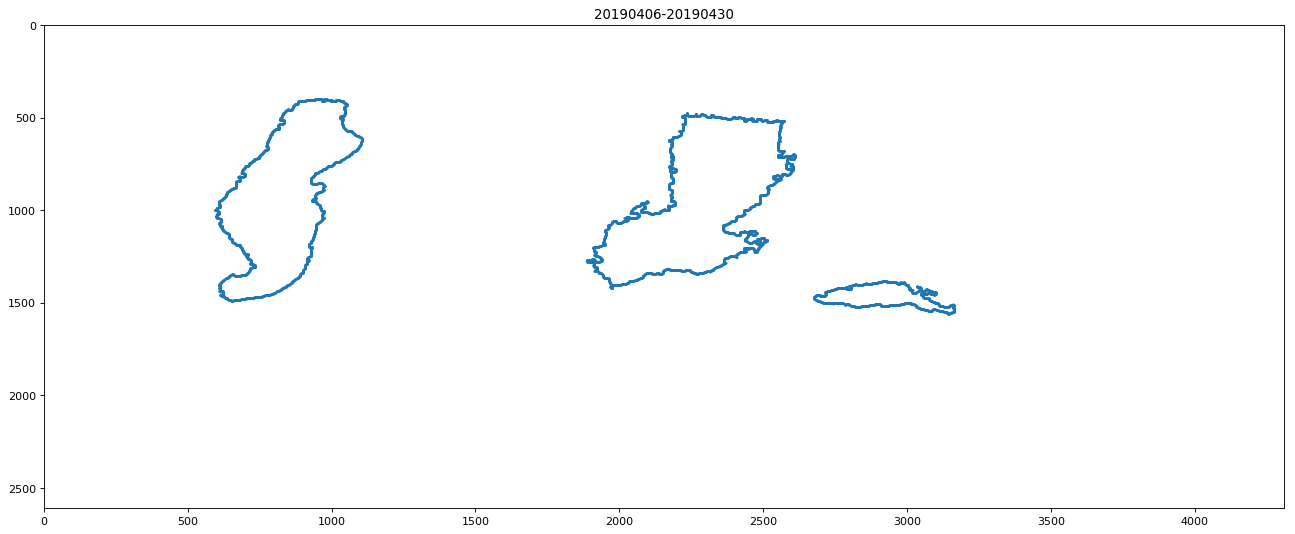

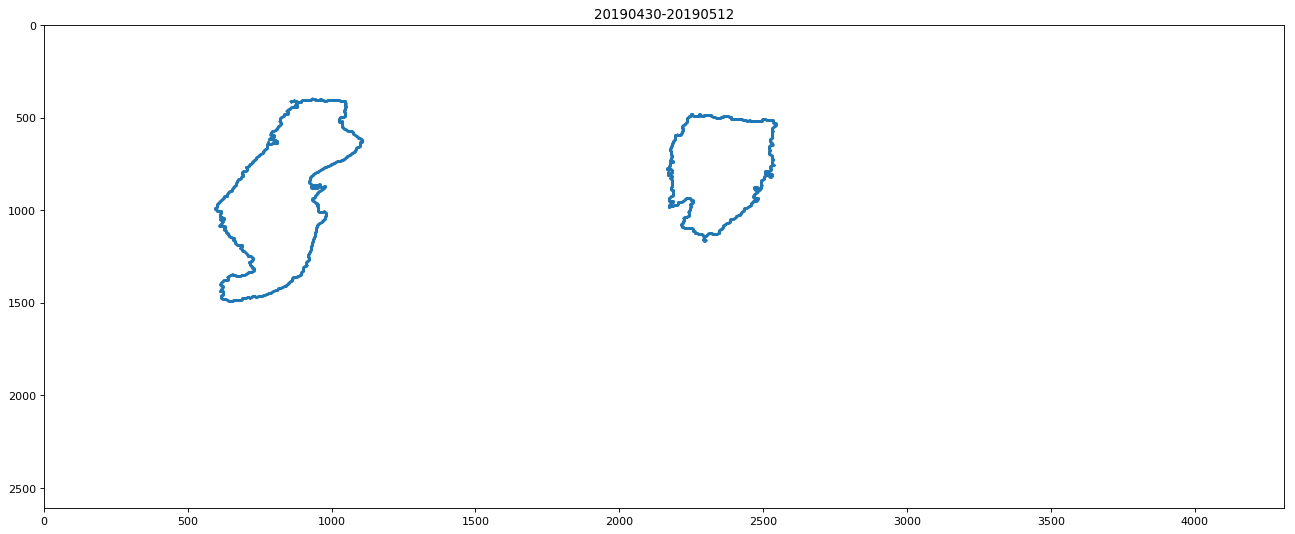

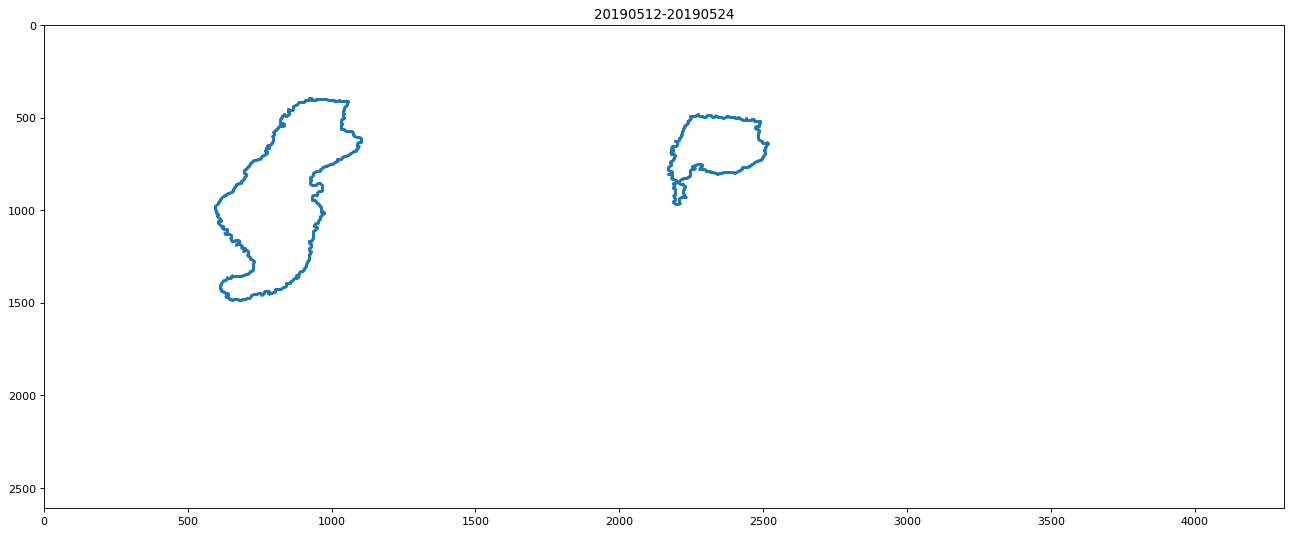

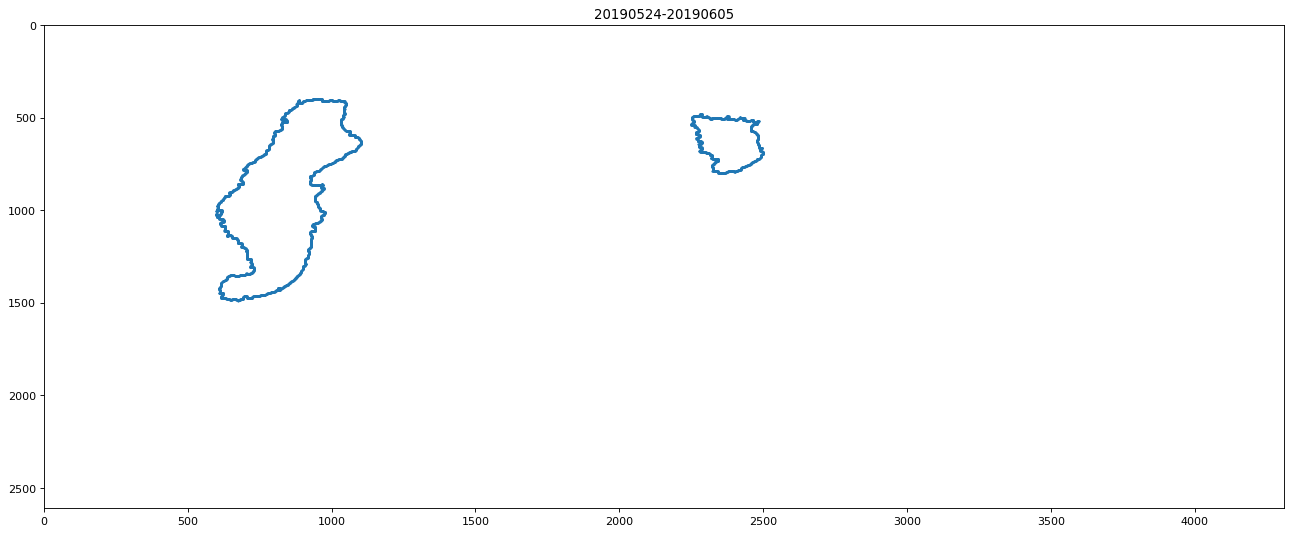

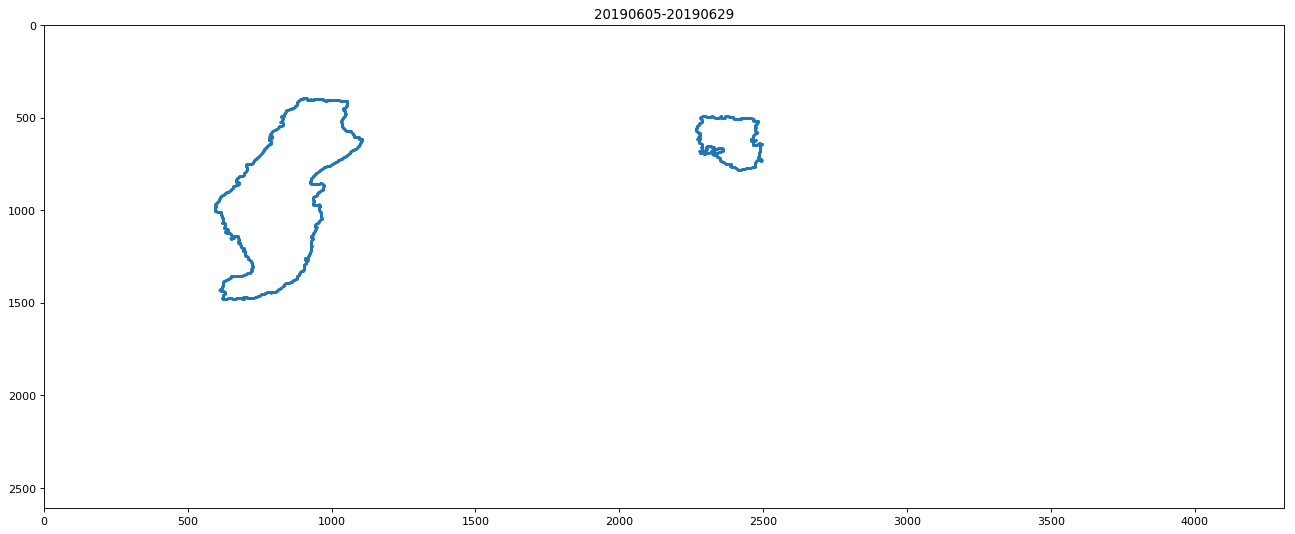

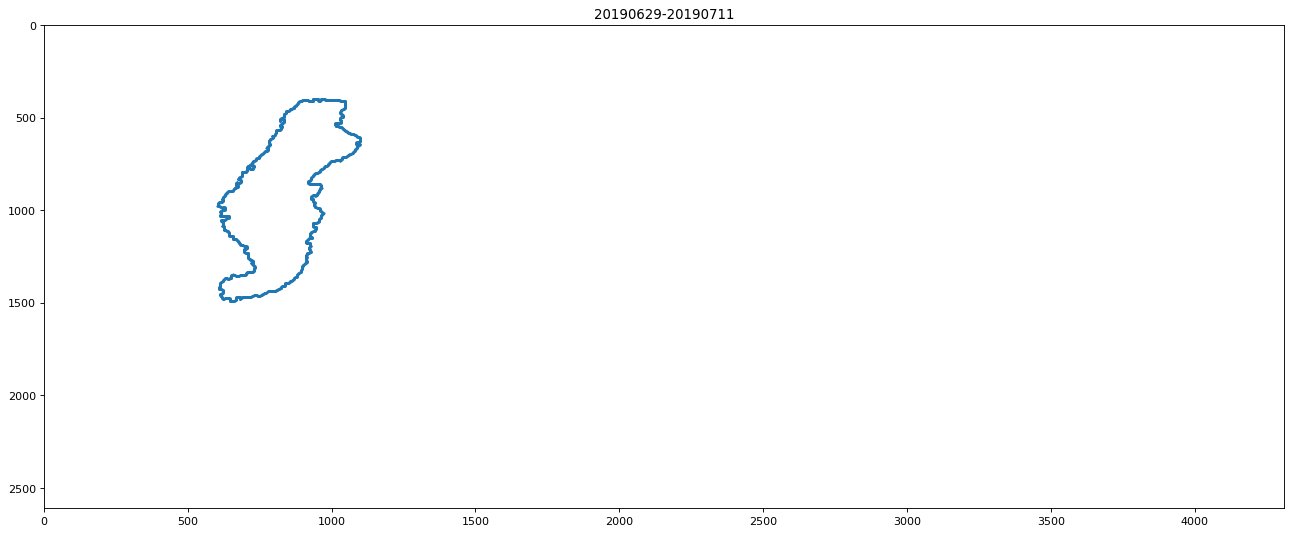

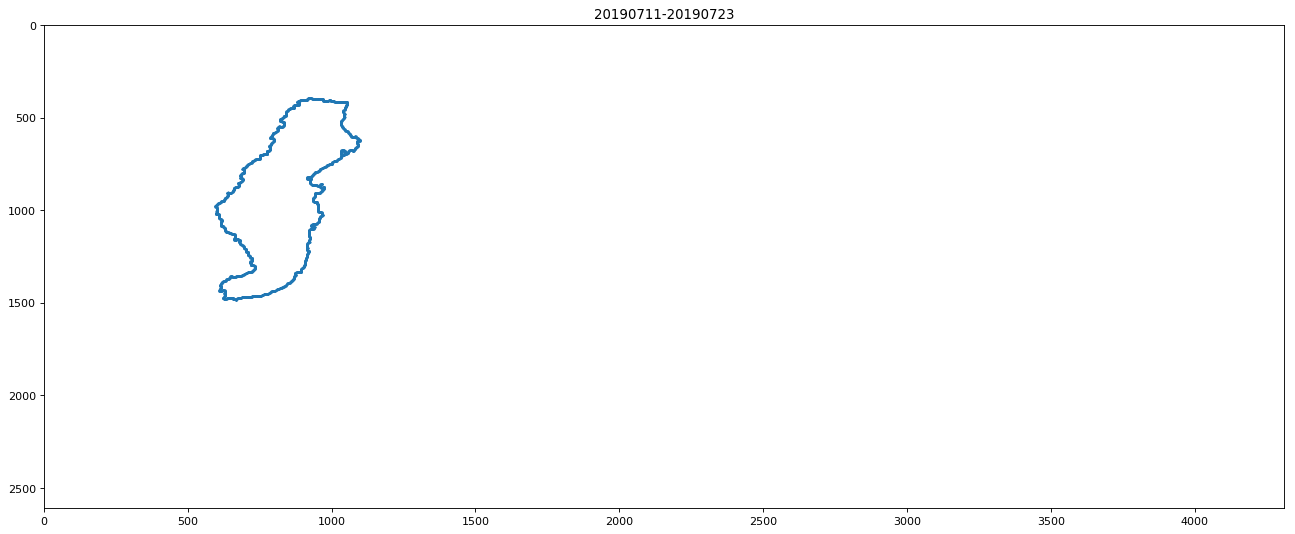

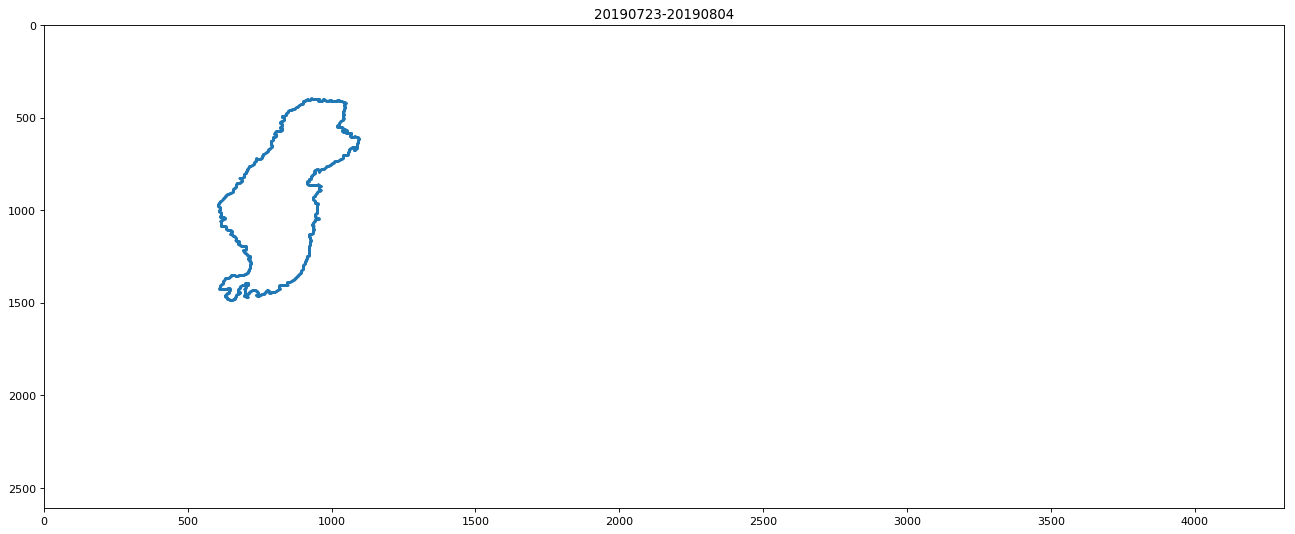

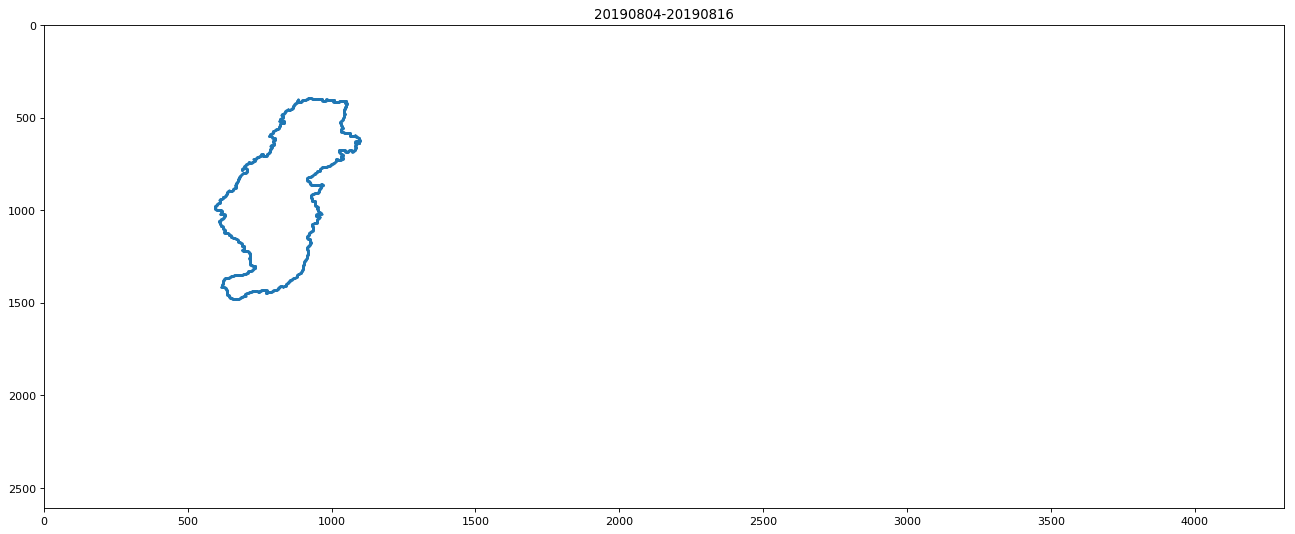

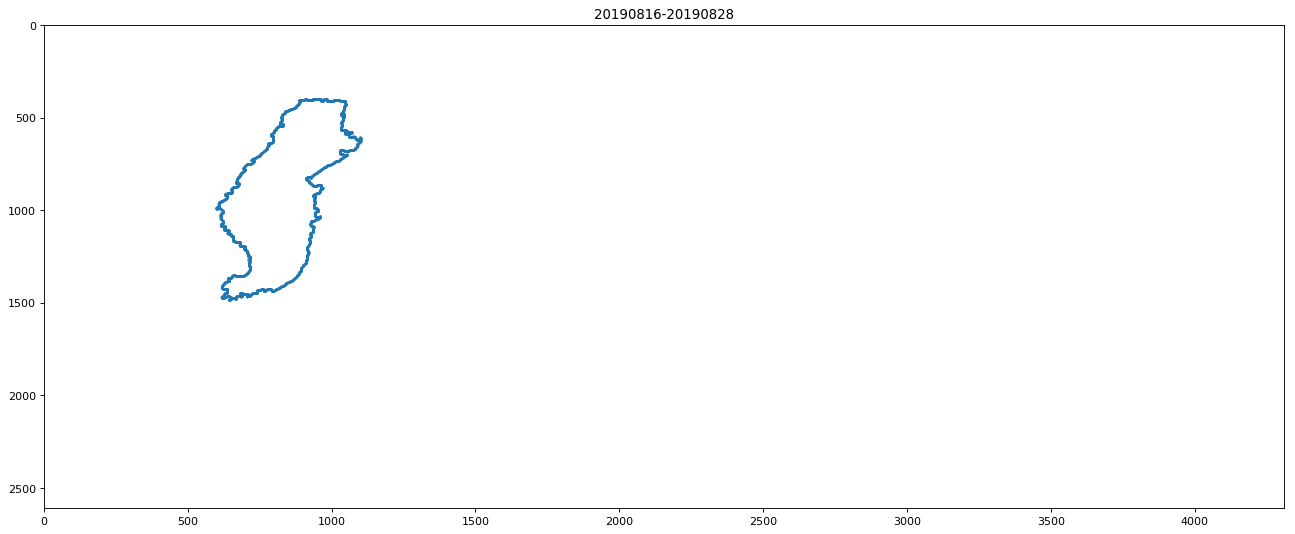

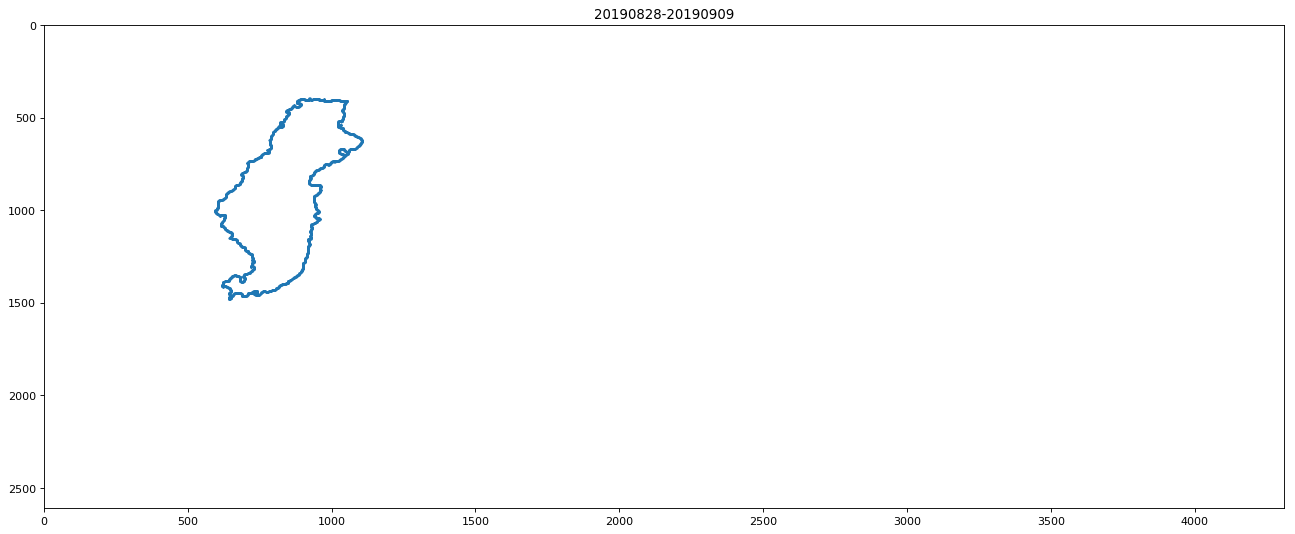

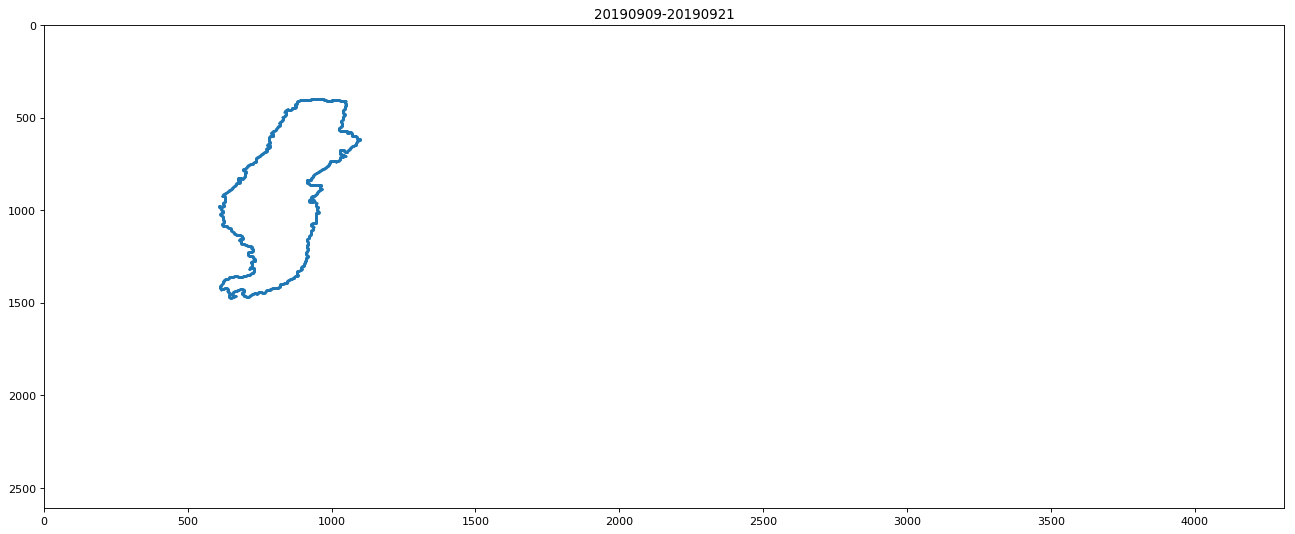

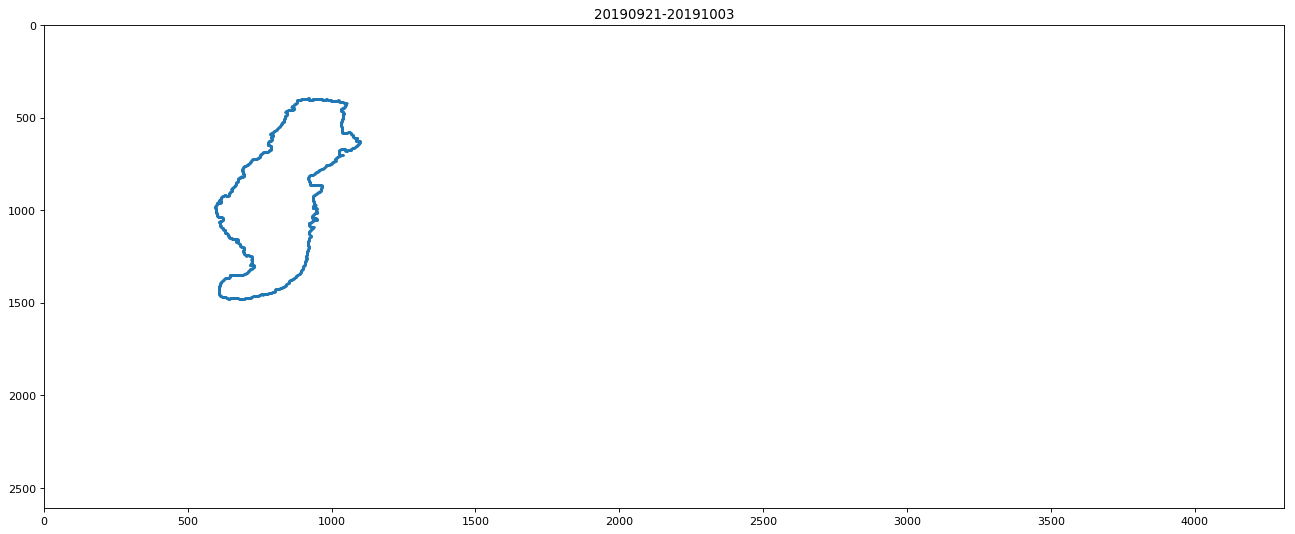

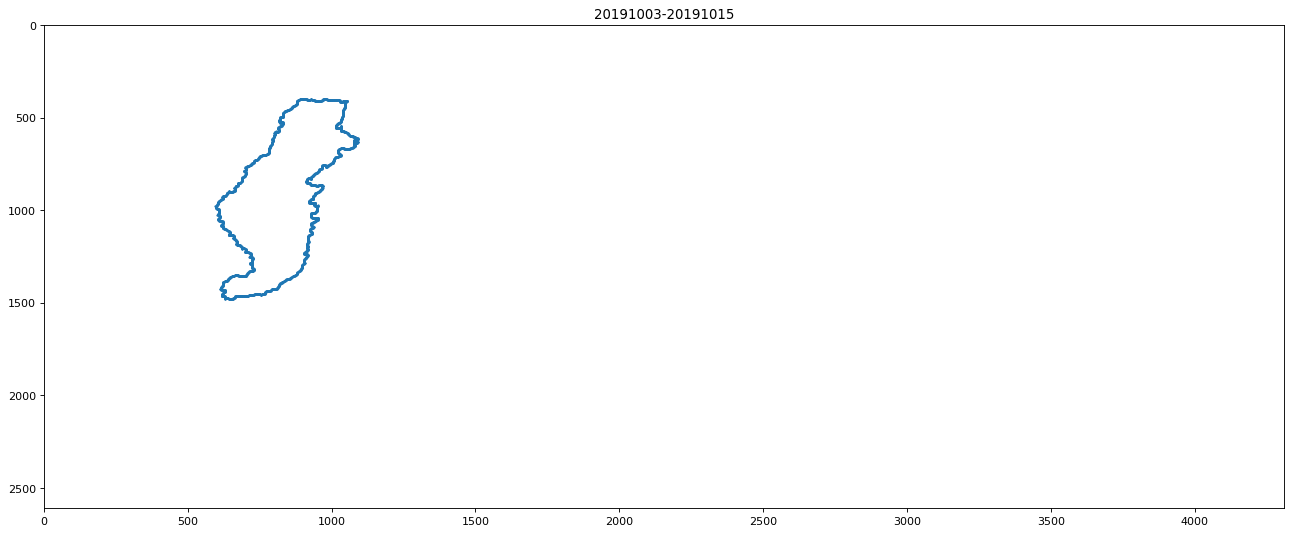

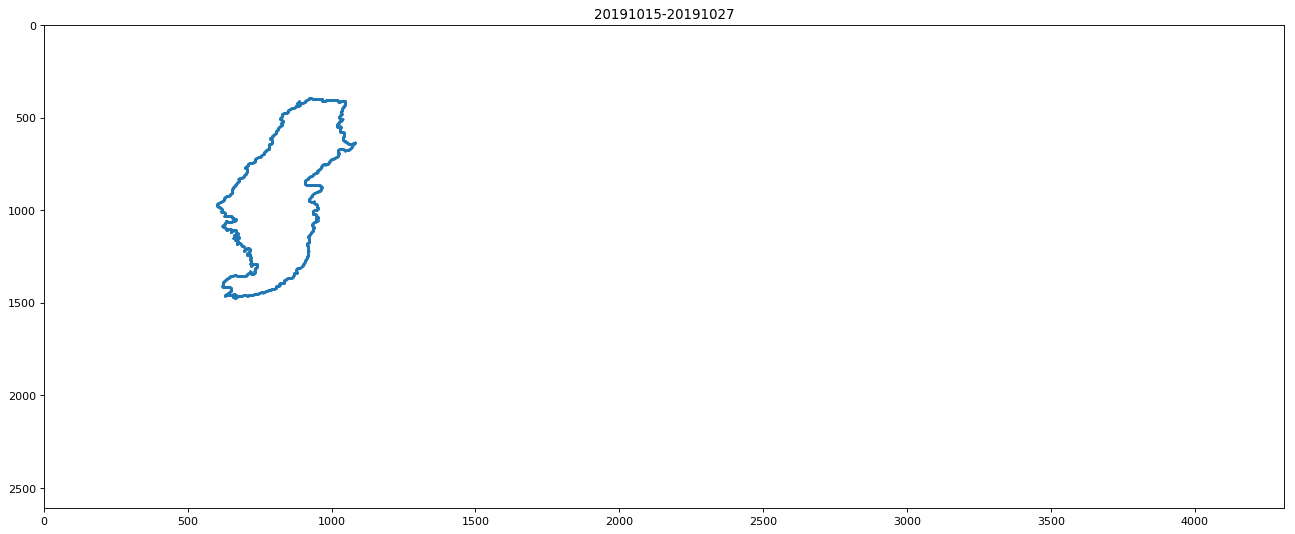

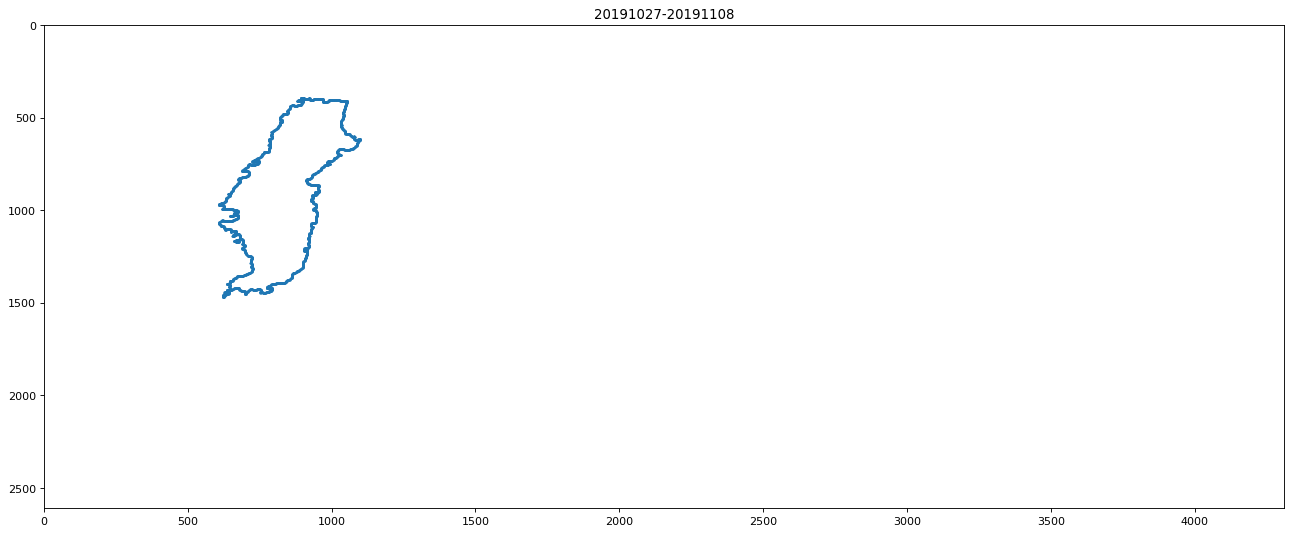

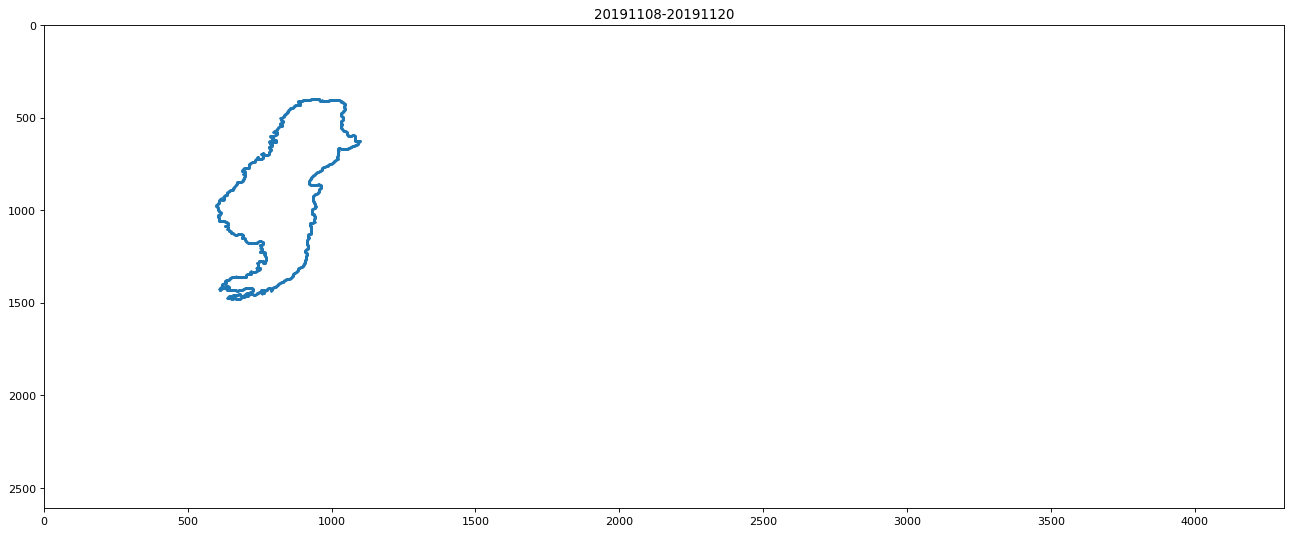

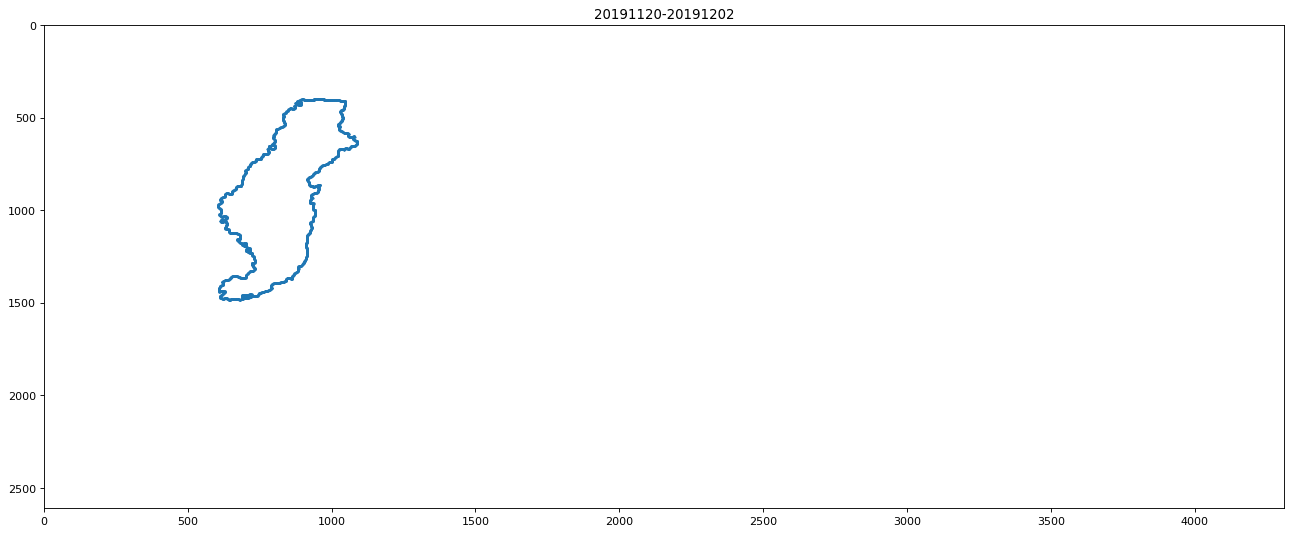

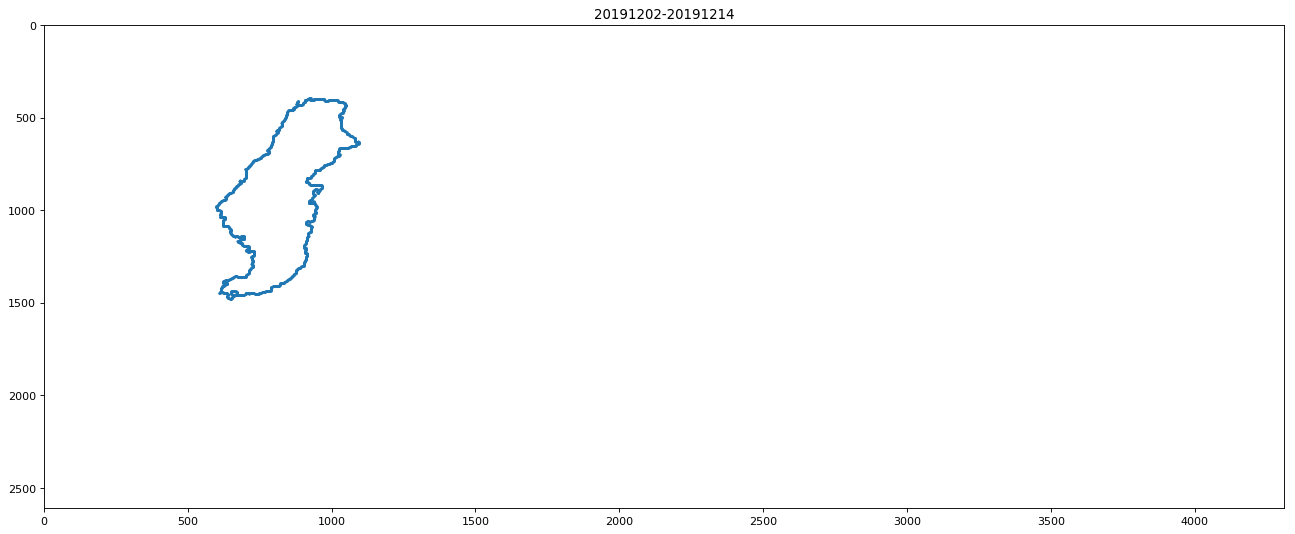

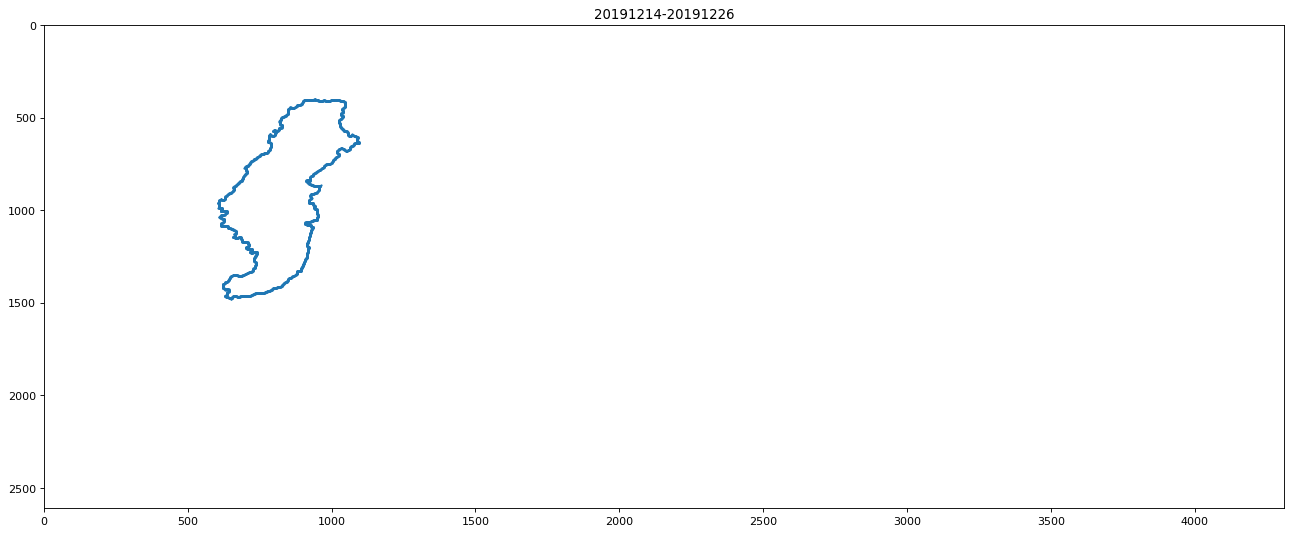

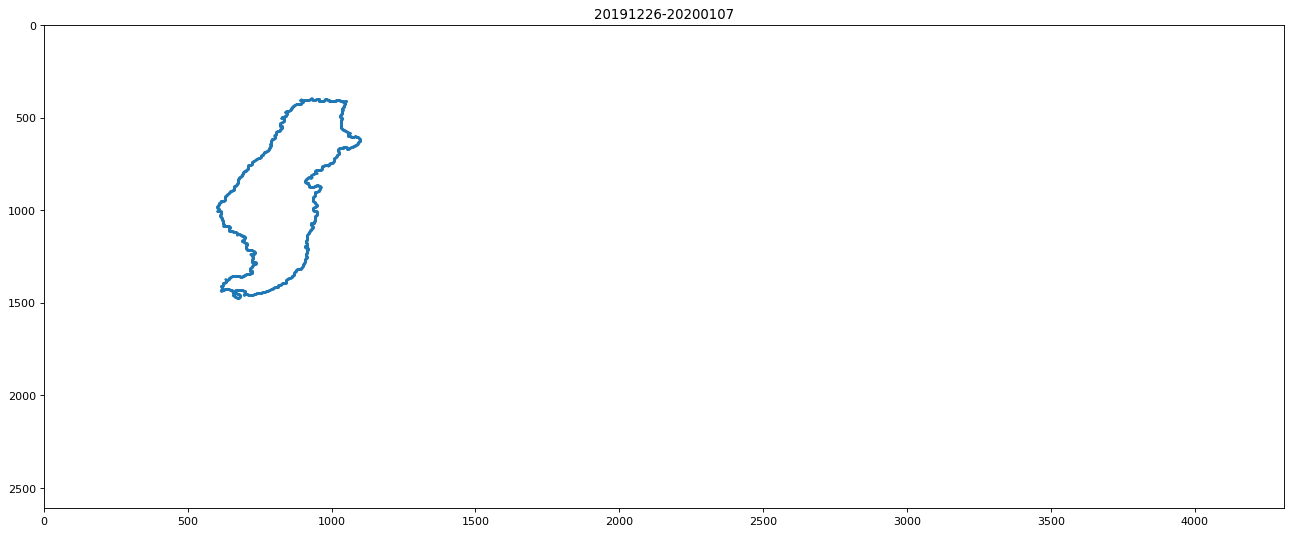

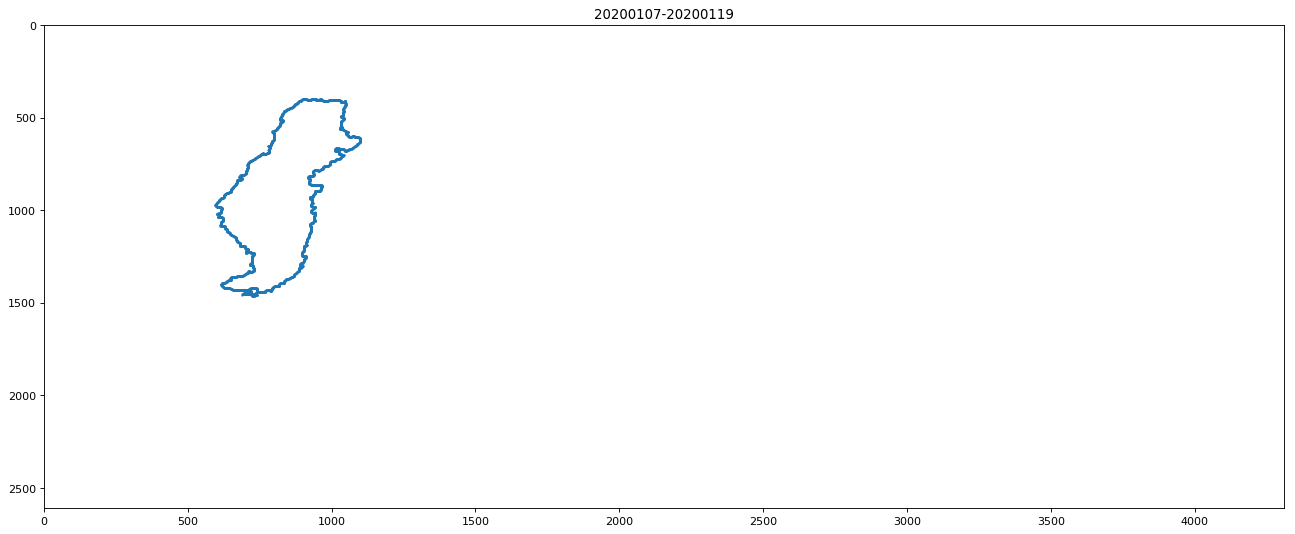

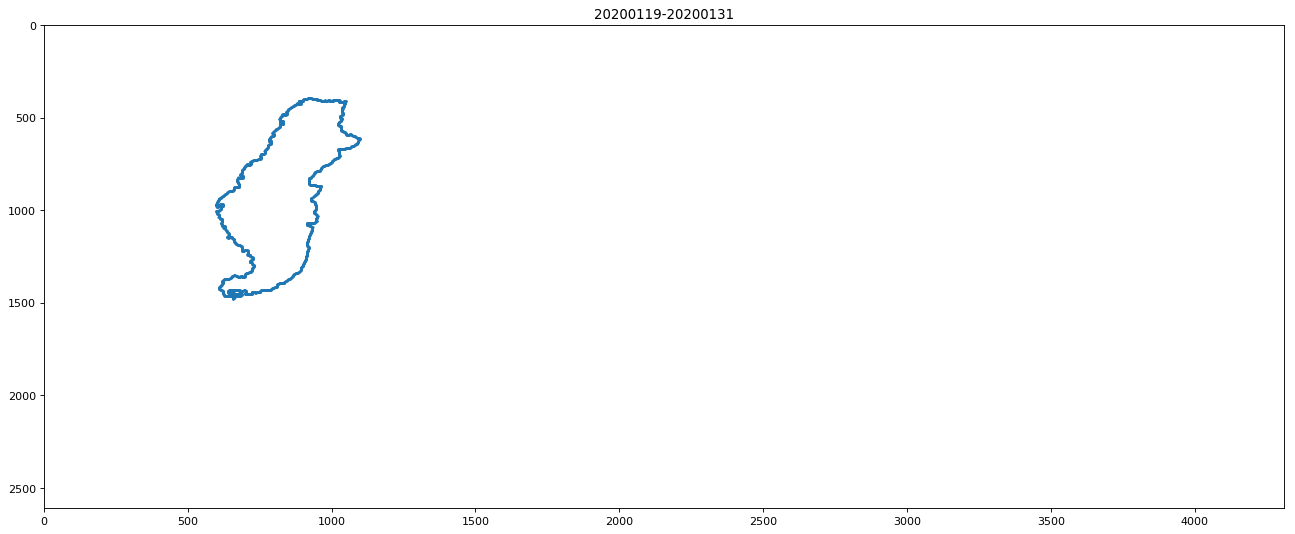

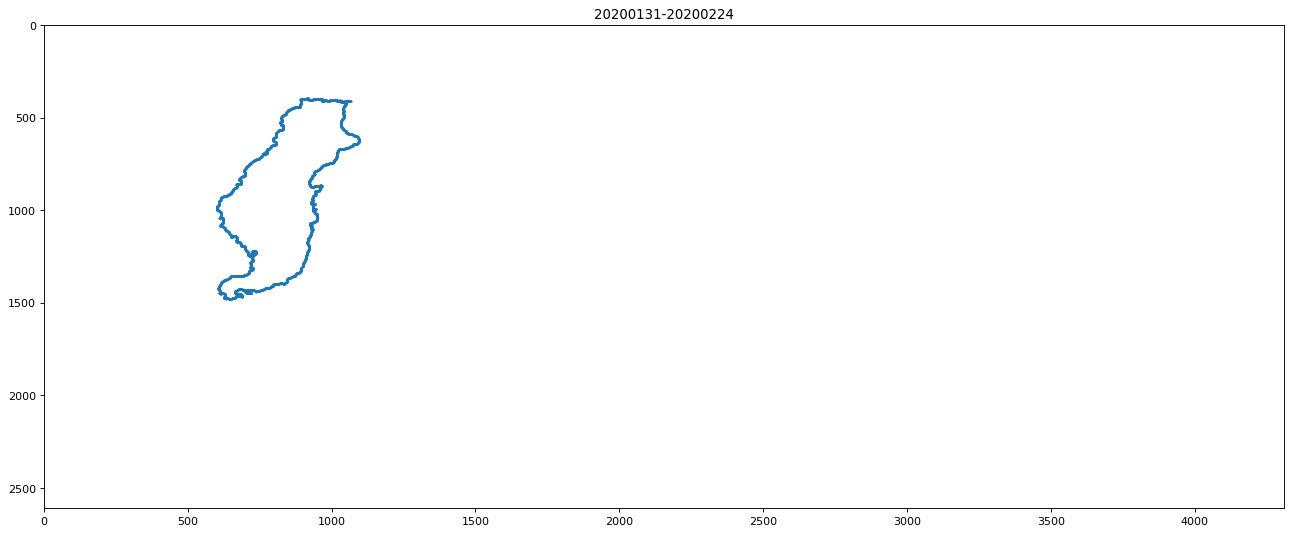

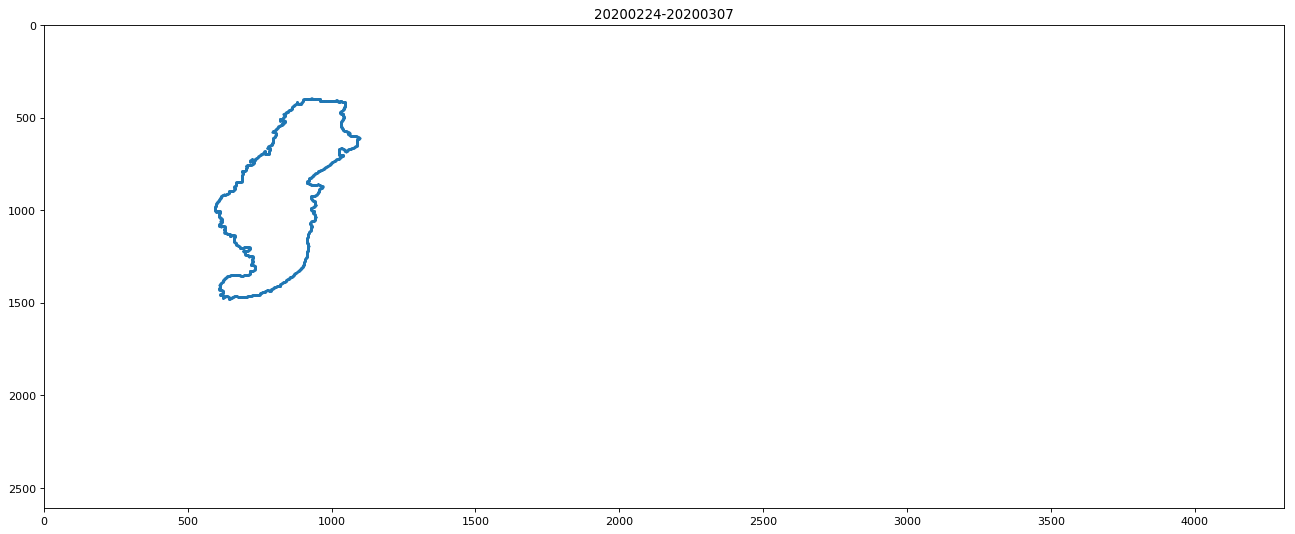

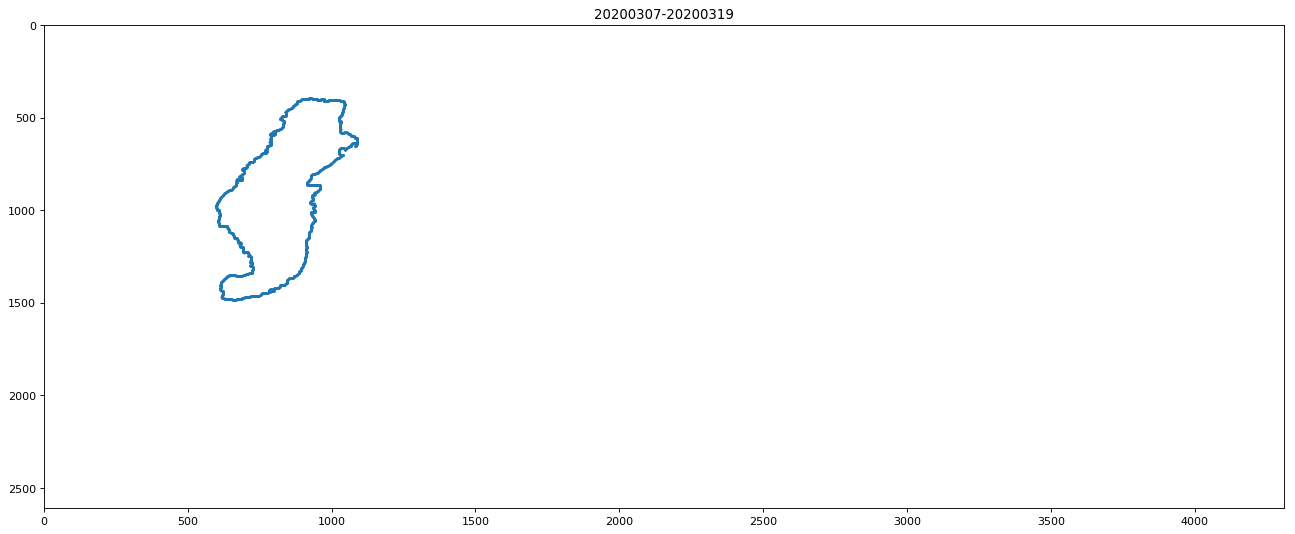

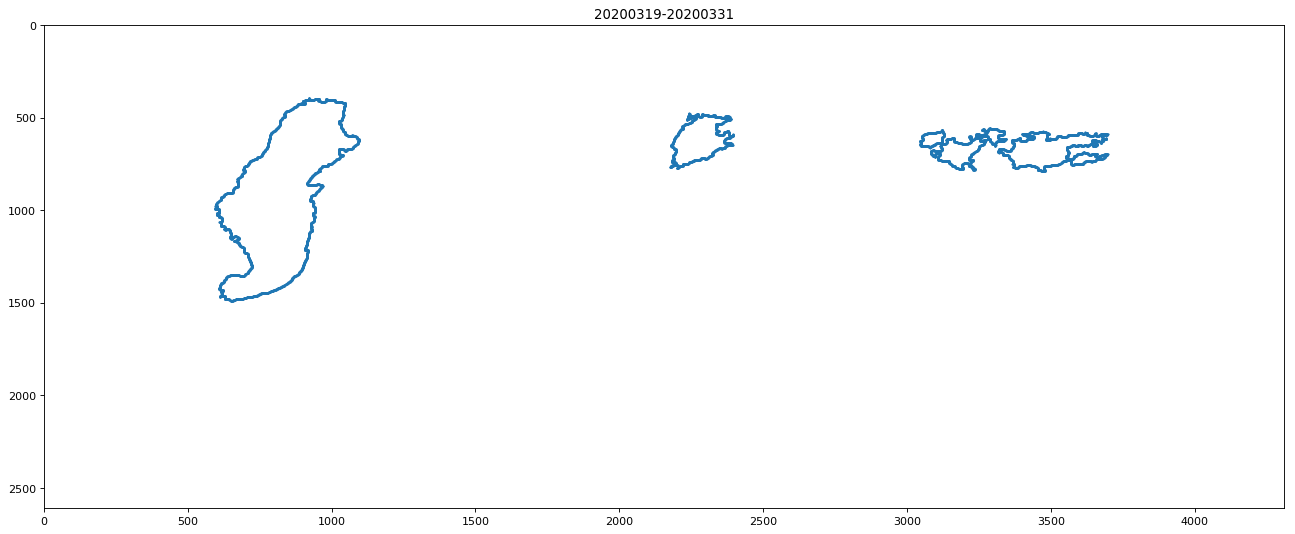

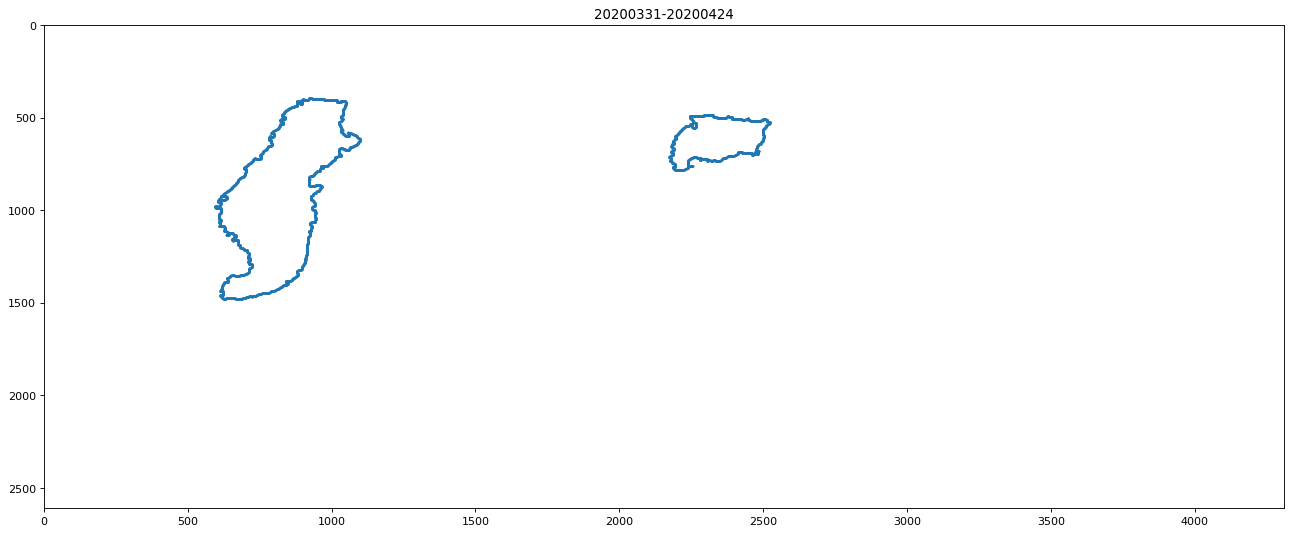

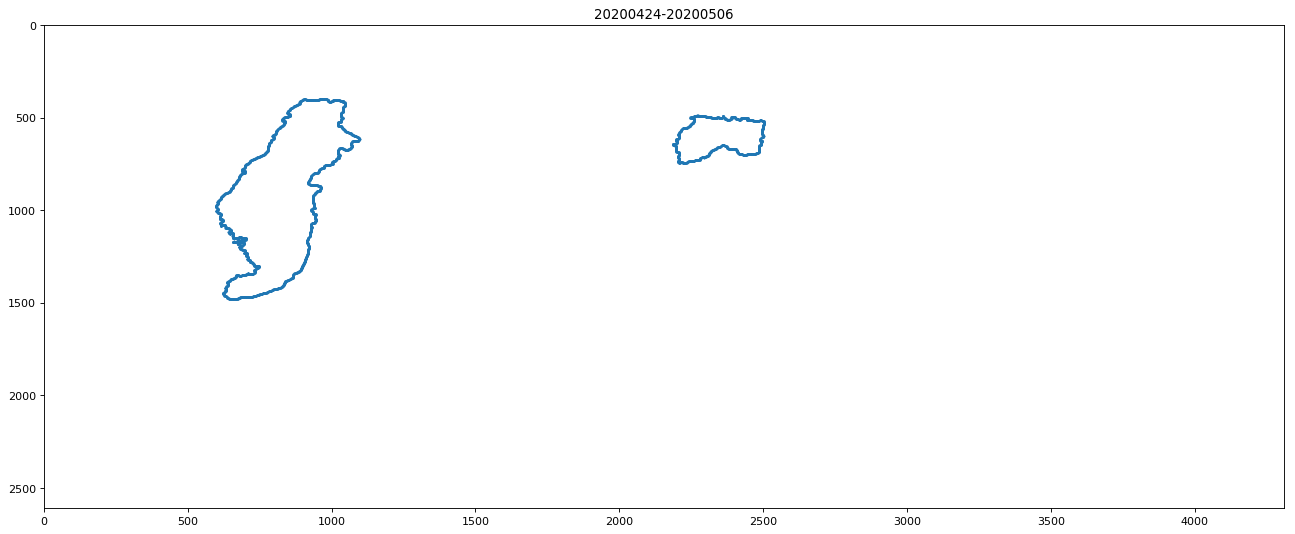

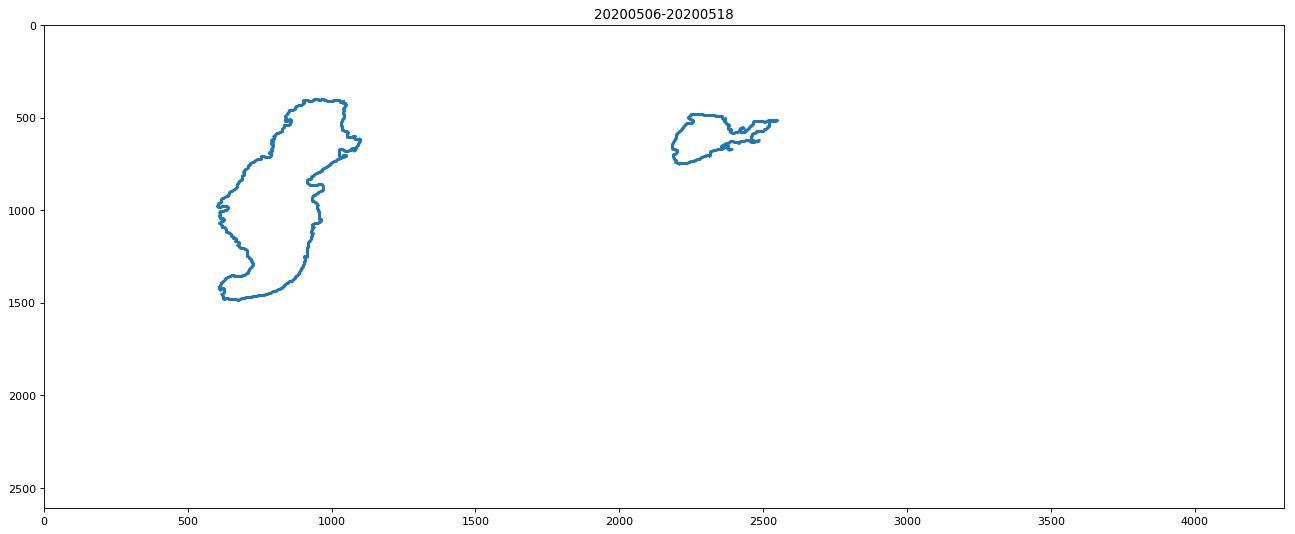

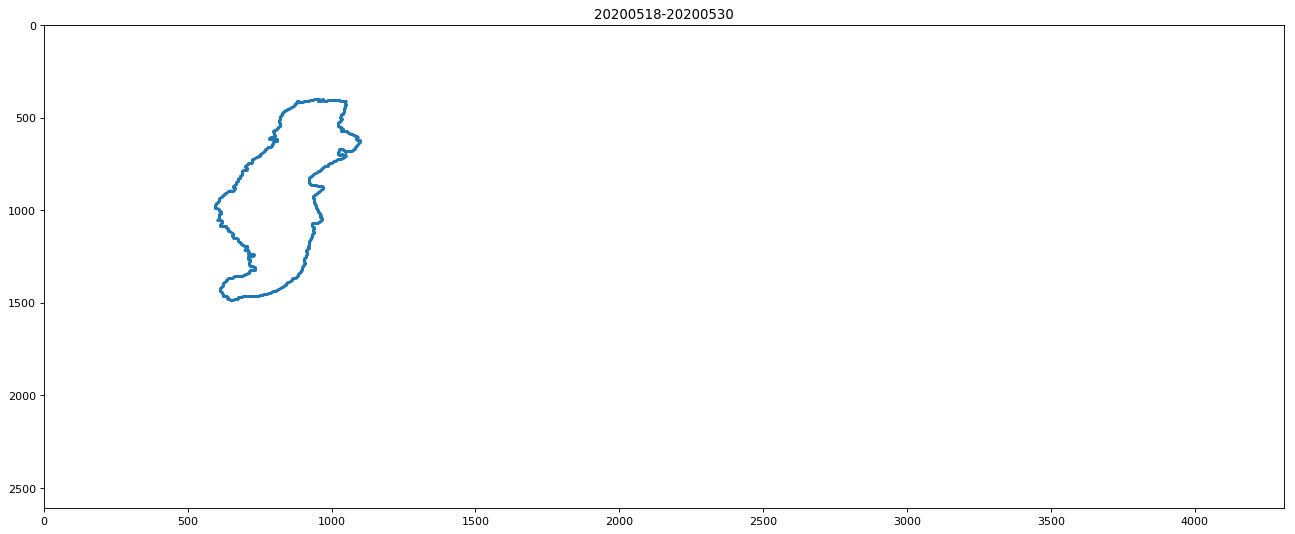

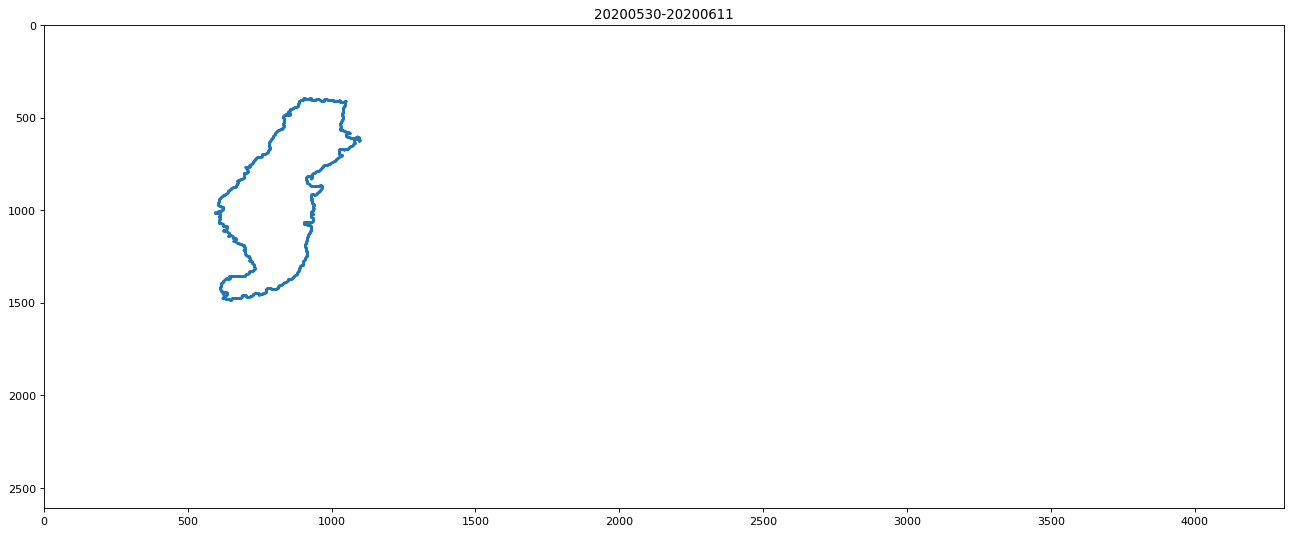

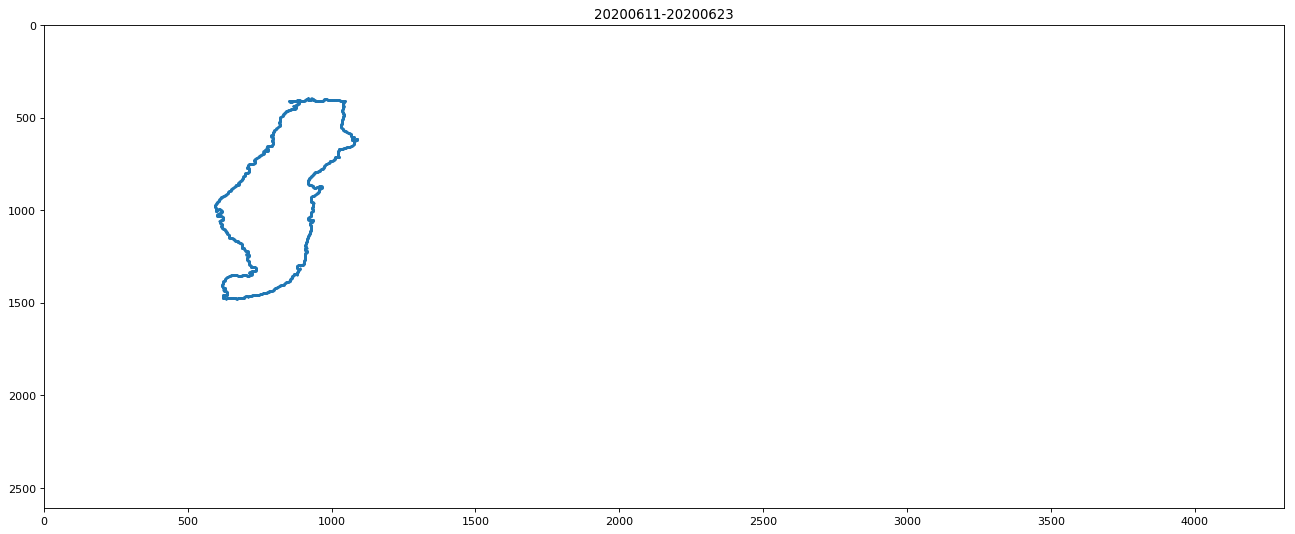

In [23]:
# Looping Plot
save_root = 'E:\Aral_data_download'
file_list = os.listdir(save_root)
file_nums = len(file_list)-2
s_list, c_list = [], []
for i in range(file_nums):
    img_path = os.path.join(save_root,'{}\dint_geocode_rs.png'.format(file_list[i+1]))
    mask_path = os.path.join(save_root,'{}\epoch2460_0608_infer_dint_geocode.png'.format(file_list[i+1]))
    plt.figure(figsize=(20,8),dpi=80)
    s,c = plot_figure(img_path, mask_path)
    s_list.append(s)
    c_list.append(c)
    plt.xlim(0,4310)
    plt.ylim(0,2610)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.title('{}'.format(os.listdir(save_root)[i+1]))
  

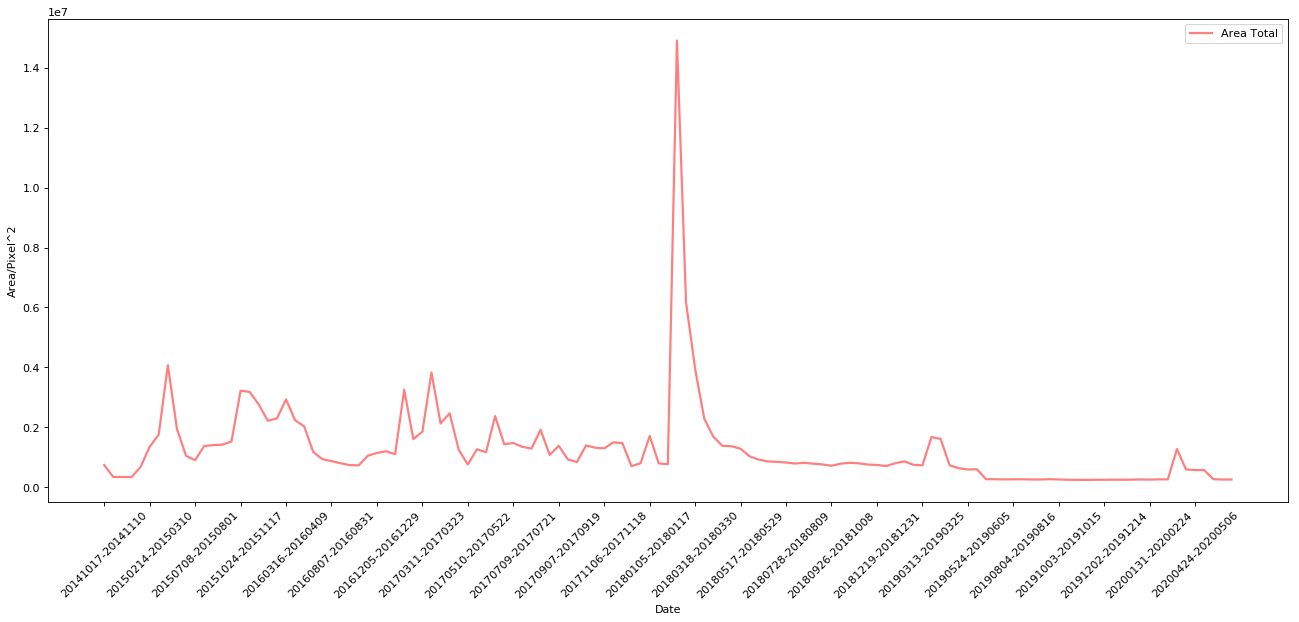

In [24]:
# Draw Area 
x = range(len(s_list))
xtick_labels = [file_list[i+1] for i in range(0,len(file_list)-2)]

plt.figure(figsize=(20,8),dpi=80)
plt.plot(x,s_list,label='Area Total',color='red',linewidth=2,alpha=0.5)
plt.xlabel('Date');plt.ylabel('Area/Pixel^2')
plt.xticks(list(x)[::5], xtick_labels[::5], rotation=45)
plt.legend()
plt.show()

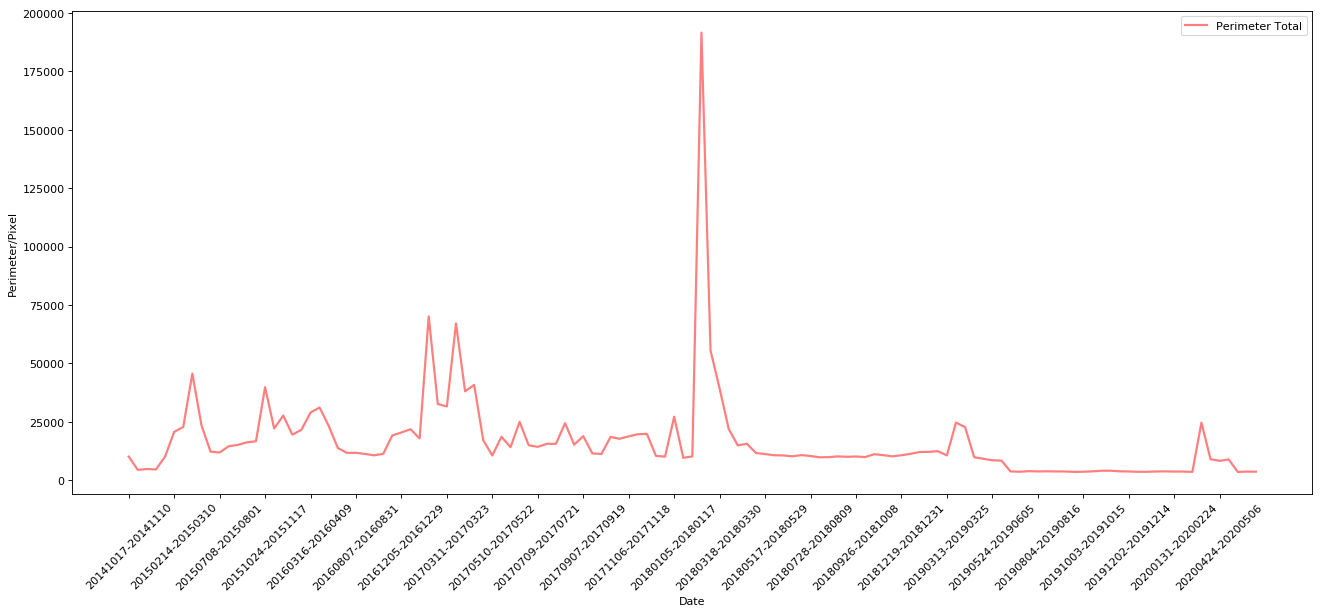

In [25]:
# Draw Perimeter
x = range(len(c_list))
xtick_labels = [file_list[i+1] for i in range(0,len(file_list)-2)]

plt.figure(figsize=(20,8),dpi=80)
plt.plot(x,c_list,label='Perimeter Total',color='red',linewidth=2,alpha=0.5)
plt.xlabel('Date');plt.ylabel('Perimeter/Pixel')
plt.xticks(list(x)[::5], xtick_labels[::5], rotation=45)
plt.legend()
plt.show()

## Draft Codes

0.5


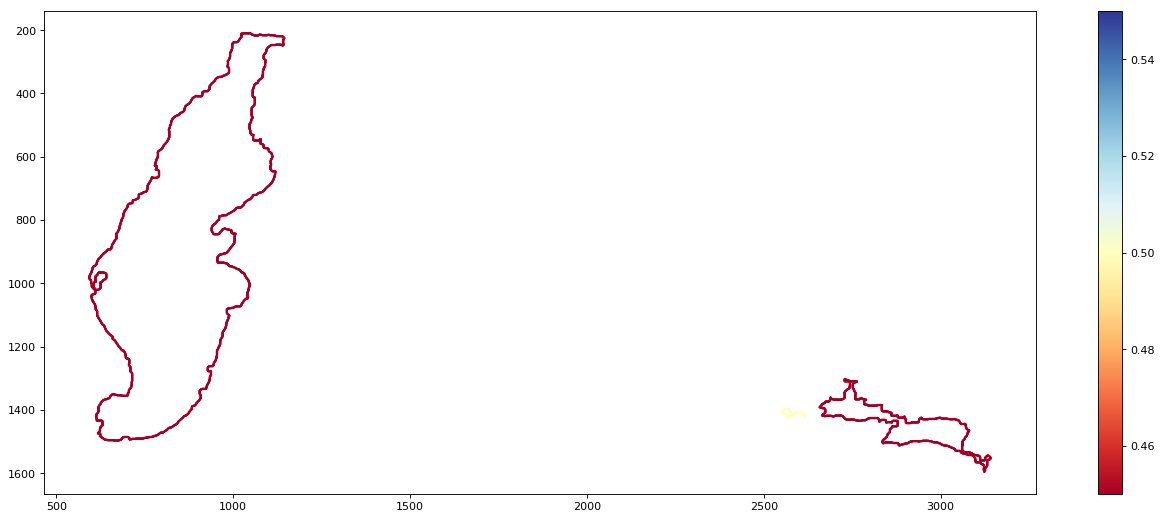

In [26]:
# Draw Boundary   
plt.figure(figsize=(20,8),dpi=80)
cm = plt.cm.get_cmap('RdYlBu')
# xy = range(20)
# for i in range(len(b1_x)):
for i in range(1):
#     seed = i*(1/len(b1_x))
    seed = 0.5
    print(seed)
    c1 = [seed]*len(b1_x[i])
    c2 = [seed]*len(b2_x[i])
    c3 = [seed]*len(b3_x[i])
    plt.scatter(b1_x[i],b1_y[i],c=c1,s=1, cmap=cm)
    plt.scatter(b2_x[i],b2_y[i],c=c2,s=1, cmap=cm)
    plt.scatter(b3_x[i],b3_y[i],c=c3,s=1, cmap=cm)
ax = plt.gca()
ax.invert_yaxis()
plt.colorbar()
plt.show()

In [ ]:
import os,shutil
# Extract intereted file name and idx

ori_path = 'E:\intf_list'
tar_path = 'E:\Aral_data'

file_list = os.listdir(ori_path)
idx_list = [0]
for i in range(len(file_list)-1):
    if file_list[i][0:8] != file_list[i+1][0:8]:
        idx_list.append(i+1)
    else:
        continue  
# for i in range(len(idx_list)):
#     print(idx_list[i])
#     print(file_list[idx_list[i]])

# Copy files to tar_folders
for i in range(len(idx_list)):
    shutil.copy(os.path.join(ori_path,file_list[idx_list[i]], 'dint_geocode.png'), os.path.join(tar_path,file_list[idx_list[i]], 'dint_geocode.png'))
    shutil.copy(os.path.join(ori_path,file_list[idx_list[i]], 'coh_geocode.png'), os.path.join(tar_path,file_list[idx_list[i]], 'coh_geocode.png'))
print('Copy done!')

In [ ]:
# Mkdir
path = 'E:\Aral_data'
os.chdir(path)
for i in range(len(idx_list)):
    os.mkdir(file_list[idx_list[i]])
